# QPM Project: Regime-Switching Crypto Portfolio

## Objective
This project builds a **regime-aware crypto portfolio** consists of **BTC,ETH and USDT** that adapts to market conditions and aims to outperform simple benchmarks (BTC/ETH buy-and-hold, cash, and naive equal-weight strategies).

---

## Methodology

### 1. Rolling Windows
- The dataset is split into **rolling 3-month windows** (2017 → 2023).
- At each window, only **past data** is used to avoid look-ahead bias.

### 2. Regime Detection (HMM)
- Features are engineered from BTC (daily returns, multi-horizon volatility, momentum, skew, kurtosis).
- A **Gaussian Hidden Markov Model (HMM)** is fit to detect **Bear, Neutral, and Bull regimes**.
- Market regimes are assigned based on **mean returns** of the hidden states.
- Regimes are visualized with **price shading**, **posterior probabilities**, and **transition matrices**.

### 3. Asset Universe
- The **investable set is fixed** to three assets:
  - **BTC%**
  - **ETH%**
  - **USDT%**

### 4. Time-Series Modeling per Asset
- For each asset:
  - **ARIMA** is fitted (order chosen via AIC/BIC).
  - **GJR-GARCH(1,1)** models the conditional volatility of residuals.
- Standardized residuals are obtained for dependence modeling.

### 5. Dependence Modeling (Vine Copula)
- A **vine copula** is fitted to standardized residuals to capture **cross-asset dependence**.
- Simulated joint return scenarios are generated (with skew-t marginals).

### 6. Portfolio Optimization
- Simulated return scenarios are used to construct the **efficient frontier**.
- A **quadratic programming solver** selects portfolios subject to:
  - Return and variance constraints
  - Box constraints on weights
  - **CVaR(95%) thresholds** to limit tail risk
- The **tangency portfolio** (max Sharpe ratio vs. daily risk-free) is chosen for each window.

### 7. Backtest & Performance Evaluation
- Out-of-sample returns are stitched across windows to build NAV.
- Benchmarks:
  - BTC buy-and-hold
  - ETH buy-and-hold
  - Risk-free (cash)
  - Naive equal-weight (rebalanced and buy & hold)
- A **fund-style performance report** includes:
  - CAGR, annual volatility
  - Sharpe, Sortino, Calmar ratios
  - Max Drawdown & duration
  - Omega ratio
  - Daily VaR(95%) and CVaR(95%)
  - Skewness, kurtosis
  - Information ratio vs. BTC

### 8. Visualization
The notebook generates and saves diagnostic plots for:
- Regime-shaded price charts
- HMM posterior probabilities
- Feature scatterplots
- Transition matrices
- State mean returns
- ARIMA/GARCH diagnostics
- Tangency portfolio weights
- Efficient frontier
- NAV comparison vs. benchmarks

---

## Key Contribution
A **regime-switching, copula-simulated portfolio strategy** that:
- Detects market regimes with HMM
- Models BTC/ETH/USDT returns via ARIMA–GJR-GARCH
- Captures dependence with vine copulas
- Allocates optimally on the efficient frontier with CVaR controls
- Benchmarks against naive and passive strategies

---

# Interpreting the HMM figures

- The model found **two very persistent regimes**: a positive-return **Bull** state and a negative-return **Bear** state.  
- **Bull is more persistent** than Bear (expected durations ≈ **100** vs **50** days).  
- Regime shading lines up with the **2017 run-up → 2018 drawdown**, i.e., the filter captures the market cycle.  
- **Posteriors are near 0/1** most of the time—great for gating, but watch for over-confidence at boundaries.


**Note**: Following figures are result from first iteration training set 01-01-2017 to 31-12-2018 (HMM) with result on 01-03-2019  

### Figure: Price with regime shading

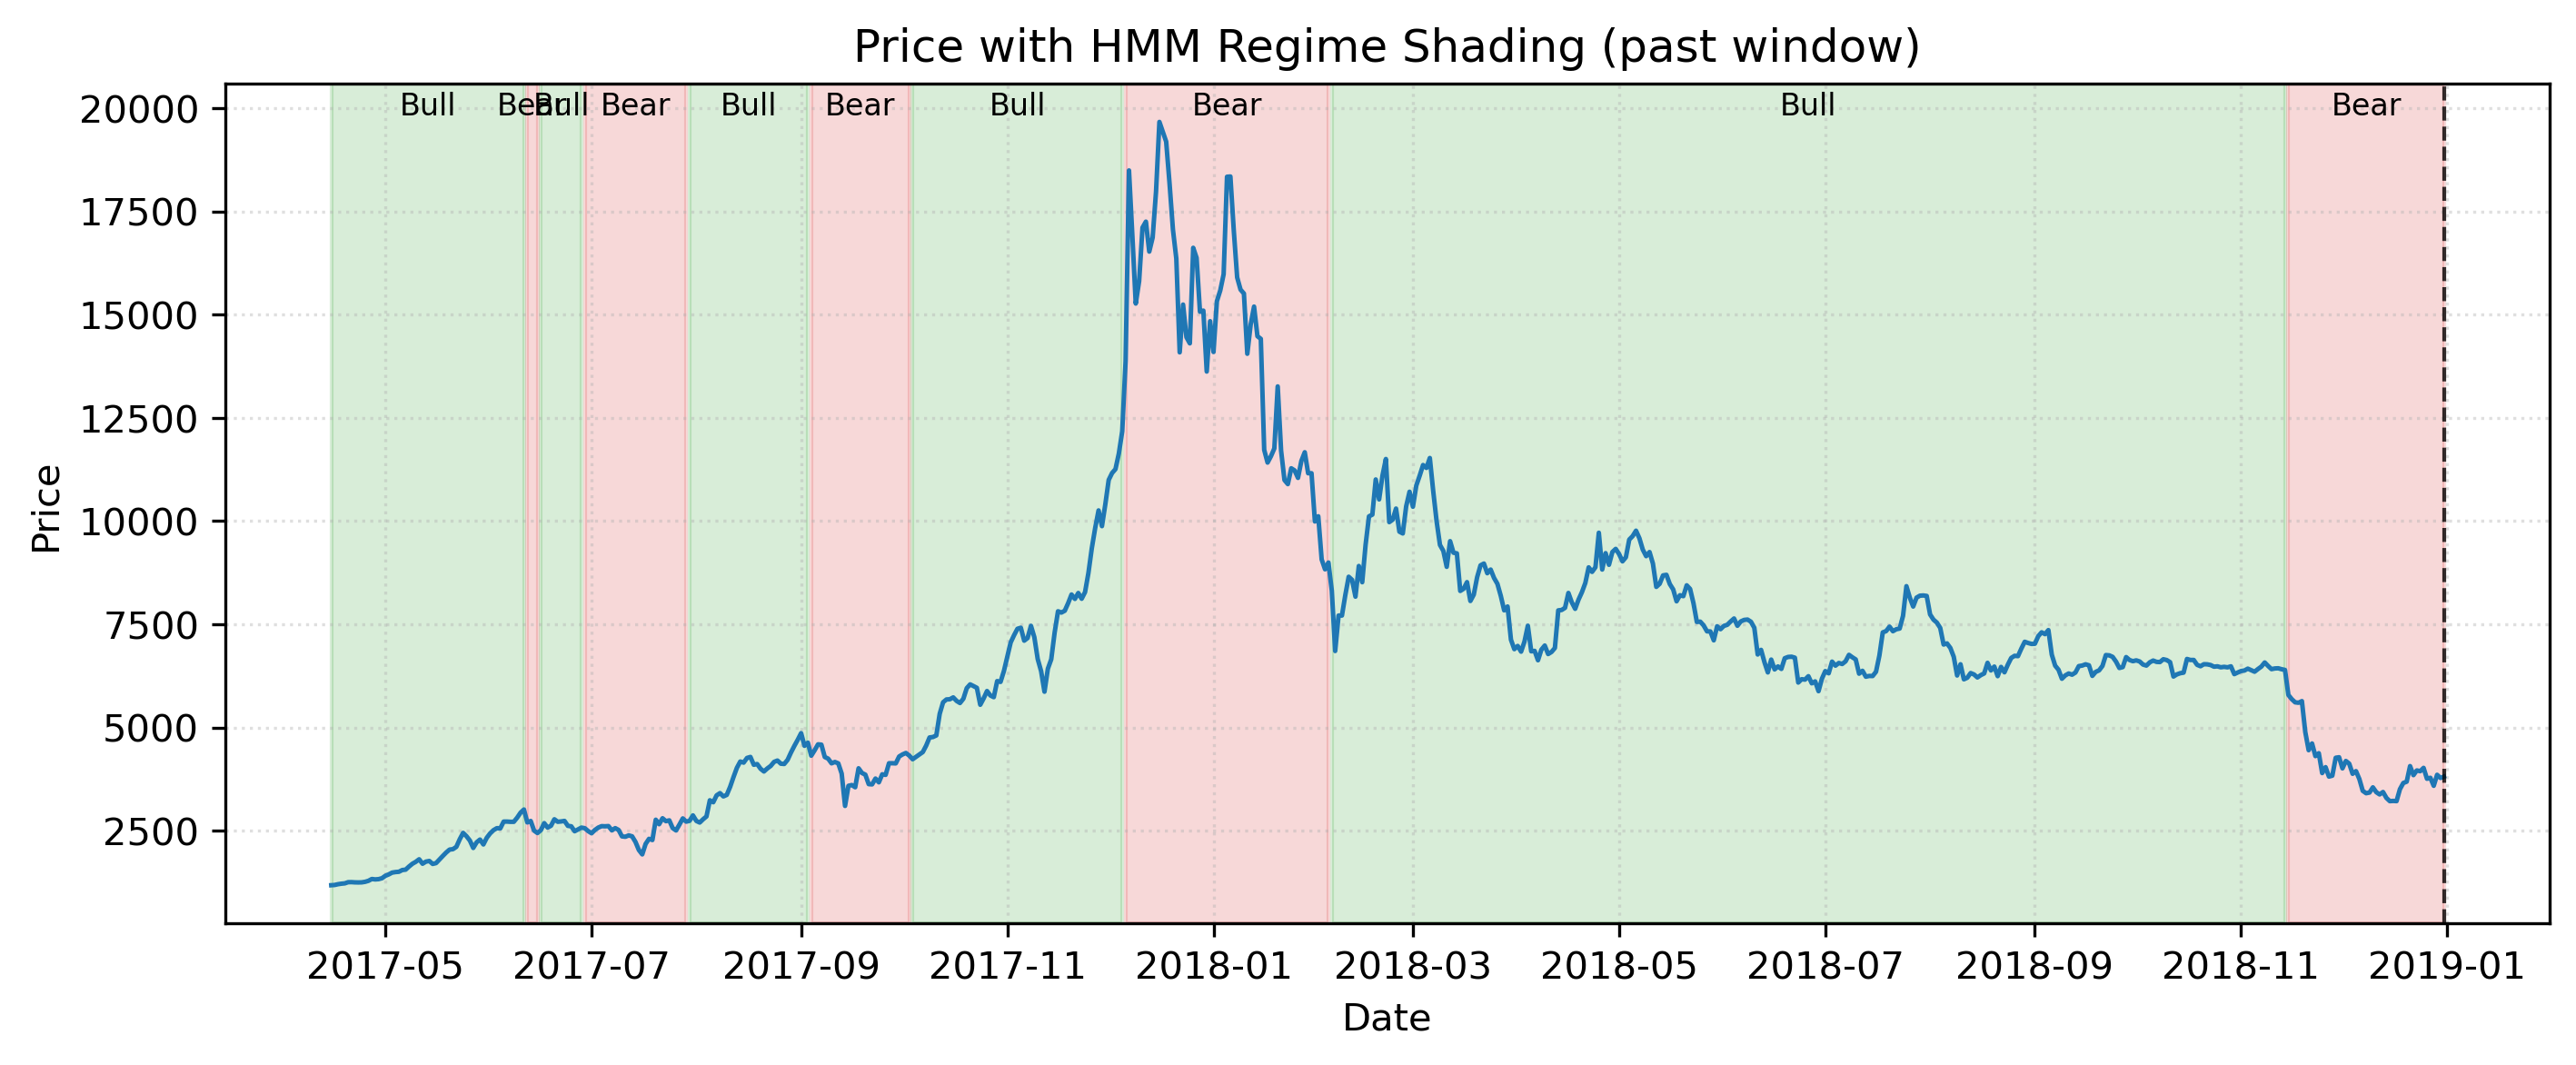

## Price with HMM Regime Shading (past window)
- Green bands (Bull) dominate through the 2017 rally; red bands (Bear) dominate during the 2018 drawdown.  
- Short flickers occur around regime changes—these can be suppressed with **hysteresis** and **minimum-dwell** rules.  
- The dashed vertical line marks the **decision date** (end of training window).

**Takeaway:** The segmentation matches the well-known BTC cycle; using this as a **market-wind filter** is sensible.


### Figure: State posterior probabilities

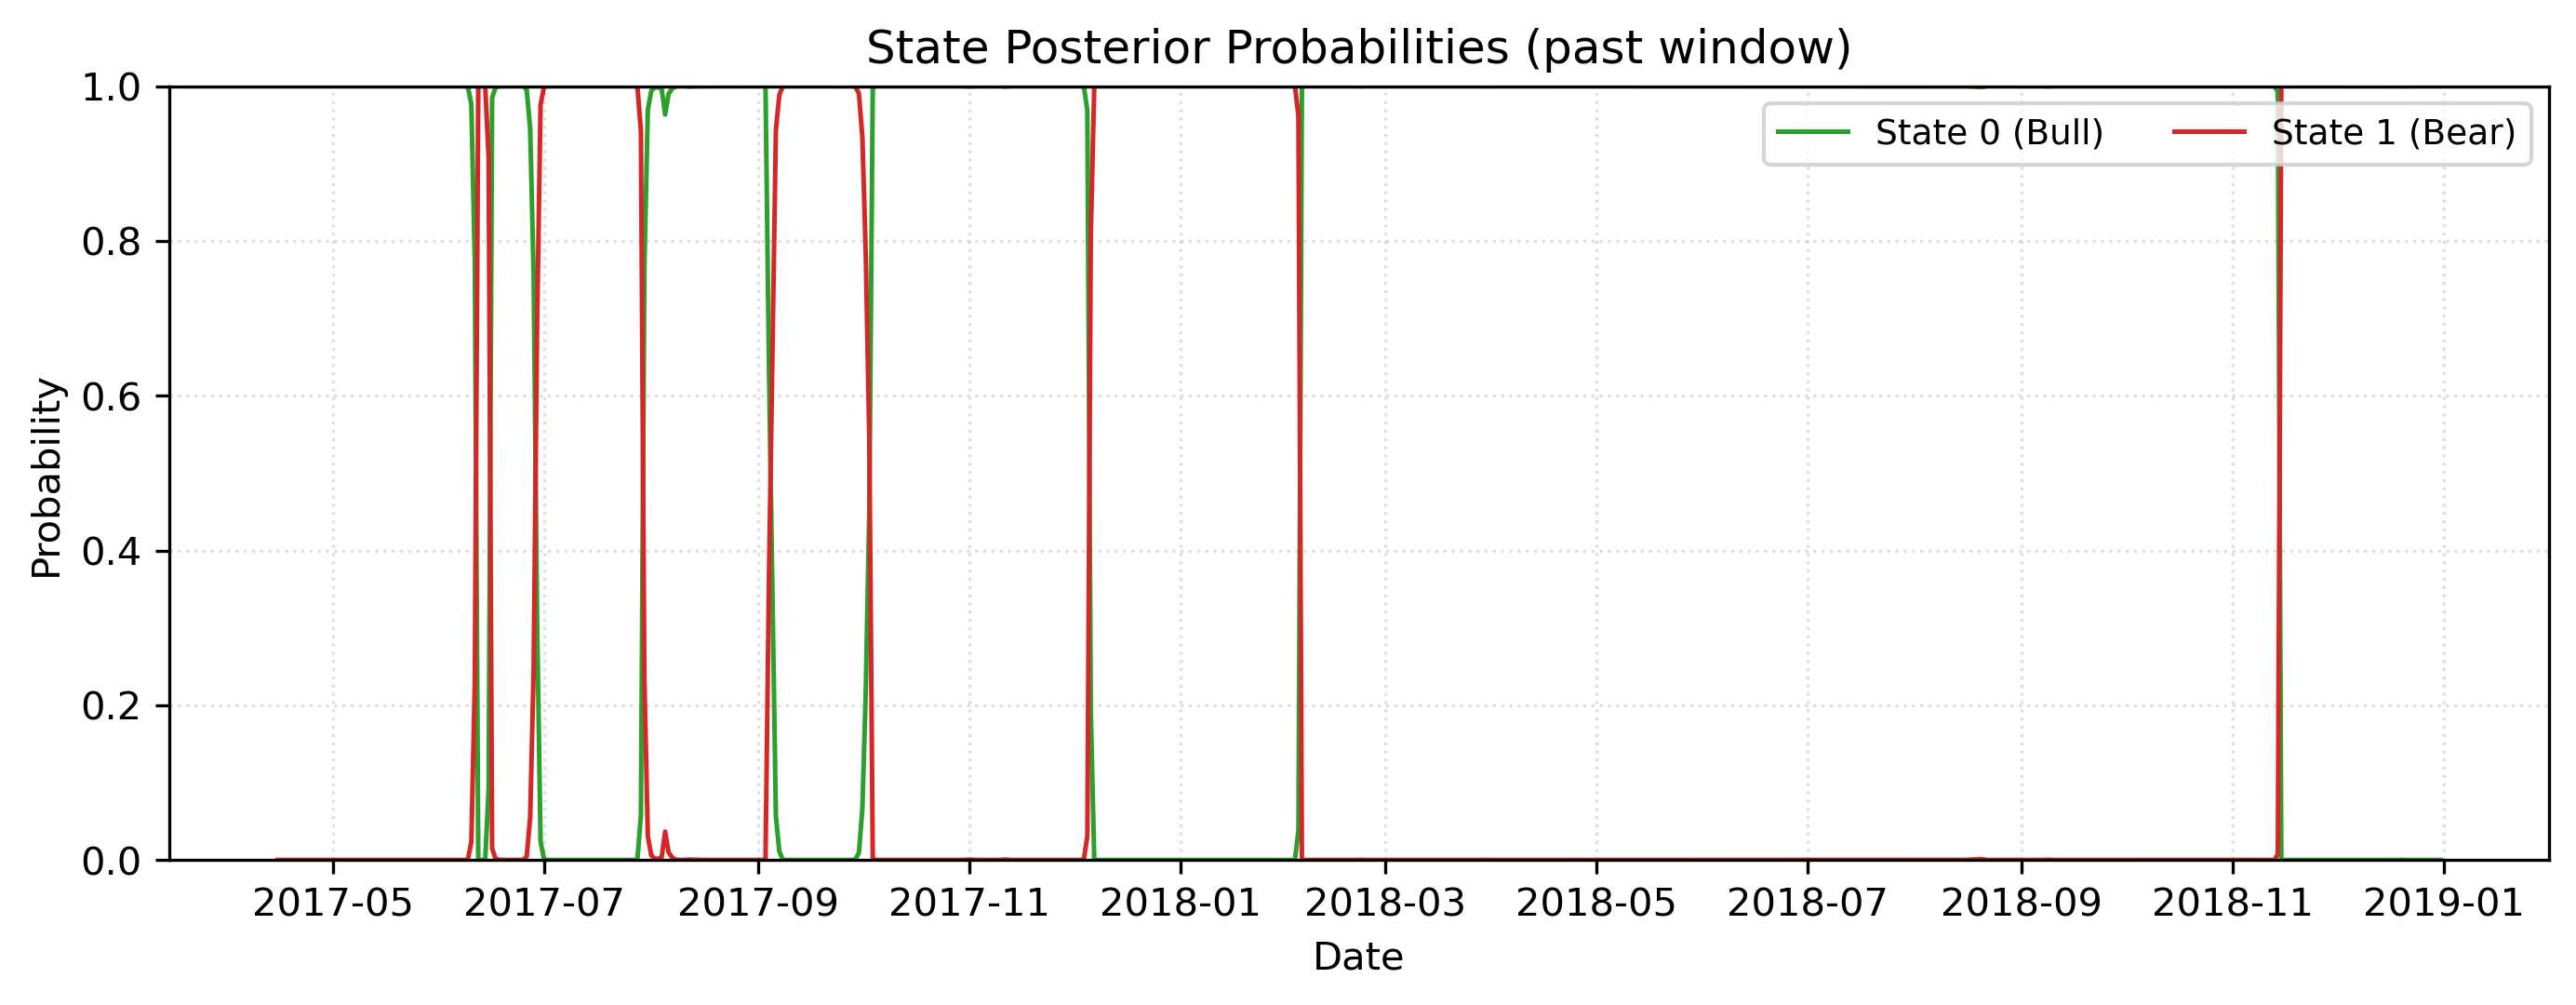

## State Posterior Probabilities (past window)
- The Bull (green) and Bear (red) probabilities jump from ~0 to ~1 and **stay saturated** for long stretches.  
- Spikes appear **only near change-points**, which is typical when states are well separated.

**Pros:** clean, confident signals suitable for simple on/off gating.  
**Caveat:** near-deterministic posteriors may reflect **over-confidence** from Gaussian emissions on heavy-tailed data.  
If you want softer probabilities, consider a **Student-t HMM**, stronger covariance regularization, or adding a **Neutral** state.


### Figure: Transition matrix

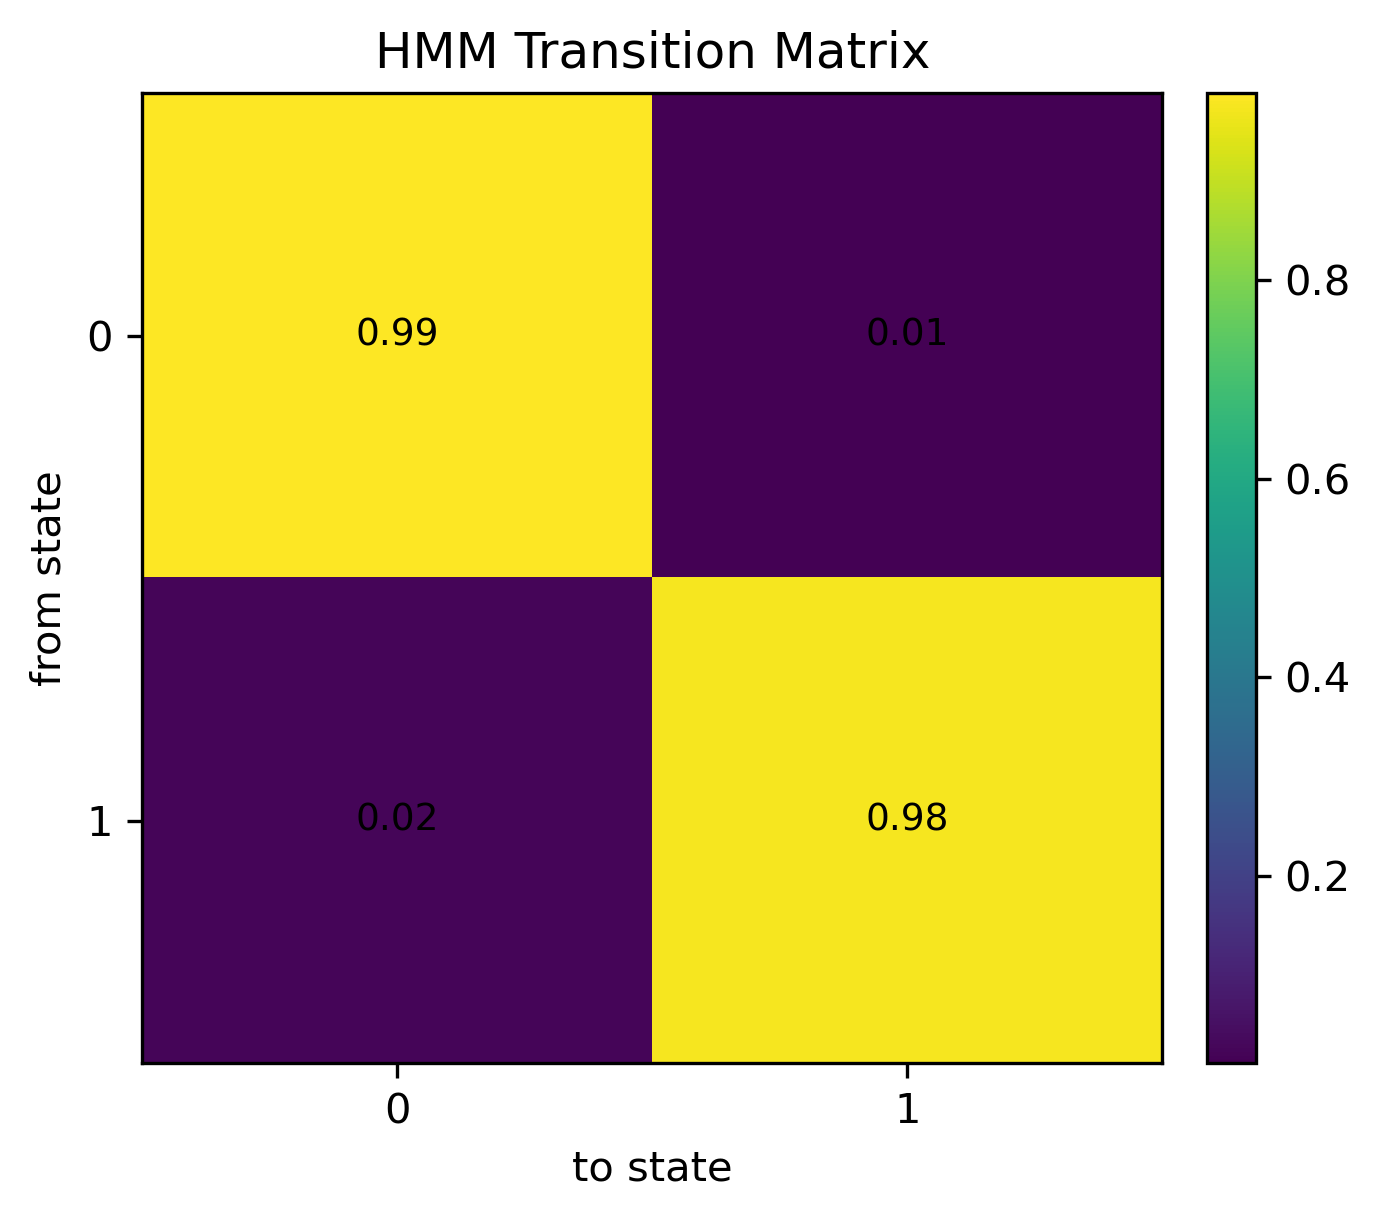

## HMM Transition Matrix
- The matrix is almost diagonal:  
  - Bull→Bull ≈ **0.99**, Bull→Bear ≈ **0.01**  
  - Bear→Bear ≈ **0.98**, Bear→Bull ≈ **0.02**
- Expected state duration:
$
  \mathbb{E}[T_i] = \frac{1}{1 - p_{ii}}
$
  - Bull: $(1/(1-0.99) \approx \mathbf{100}$ days  
  - Bear: $(1/(1-0.98) \approx \mathbf{50}$ days

**Implication:** Strong **persistence**—exactly what you want from a regime filter.


### Figure: Mean daily return by state

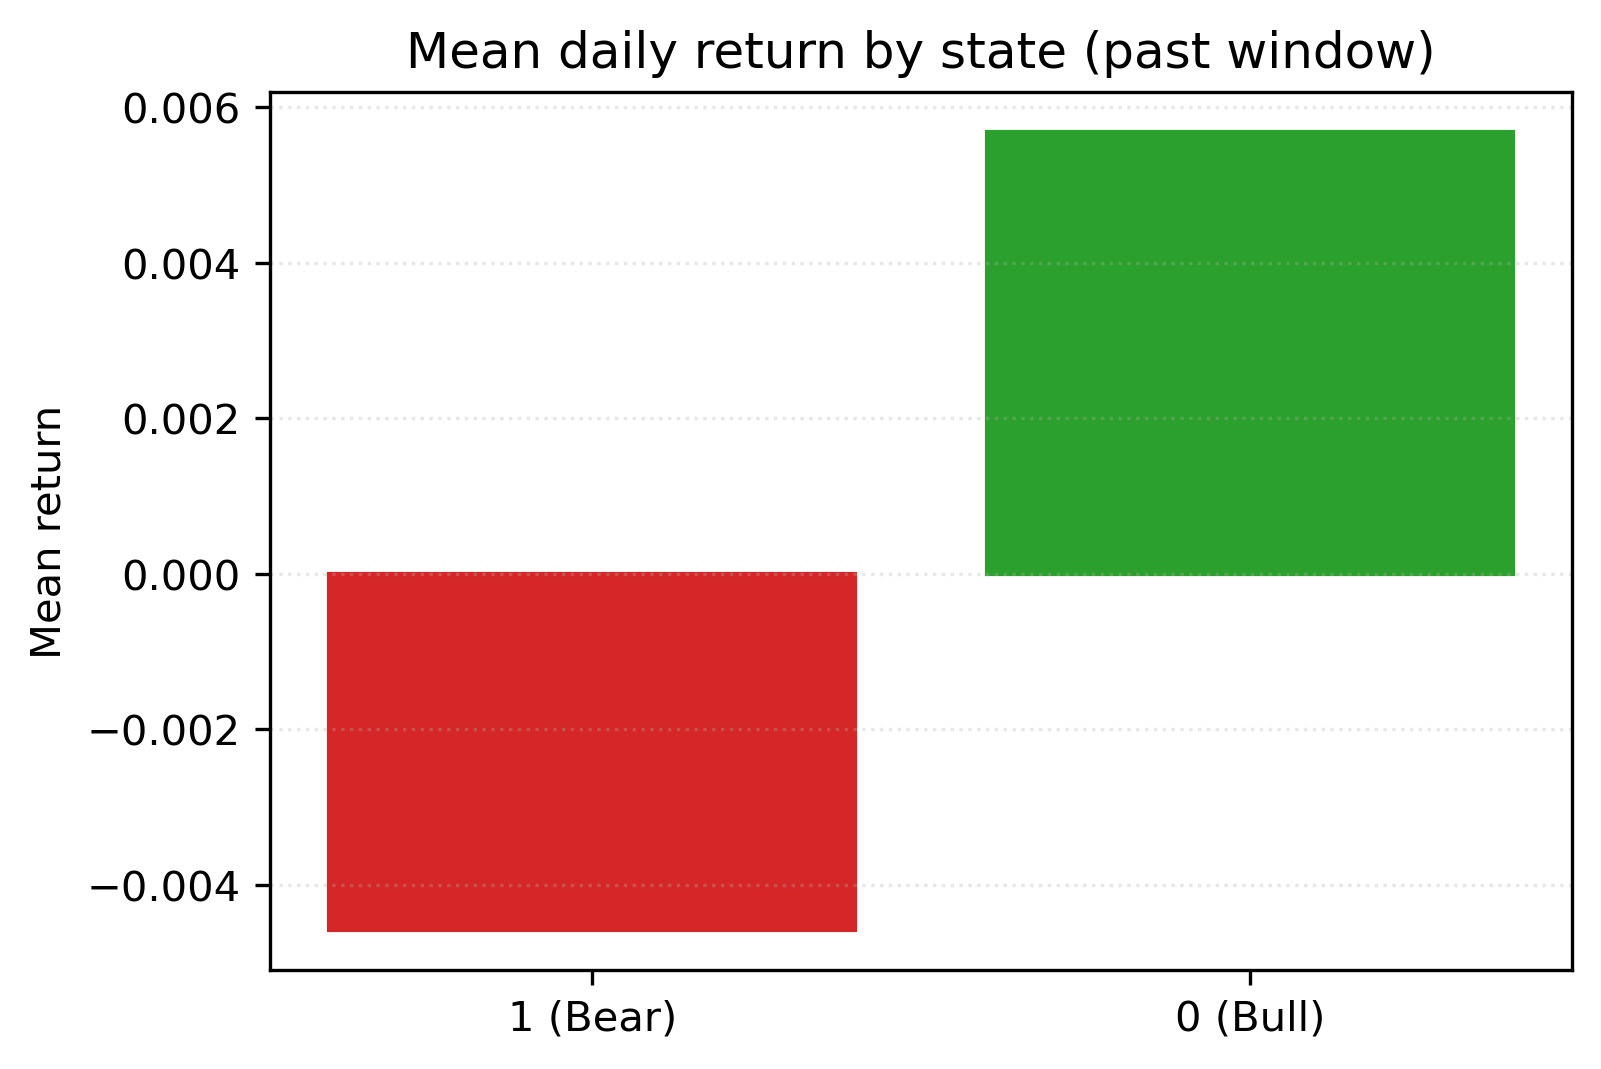

# Mean Daily Return by State
- **Bull** state shows a **positive** mean daily return (≈ **+0.5–0.6%/day** in this window).  
- **Bear** state shows a **negative** mean daily return (≈ **−0.4–0.5%/day**).

**Interpretation:** Mapping states by mean return (low→Bear, high→Bull) works and is economically meaningful.


# **Assets:** BTC

**Daily returns**
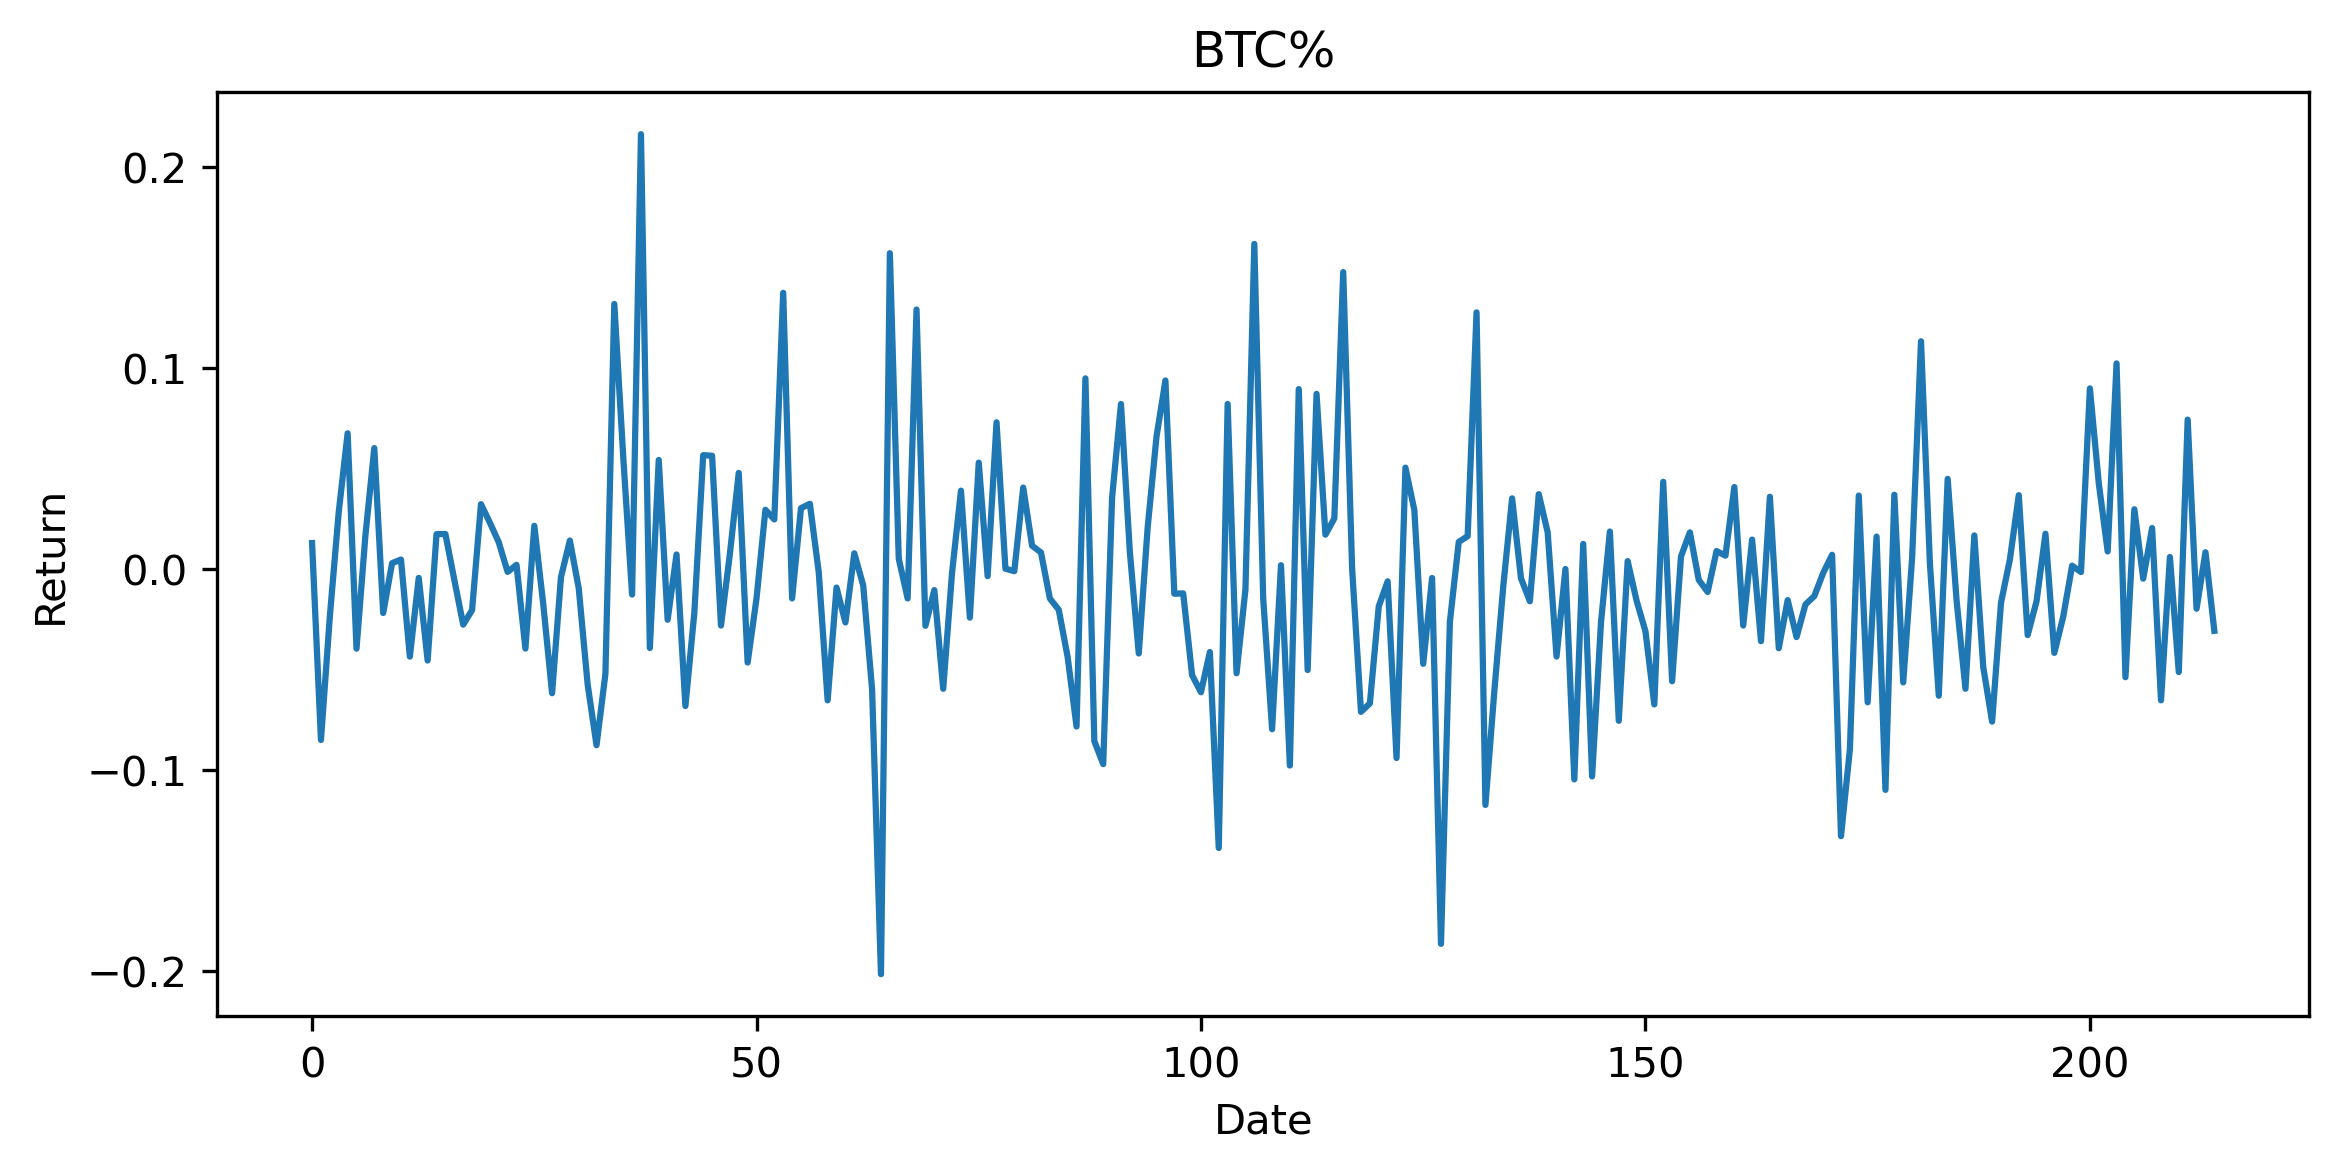

**ACF of return**
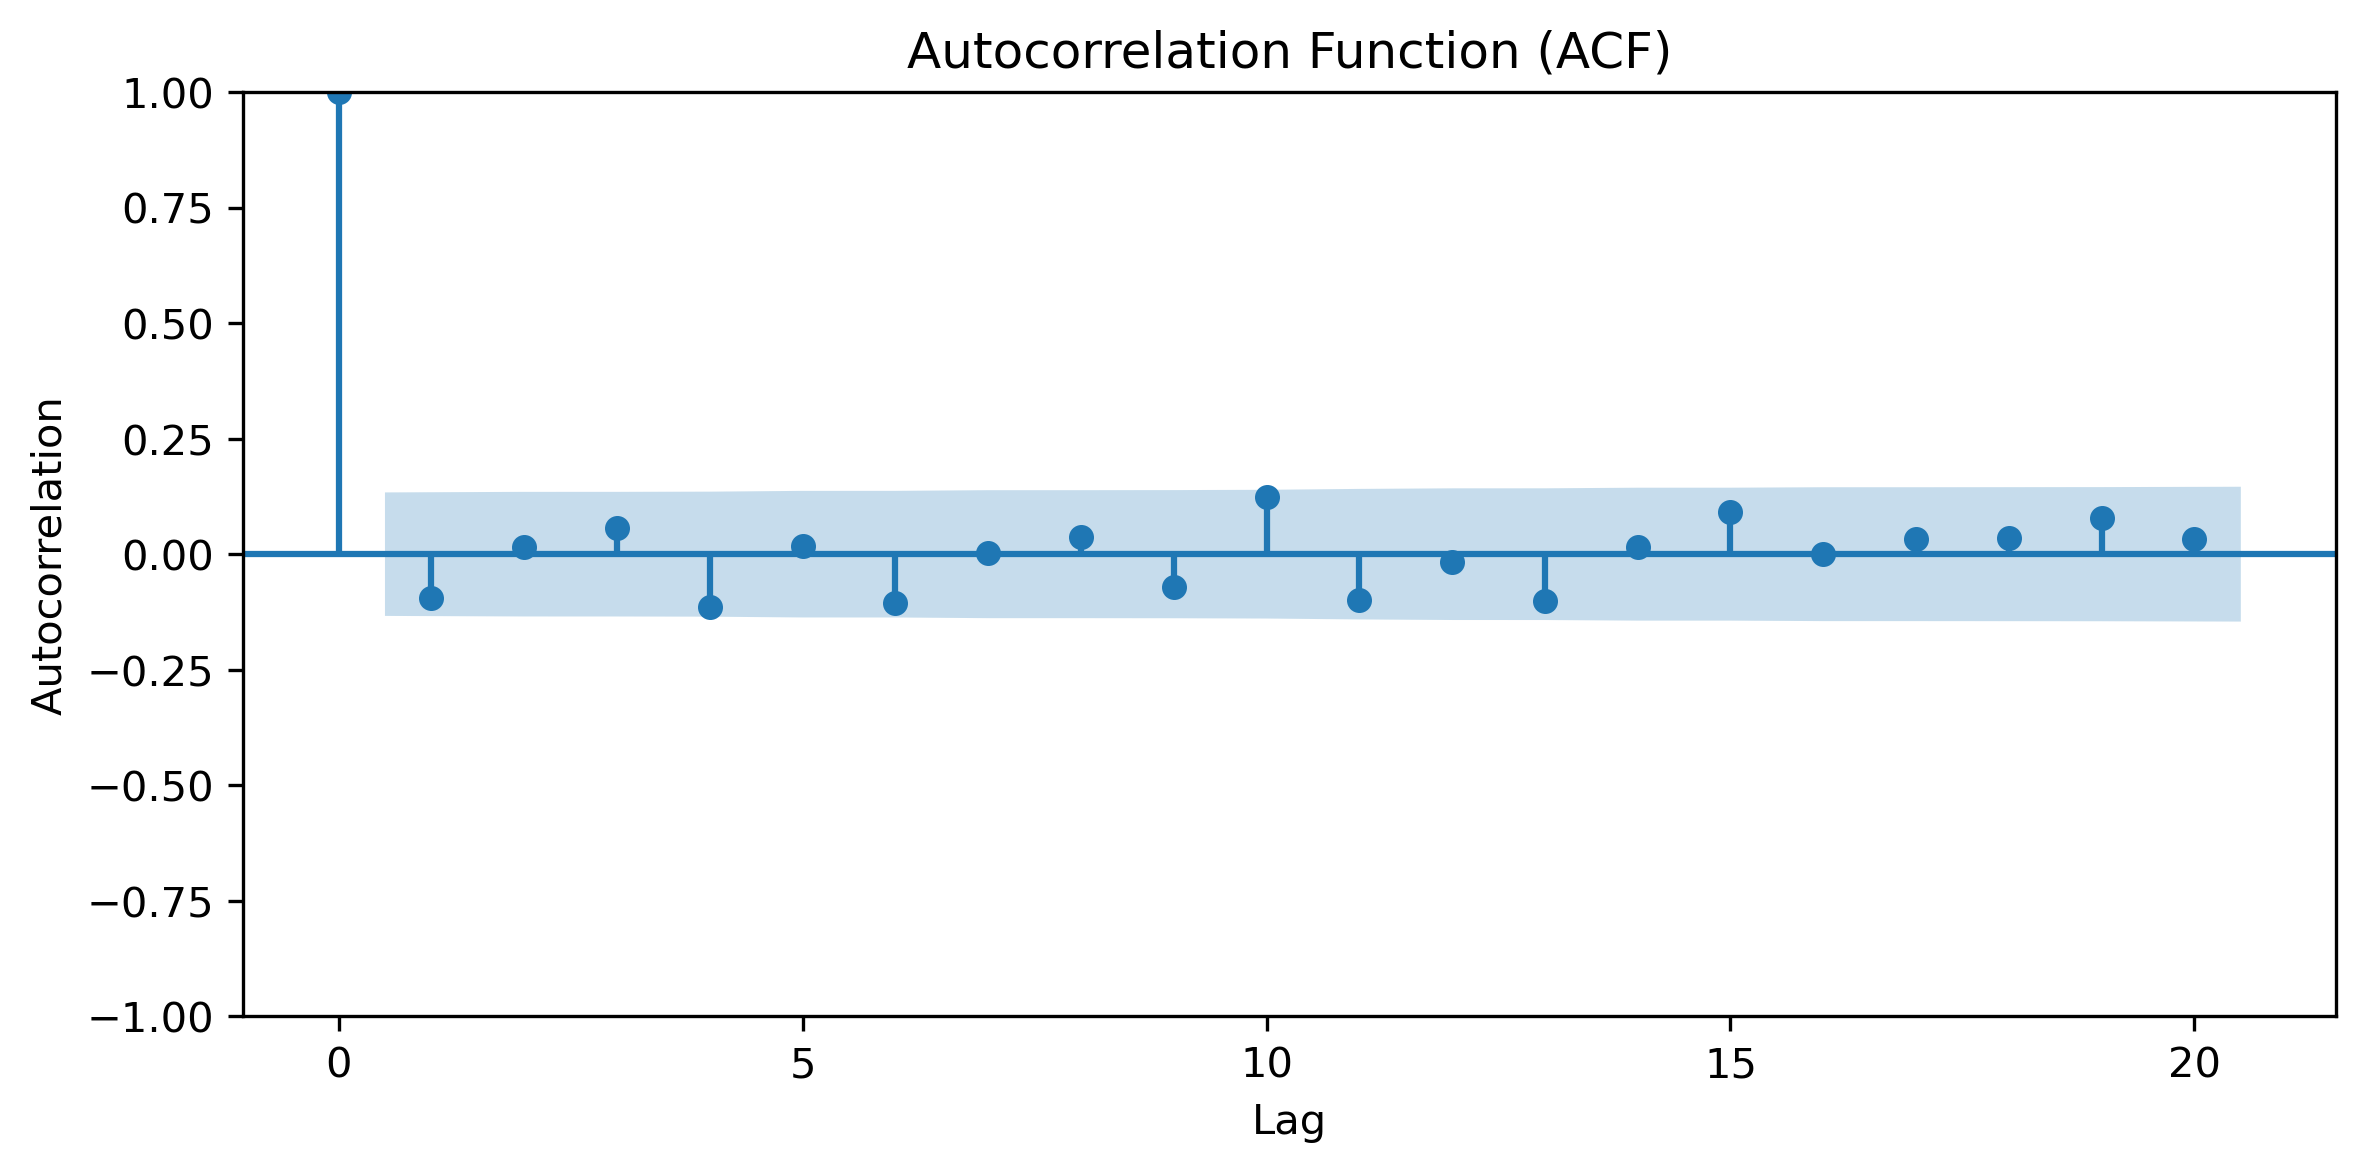

**Partial Autocorrelation Function (PACF) of return**
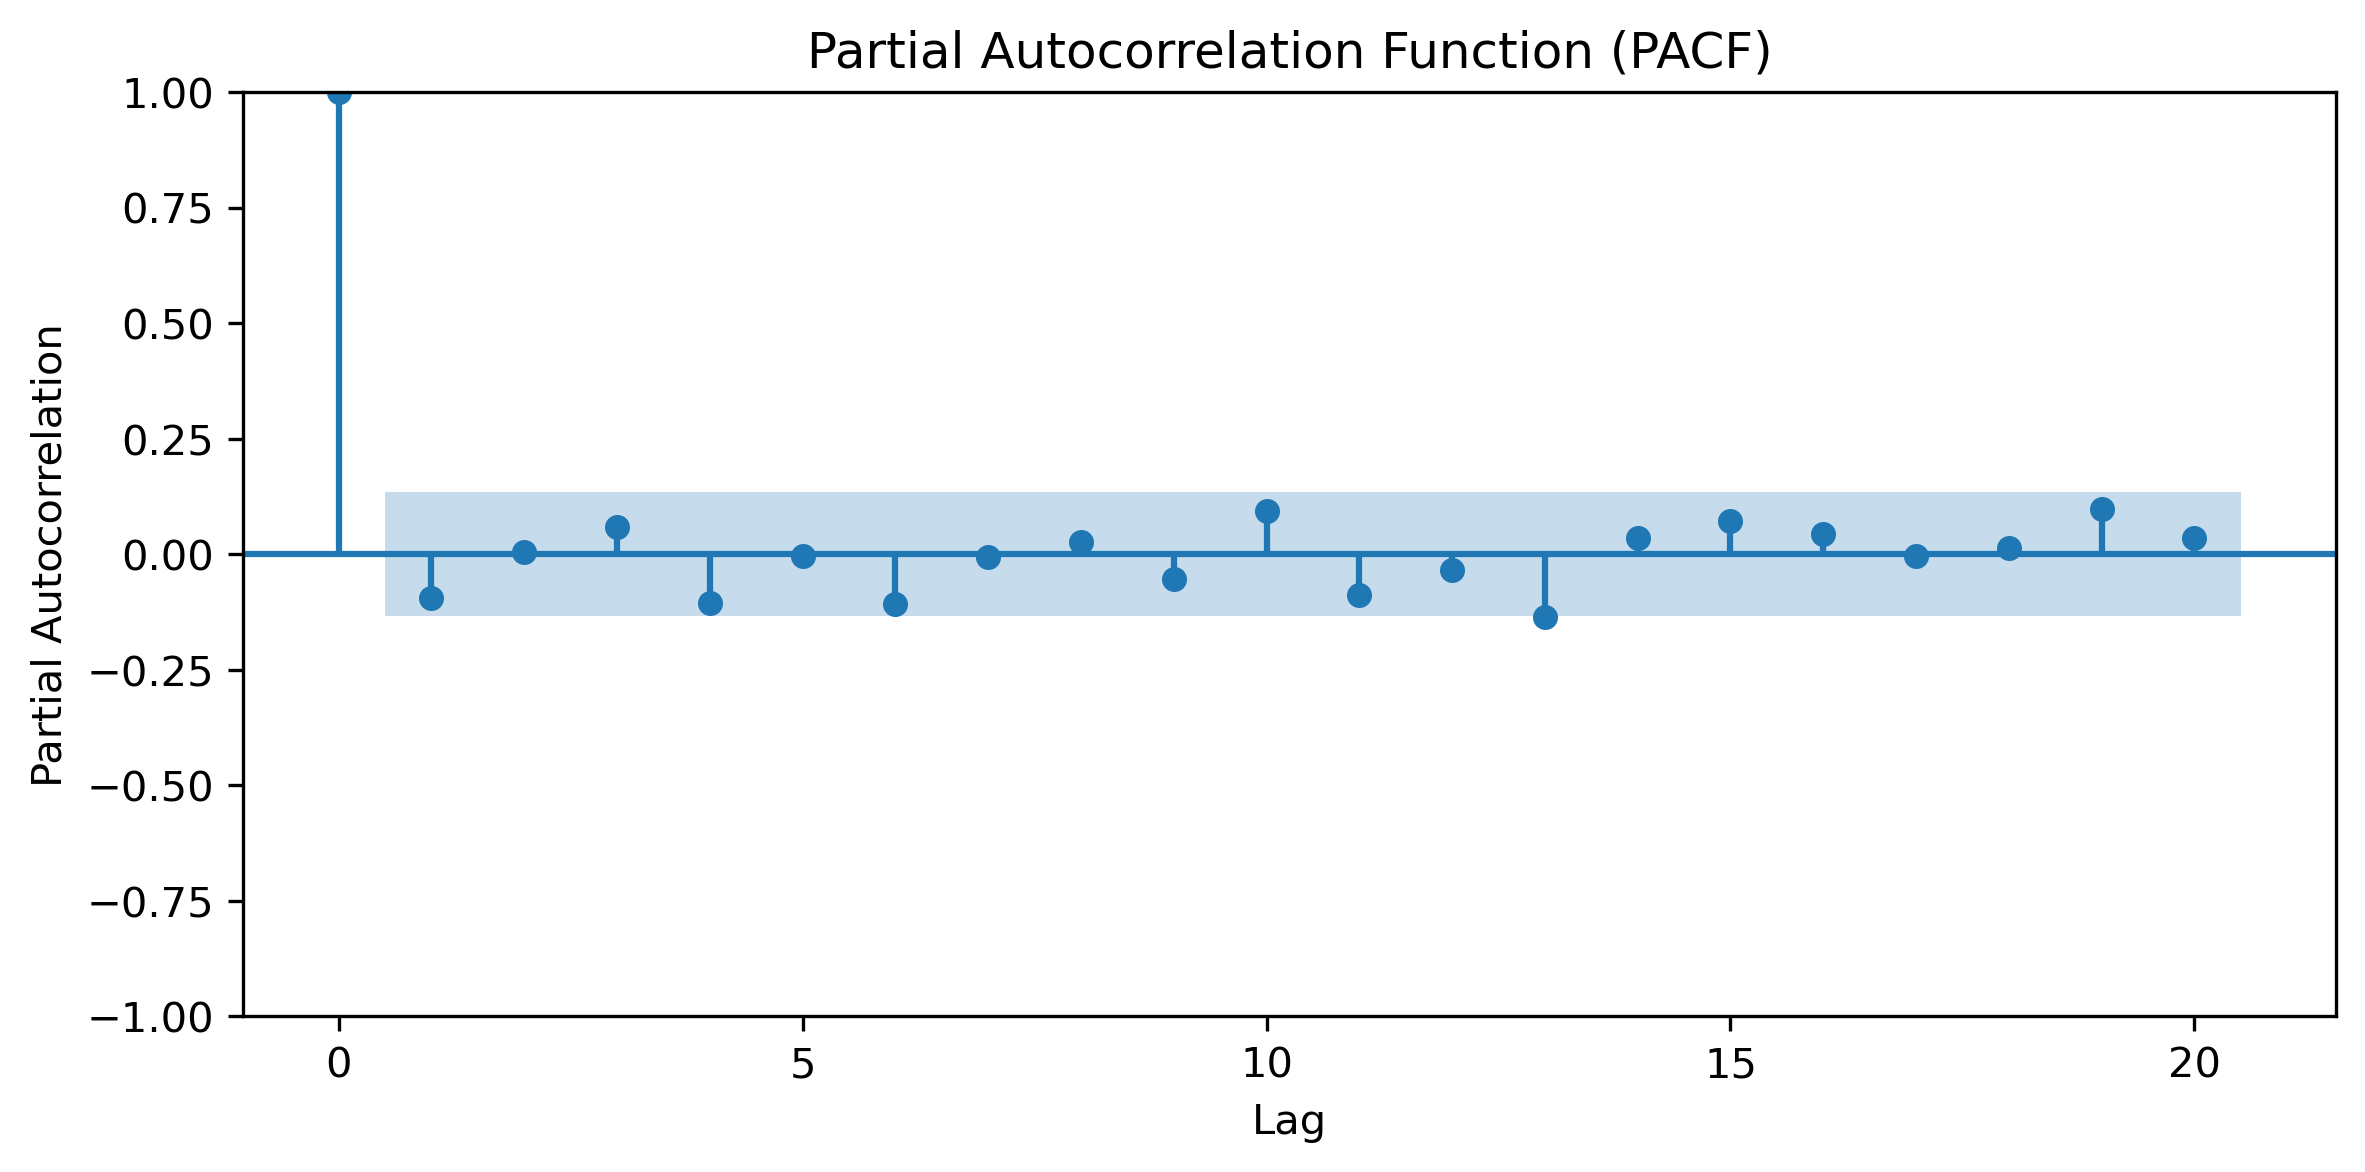

**Estimated conditional volatility ($σ_t$) — GJR‑GARCH**
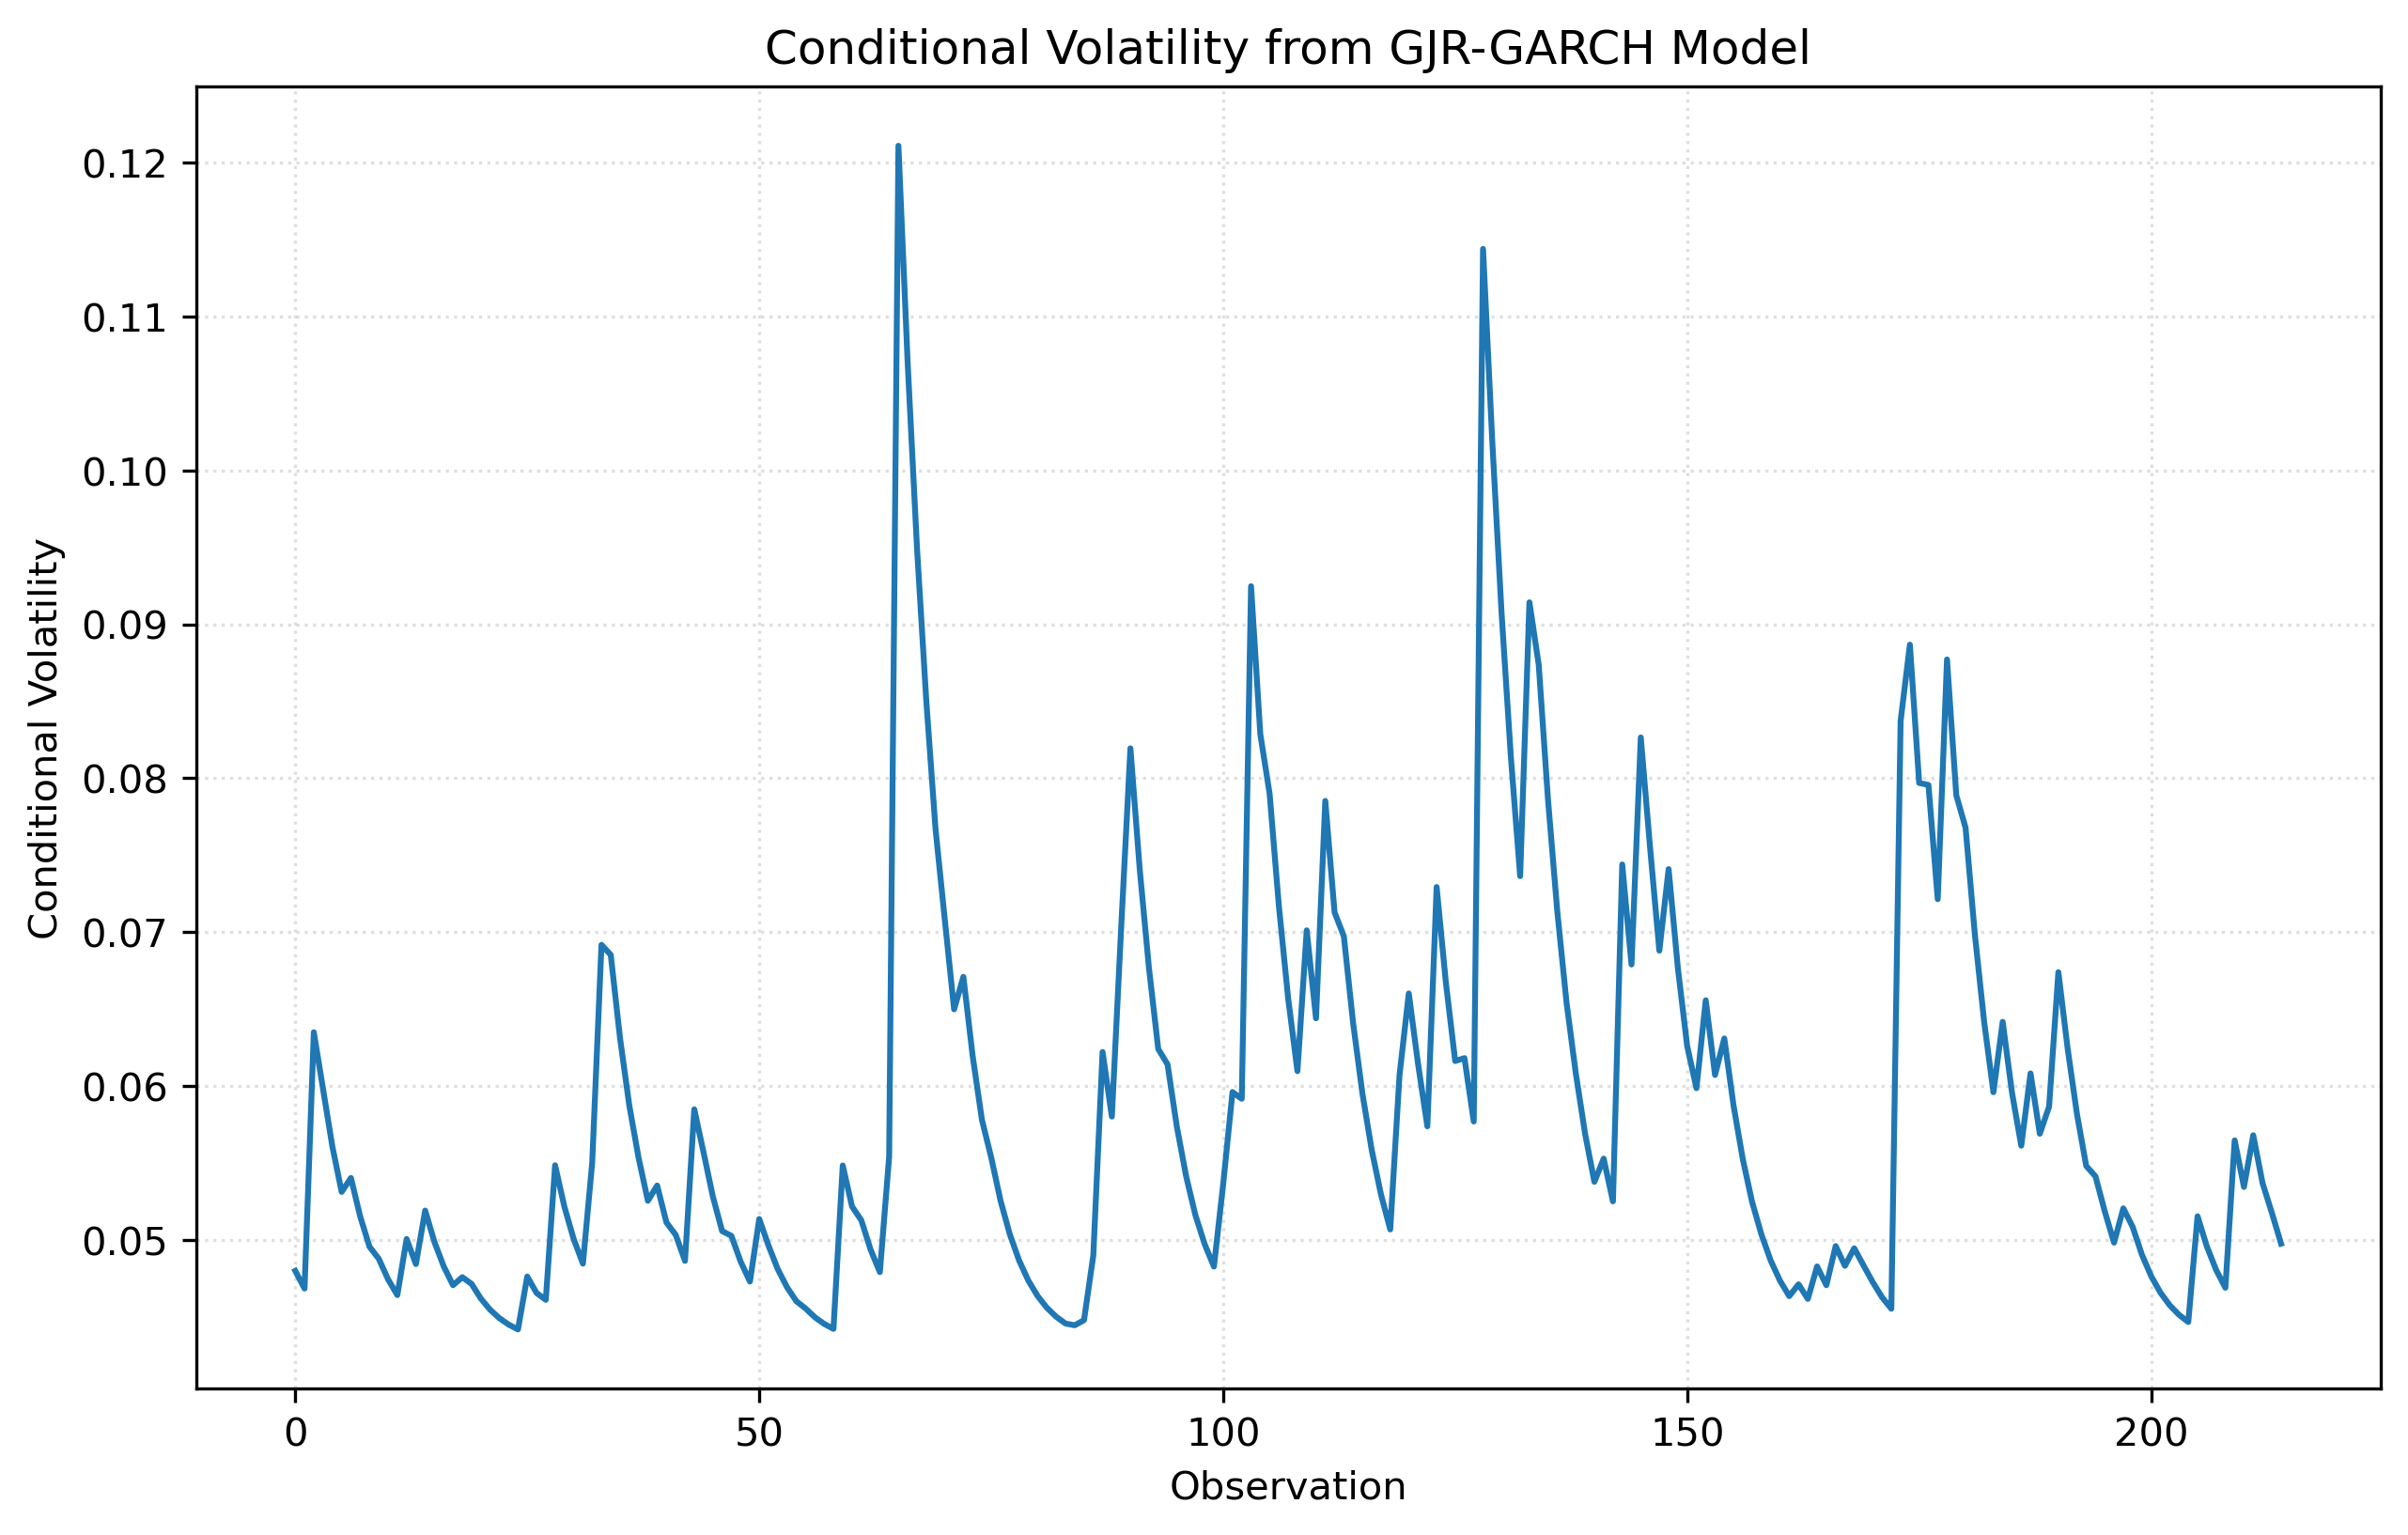

**Histogram of standardized residuals from the volatility model**
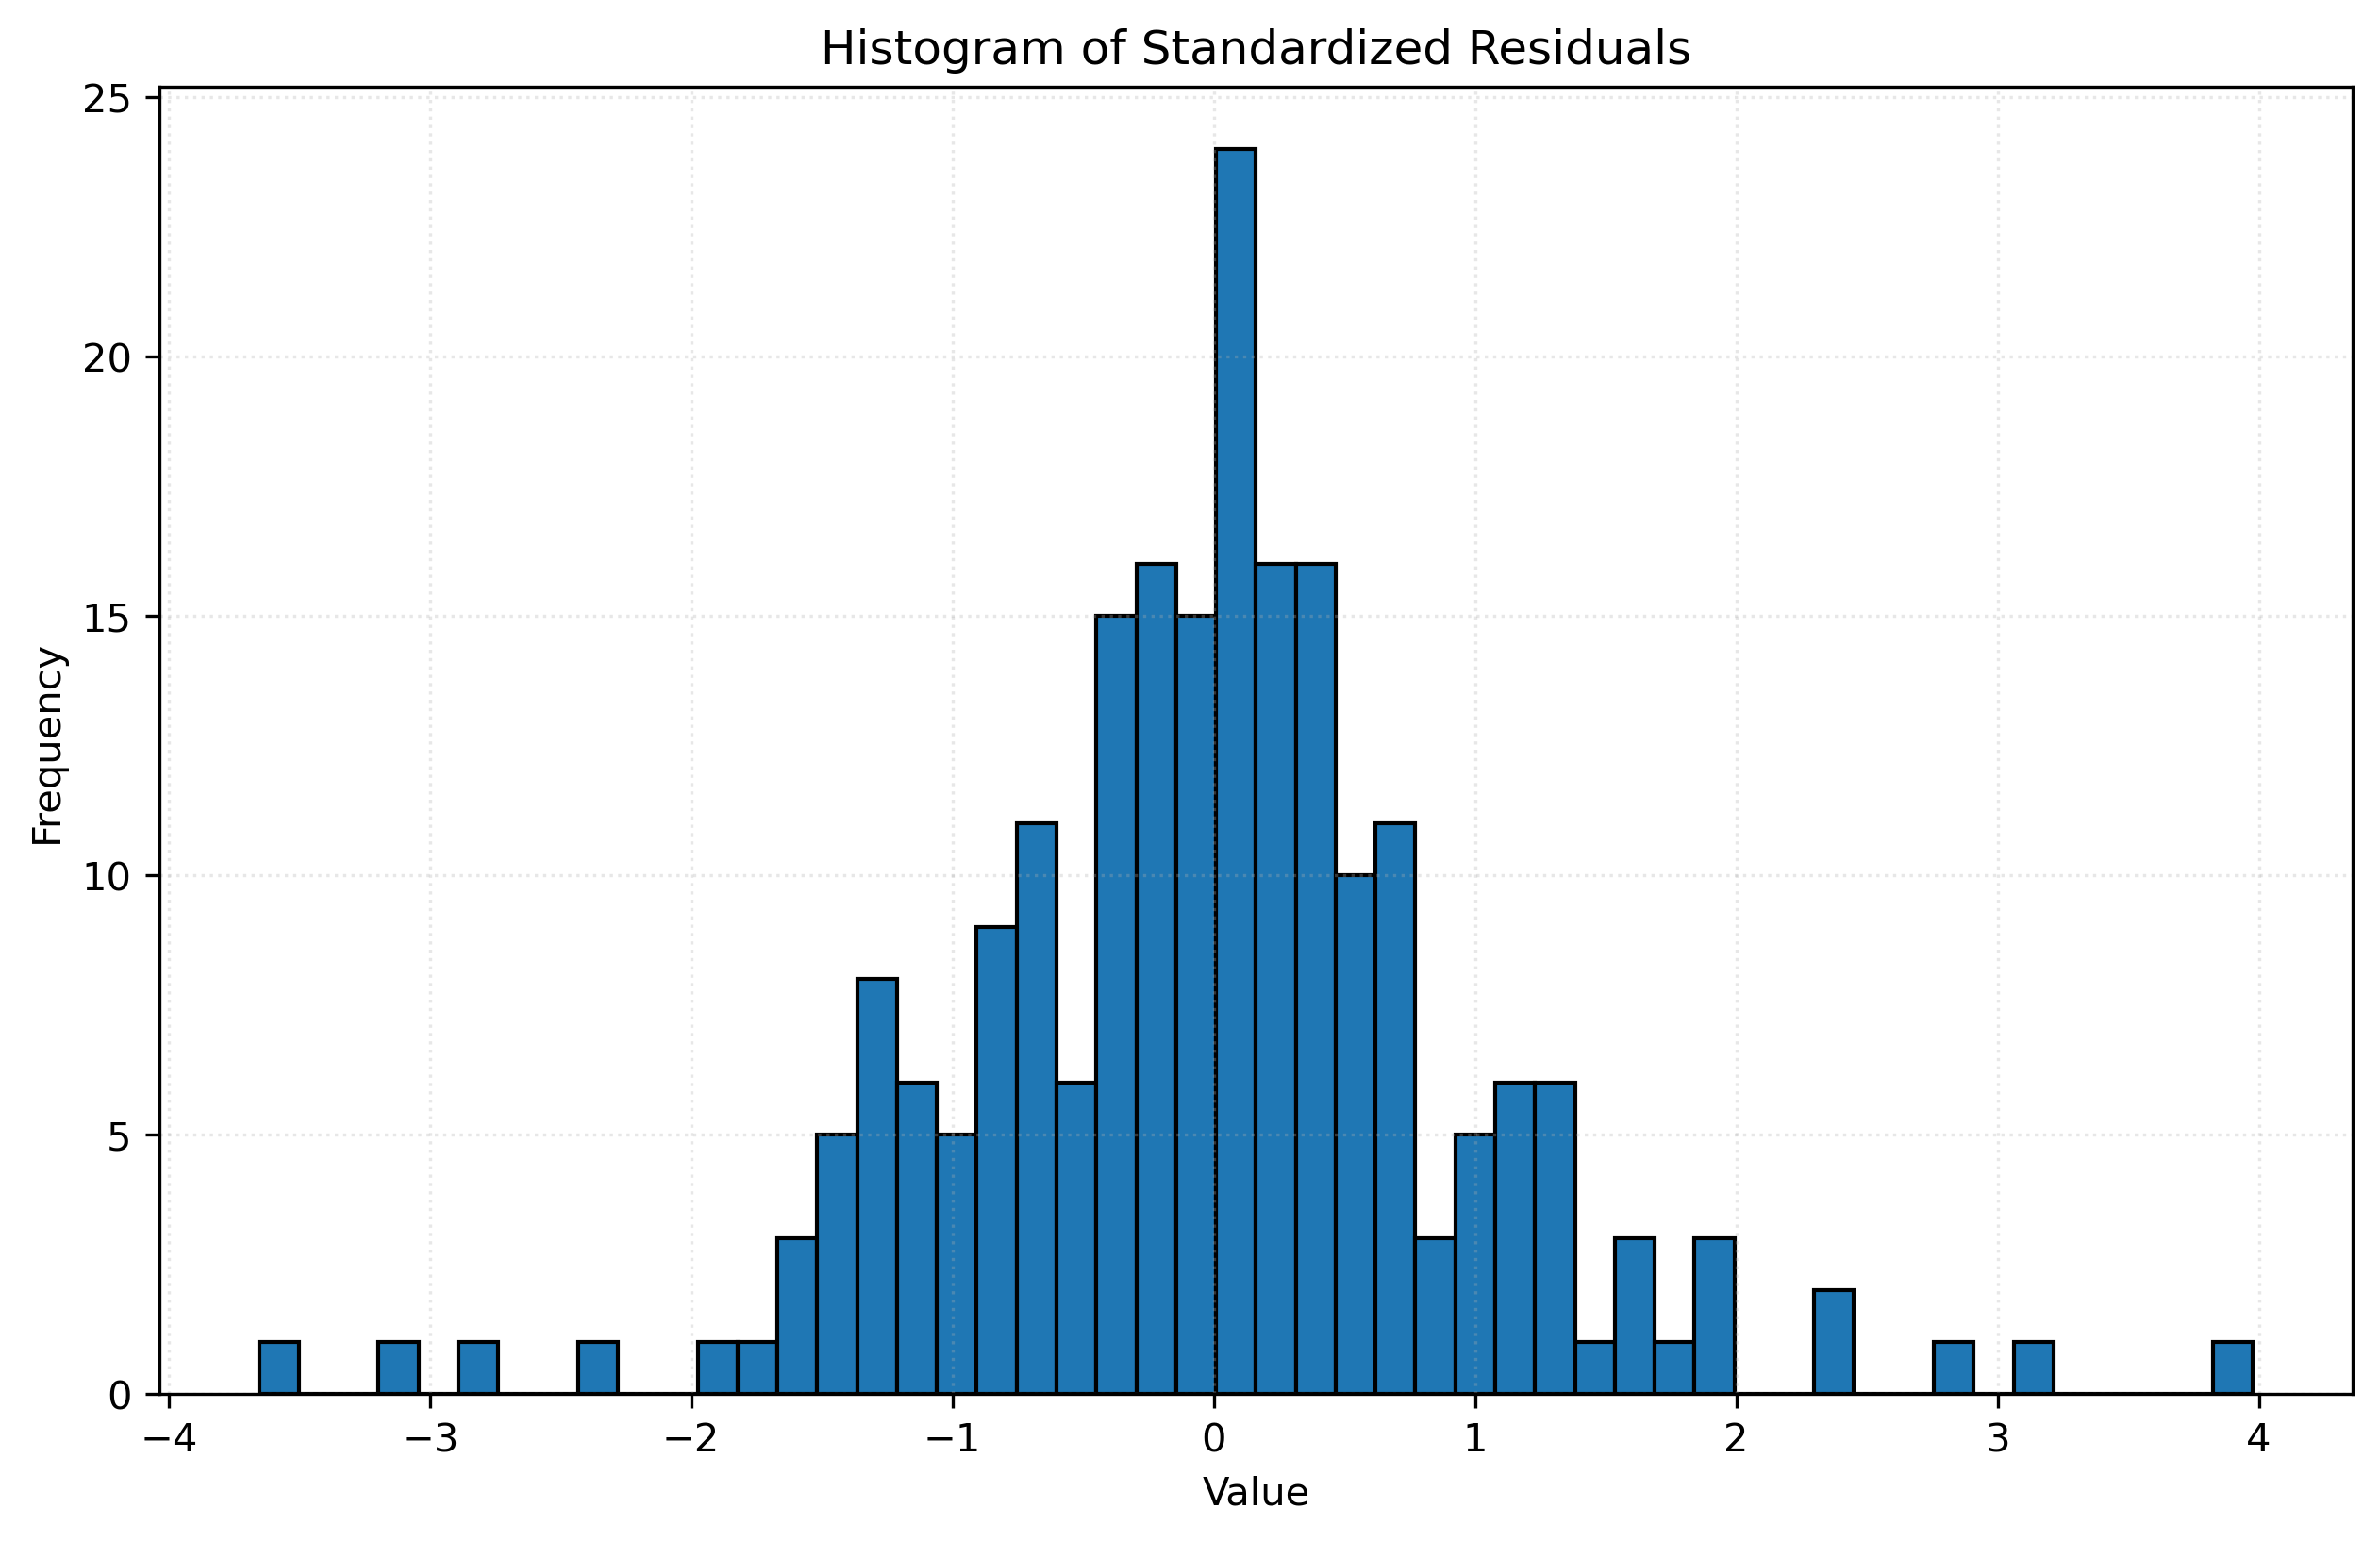

# **Assets:** ETH

**Daily returns**

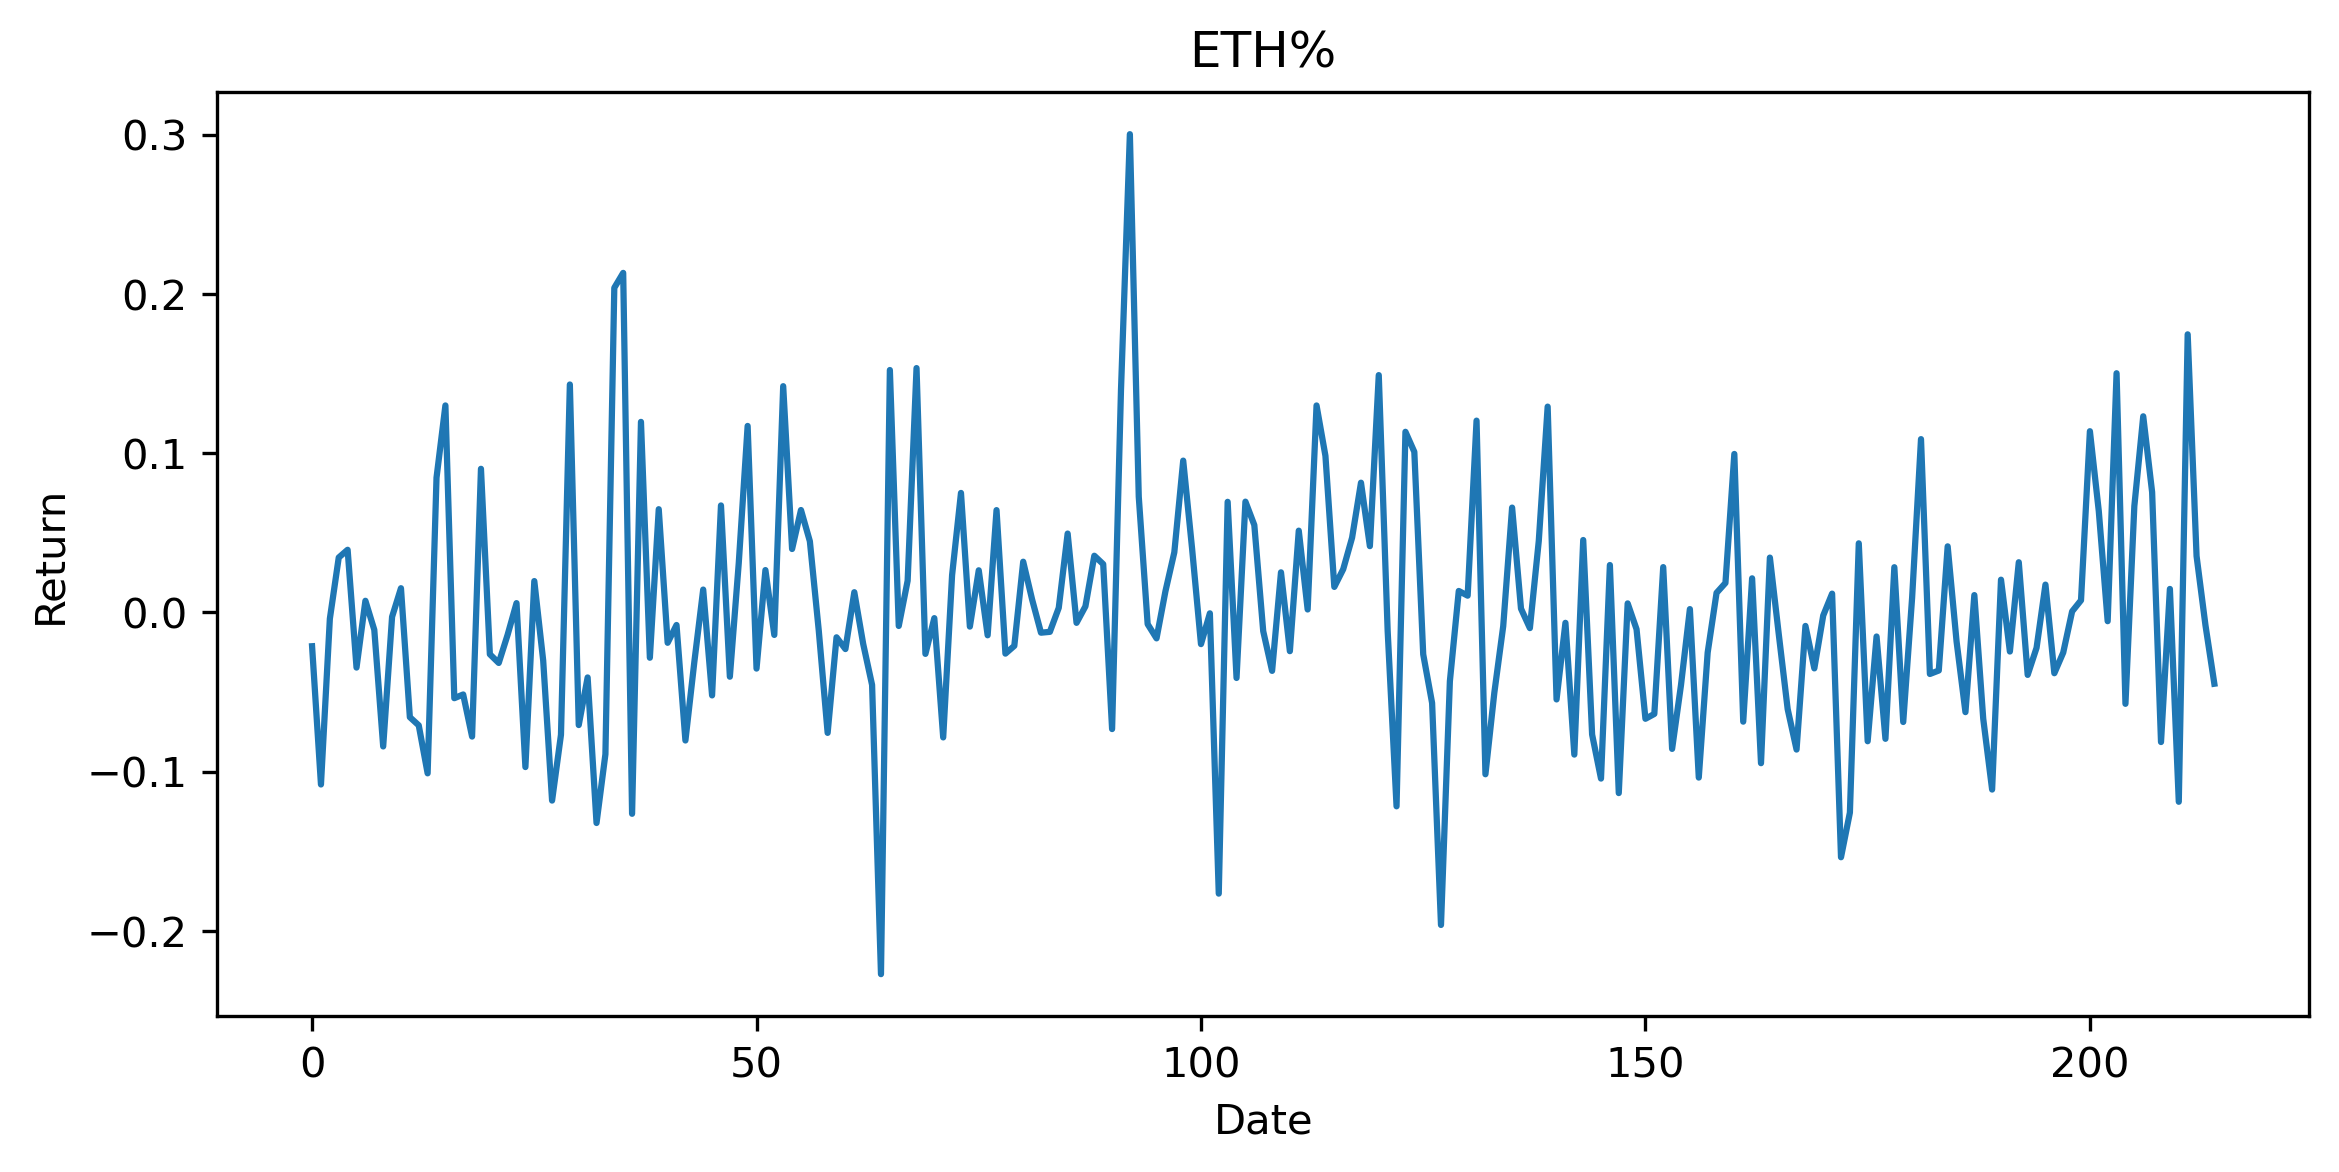

**ACF of return**
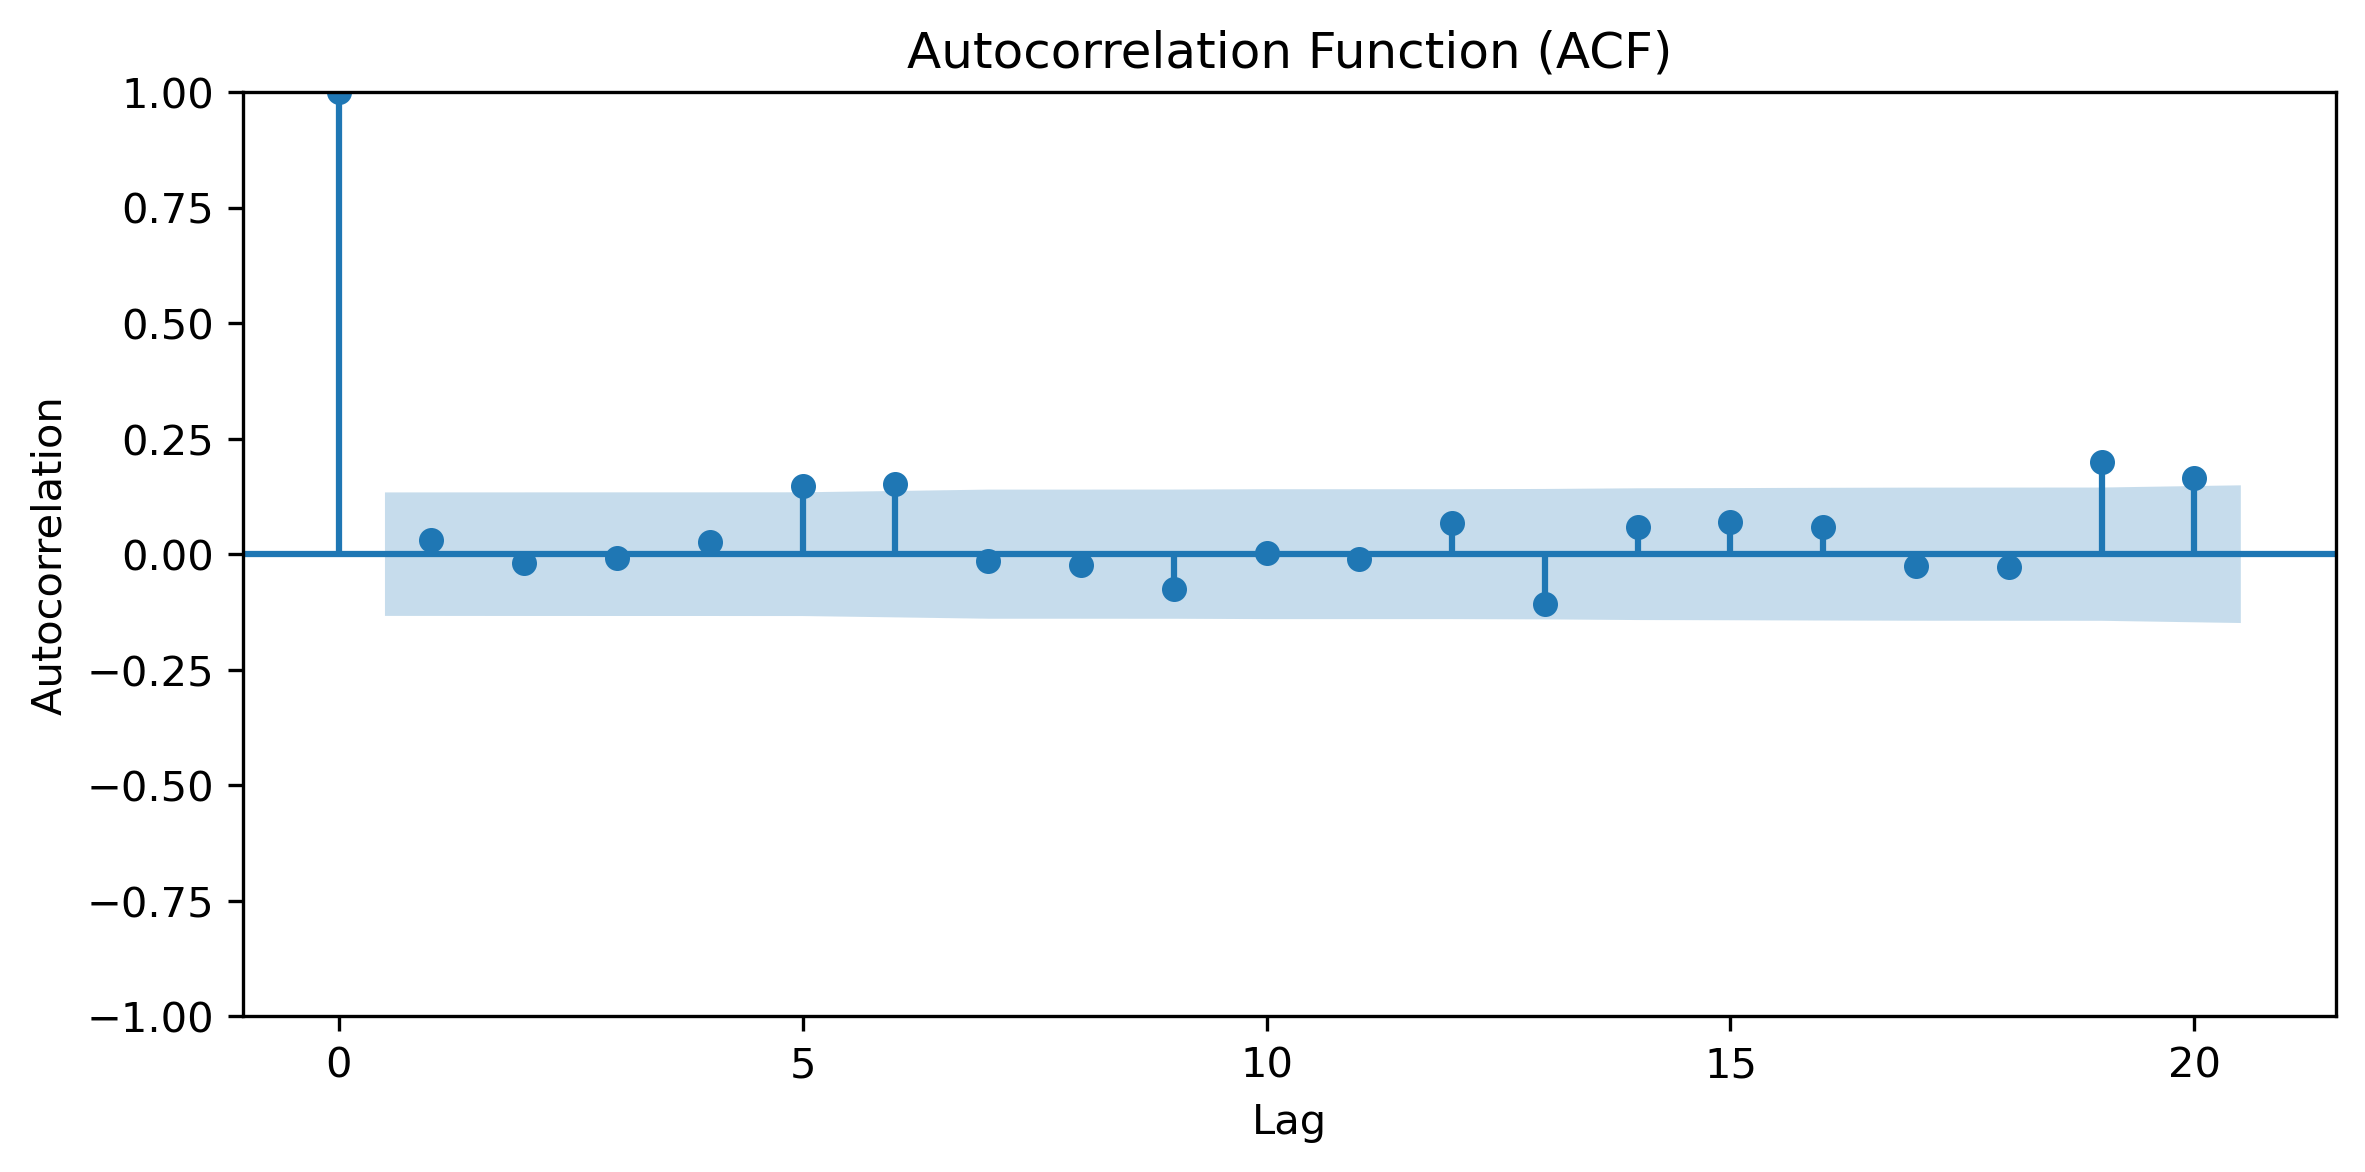

**Partial Autocorrelation Function (PACF) of return**
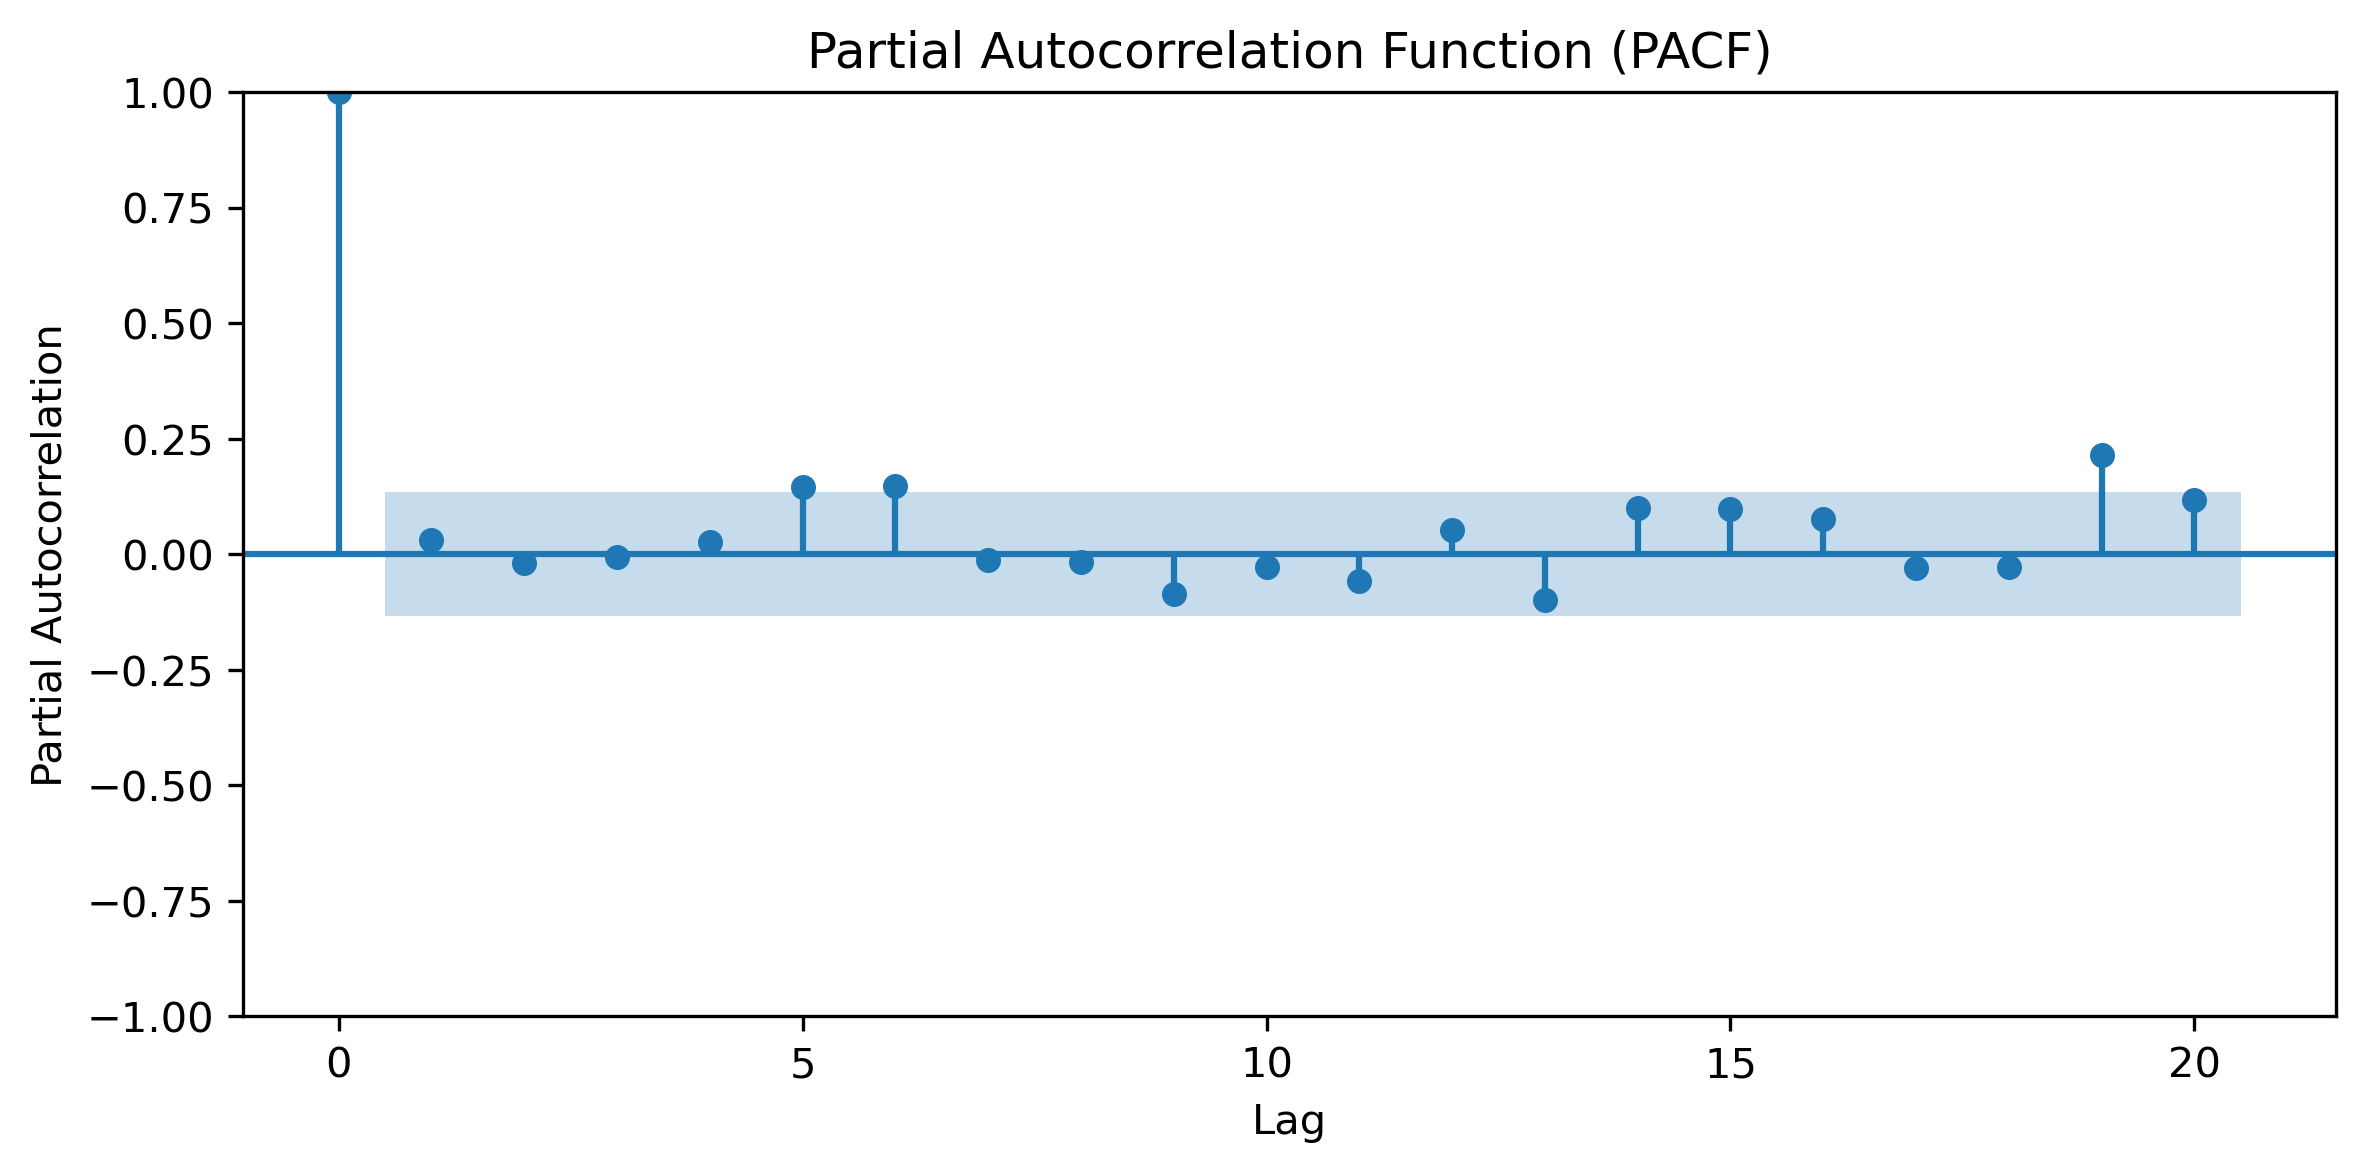

**Estimated conditional volatility ($σ_t$) — GJR‑GARCH**
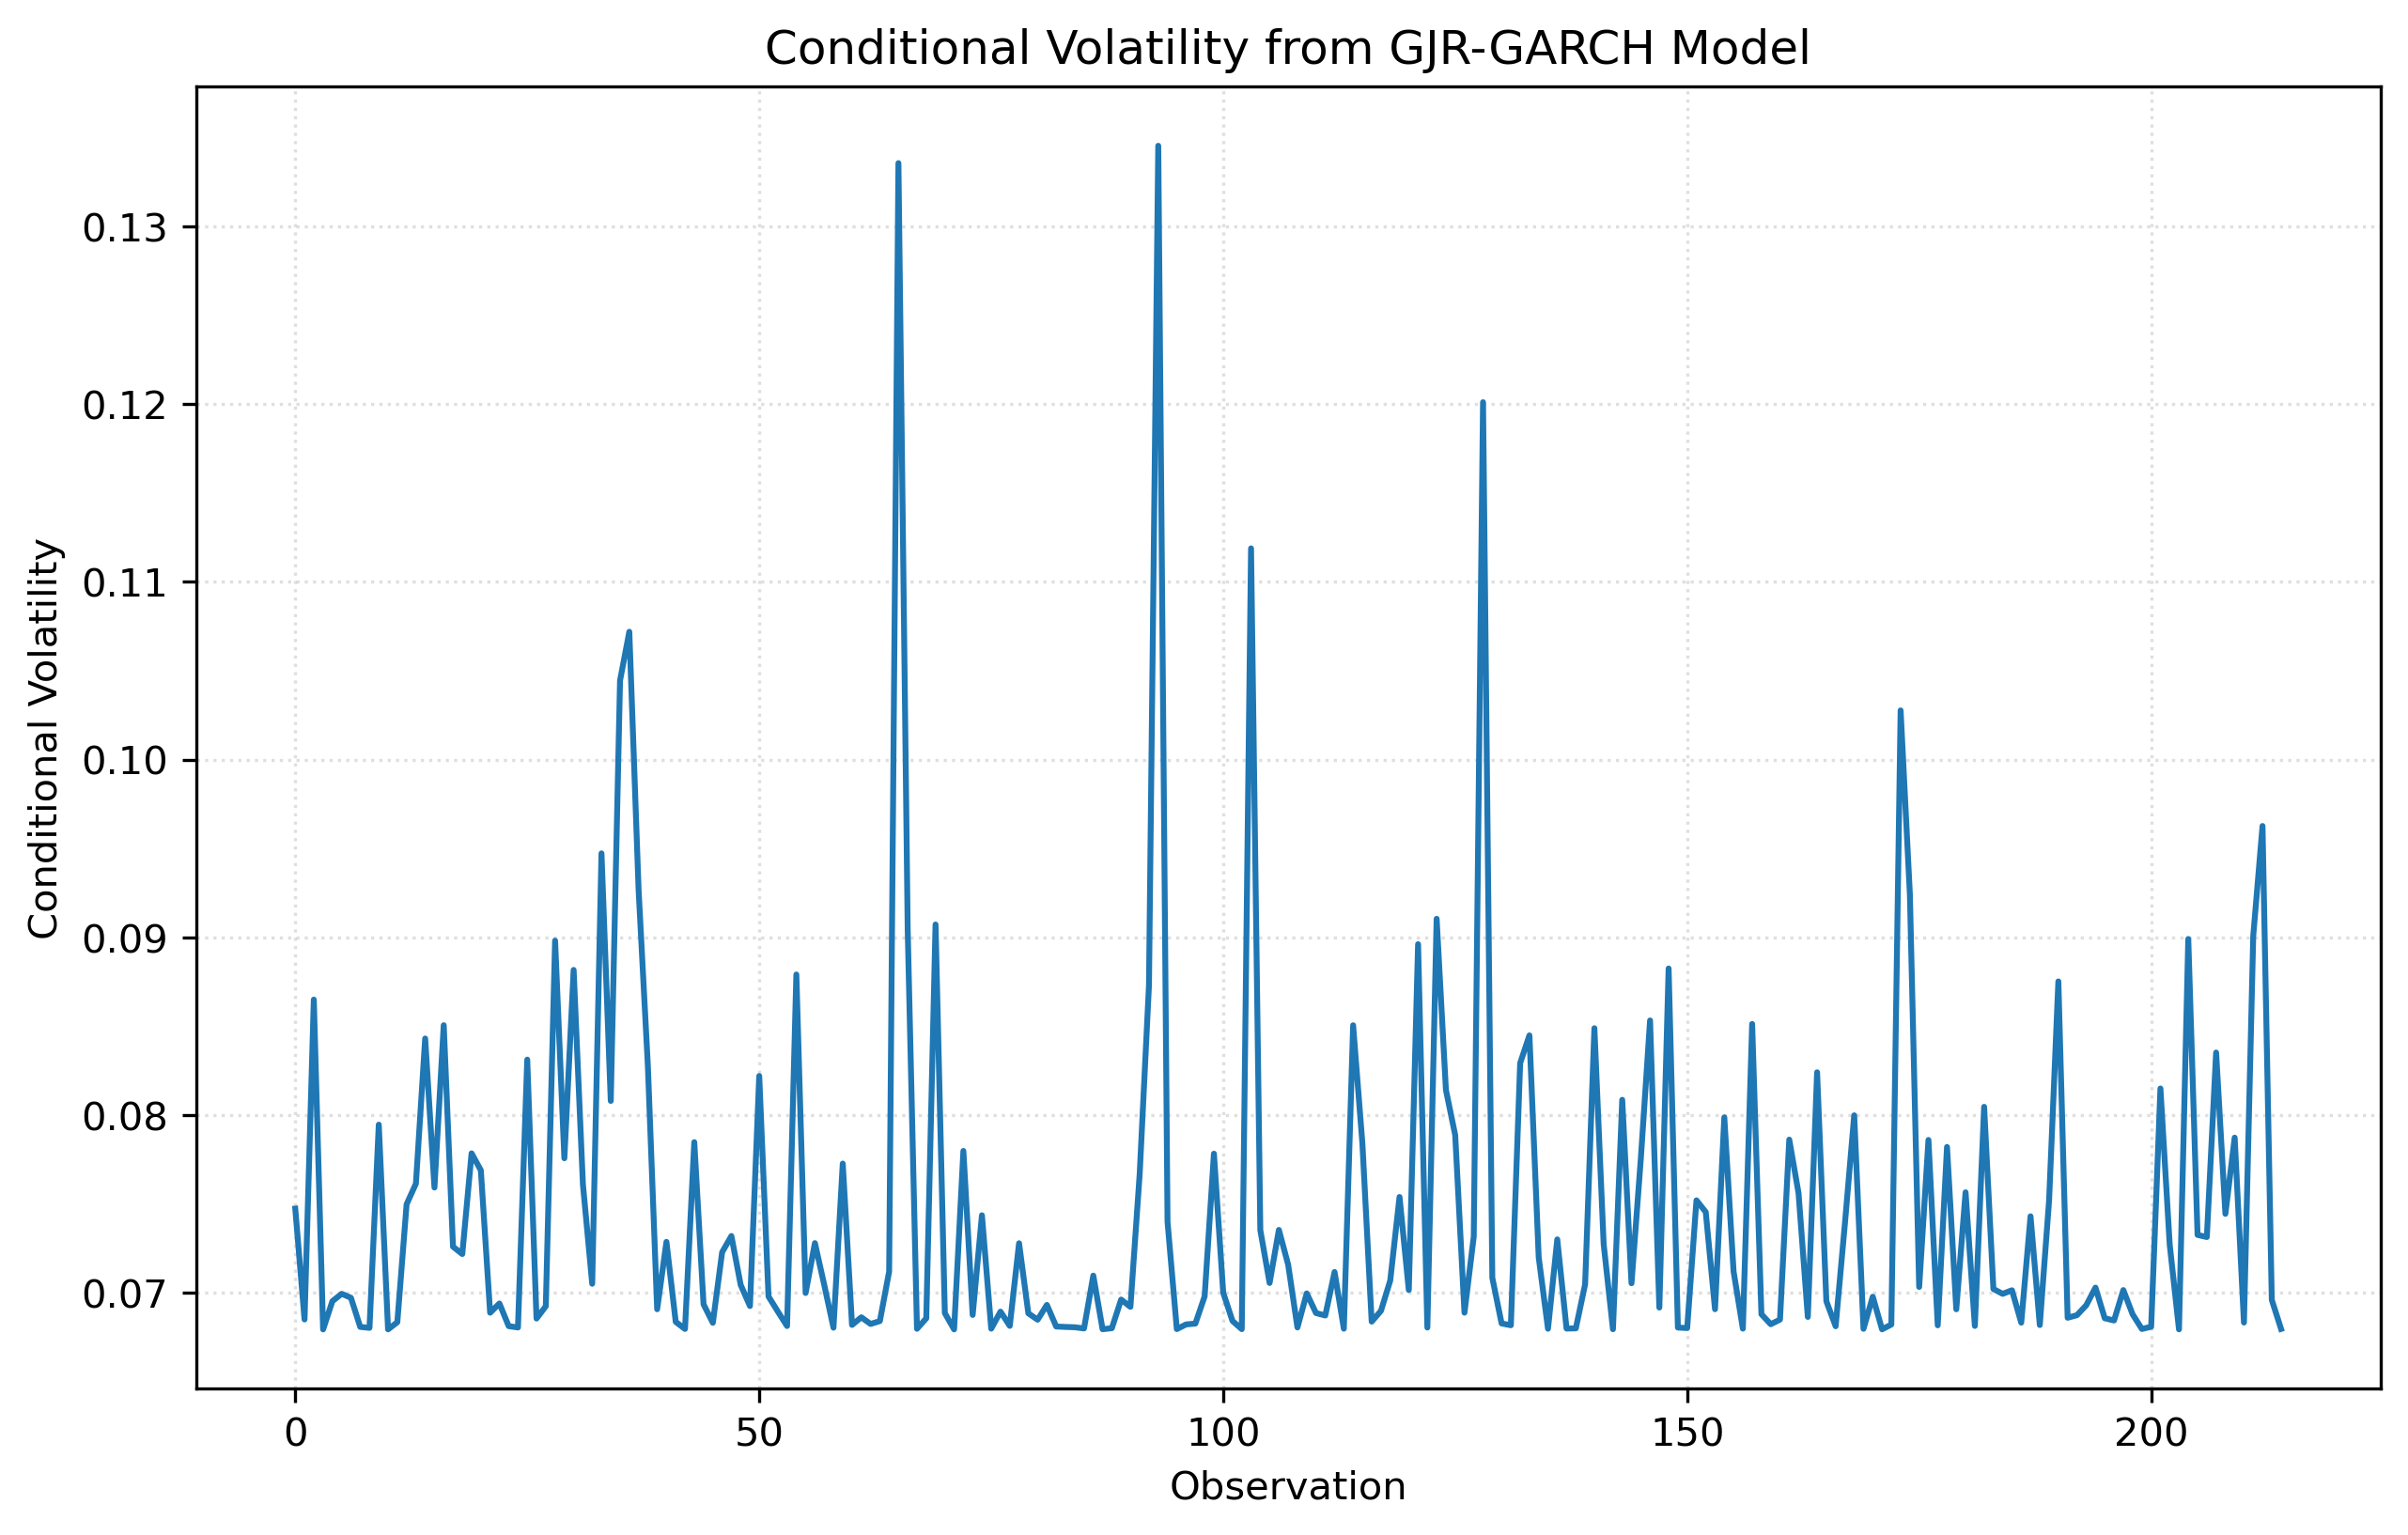

**Histogram of standardized residuals from the volatility model**
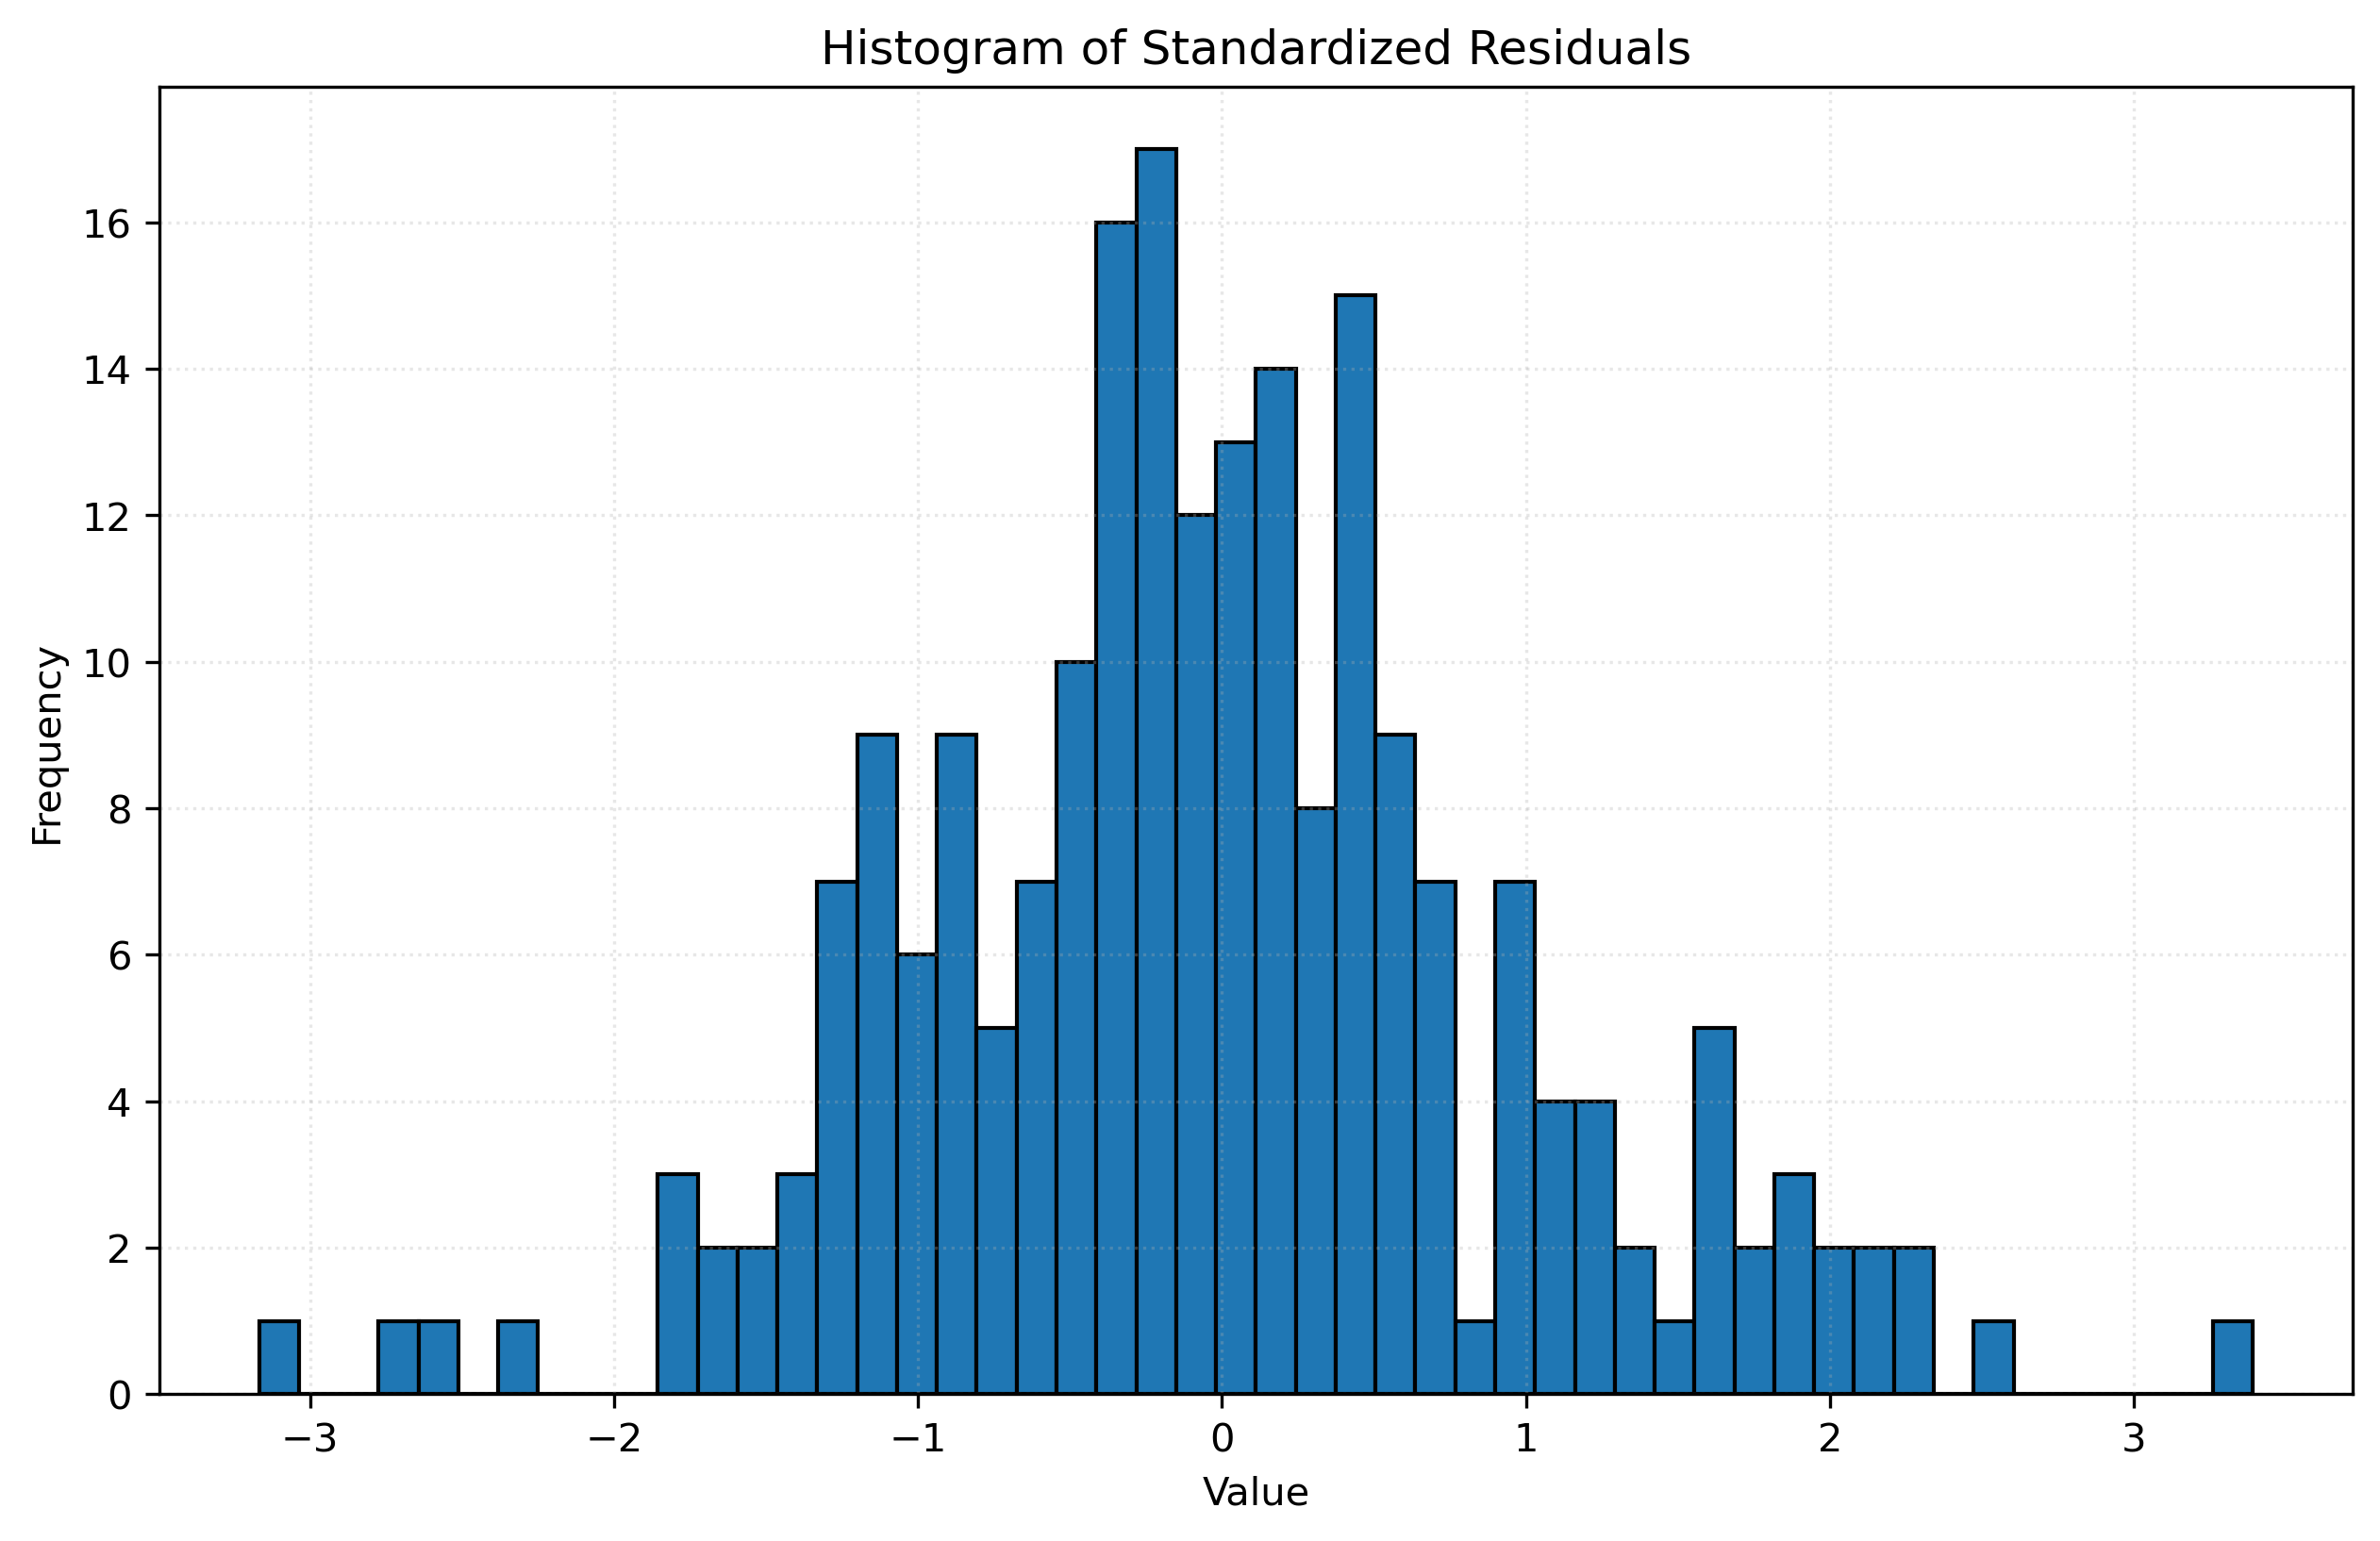

# **Assets:** USDT

**Daily returns**
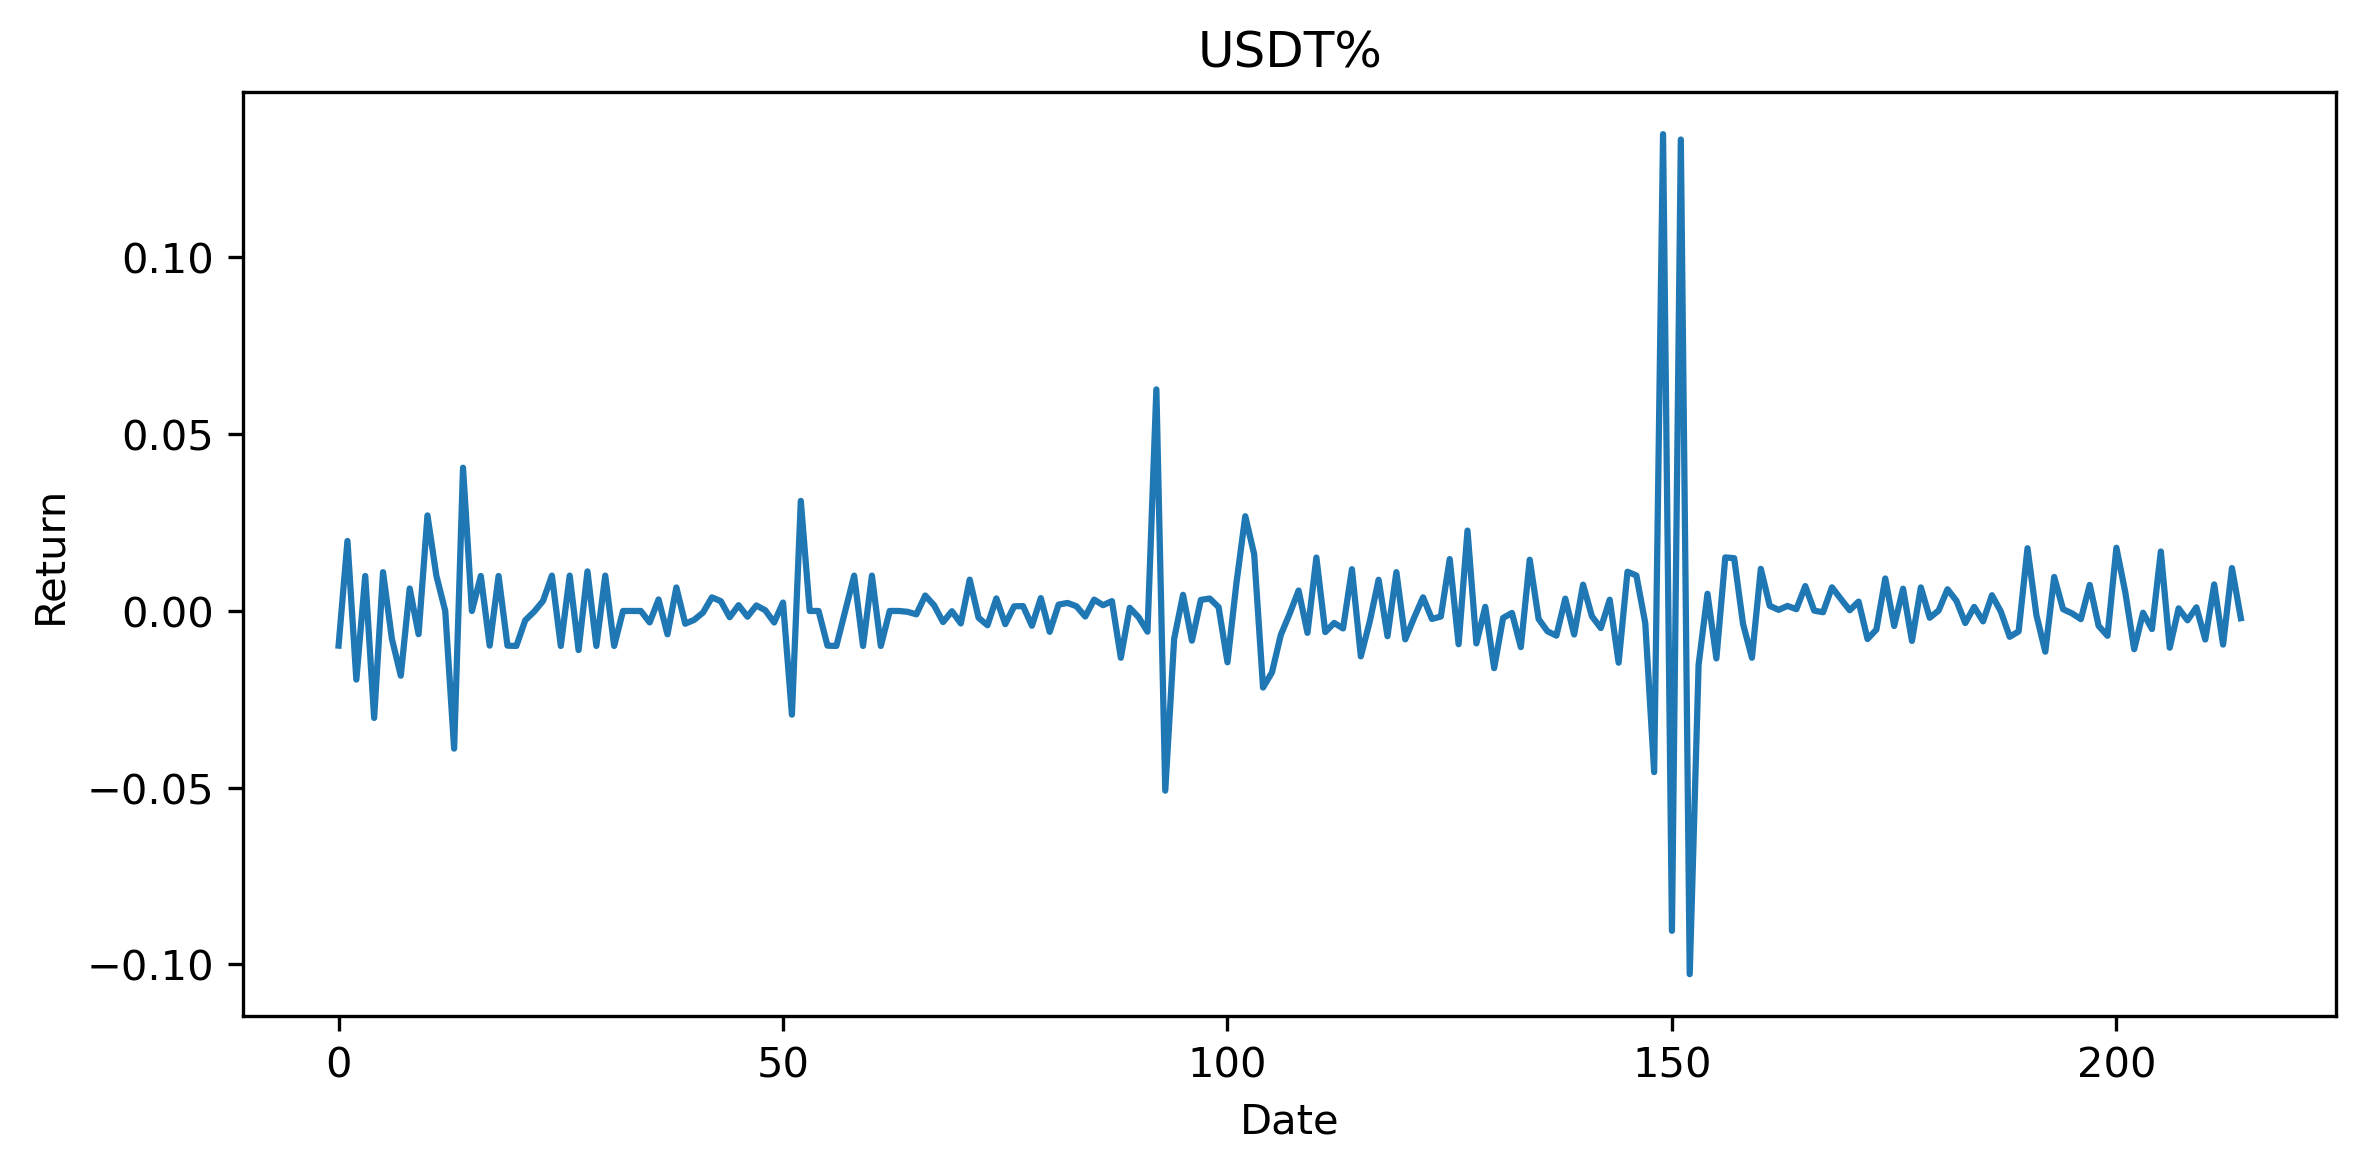

**ACF of return**
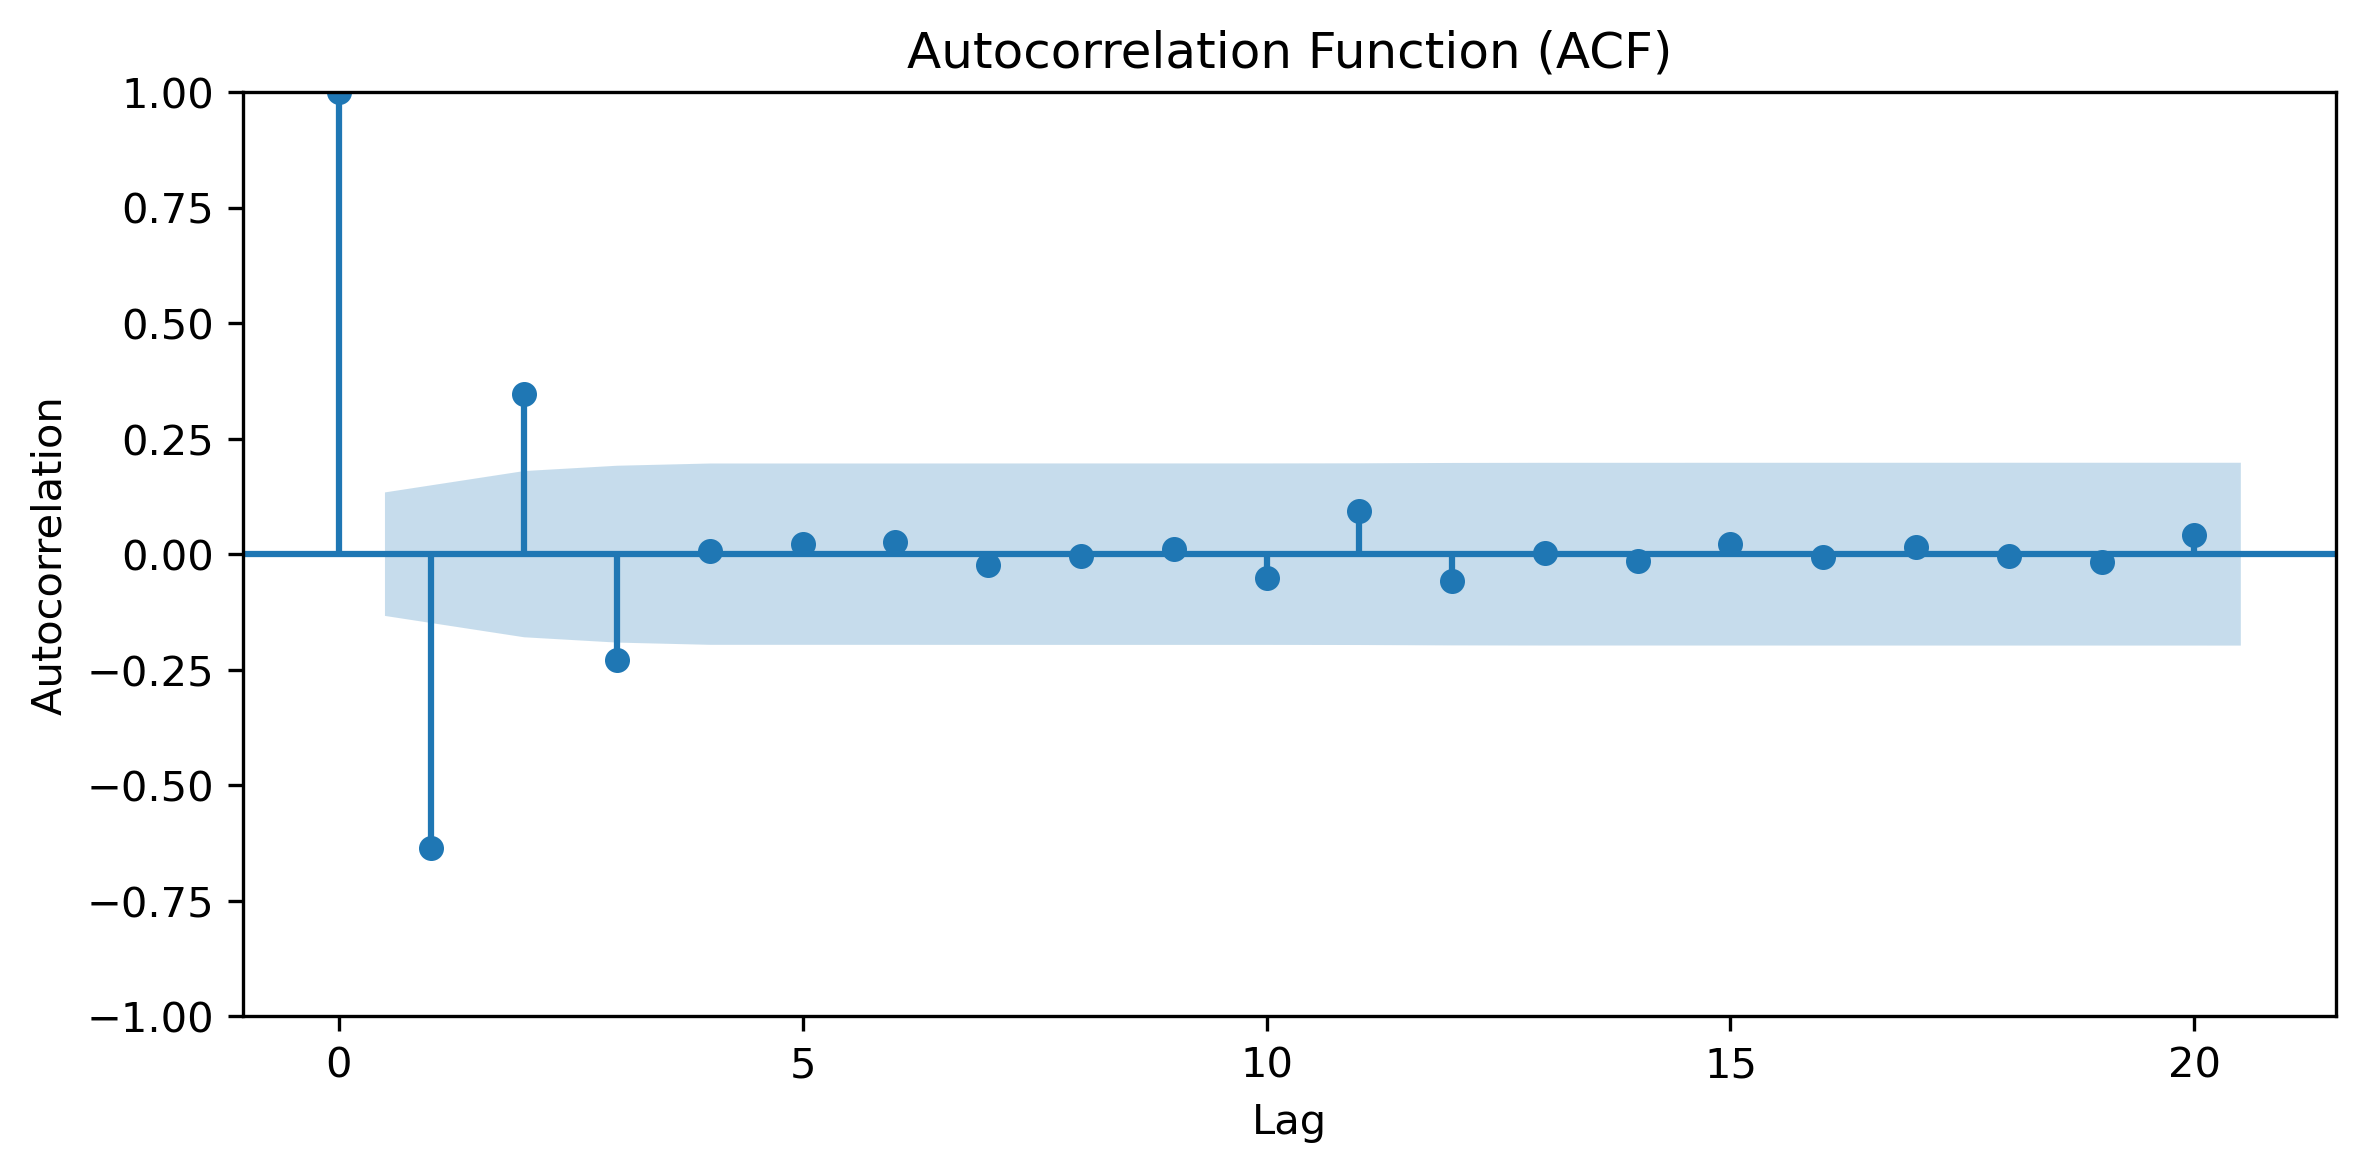

**Partial Autocorrelation Function (PACF) of return**
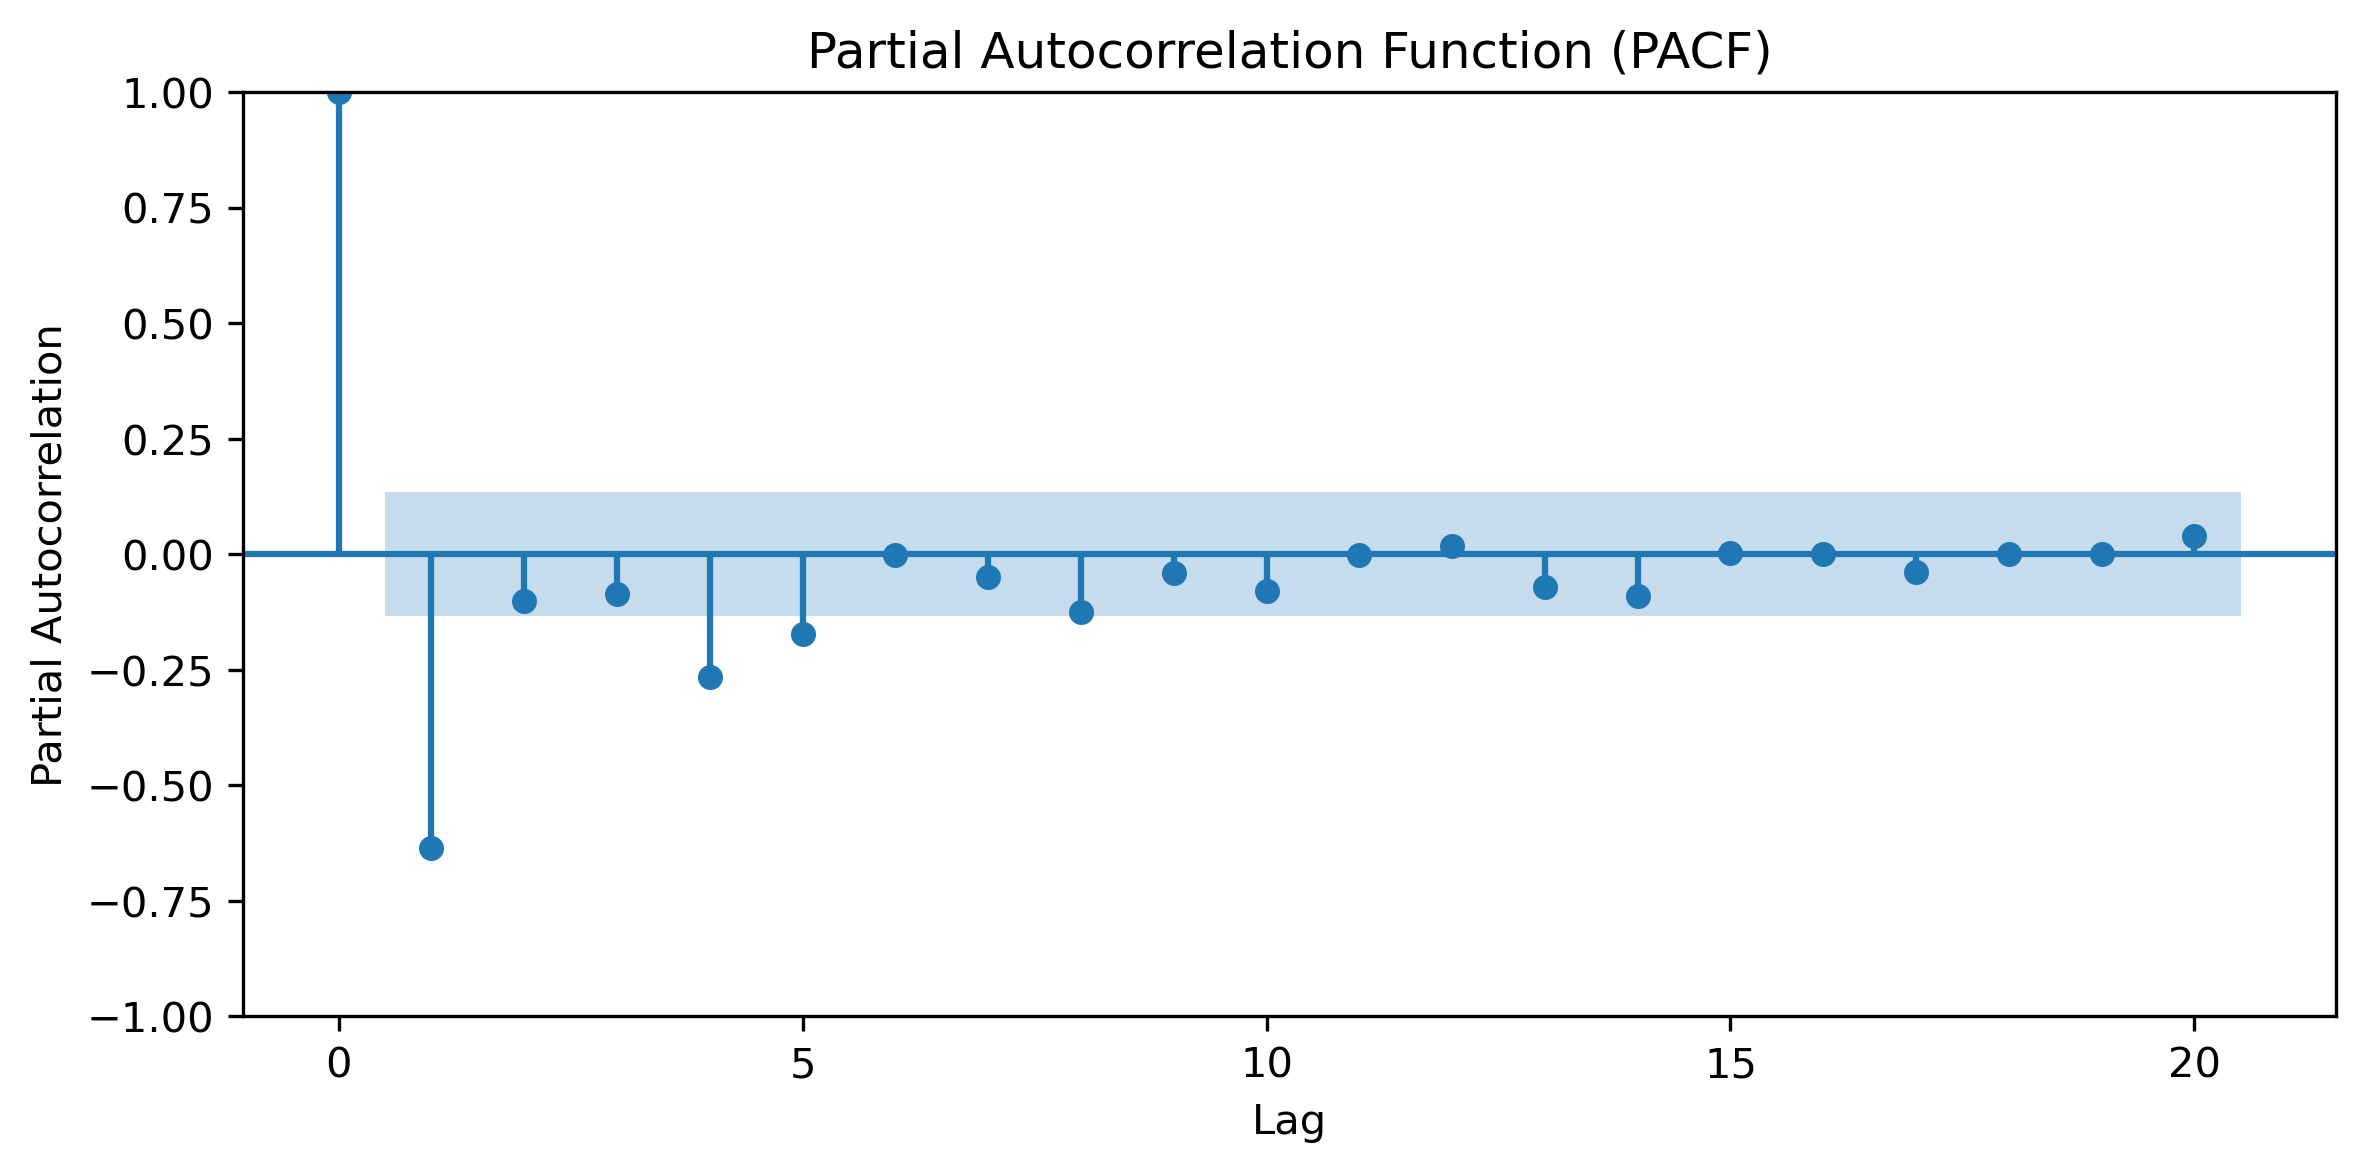

**Estimated conditional volatility ($σ_t$) — GJR‑GARCH**
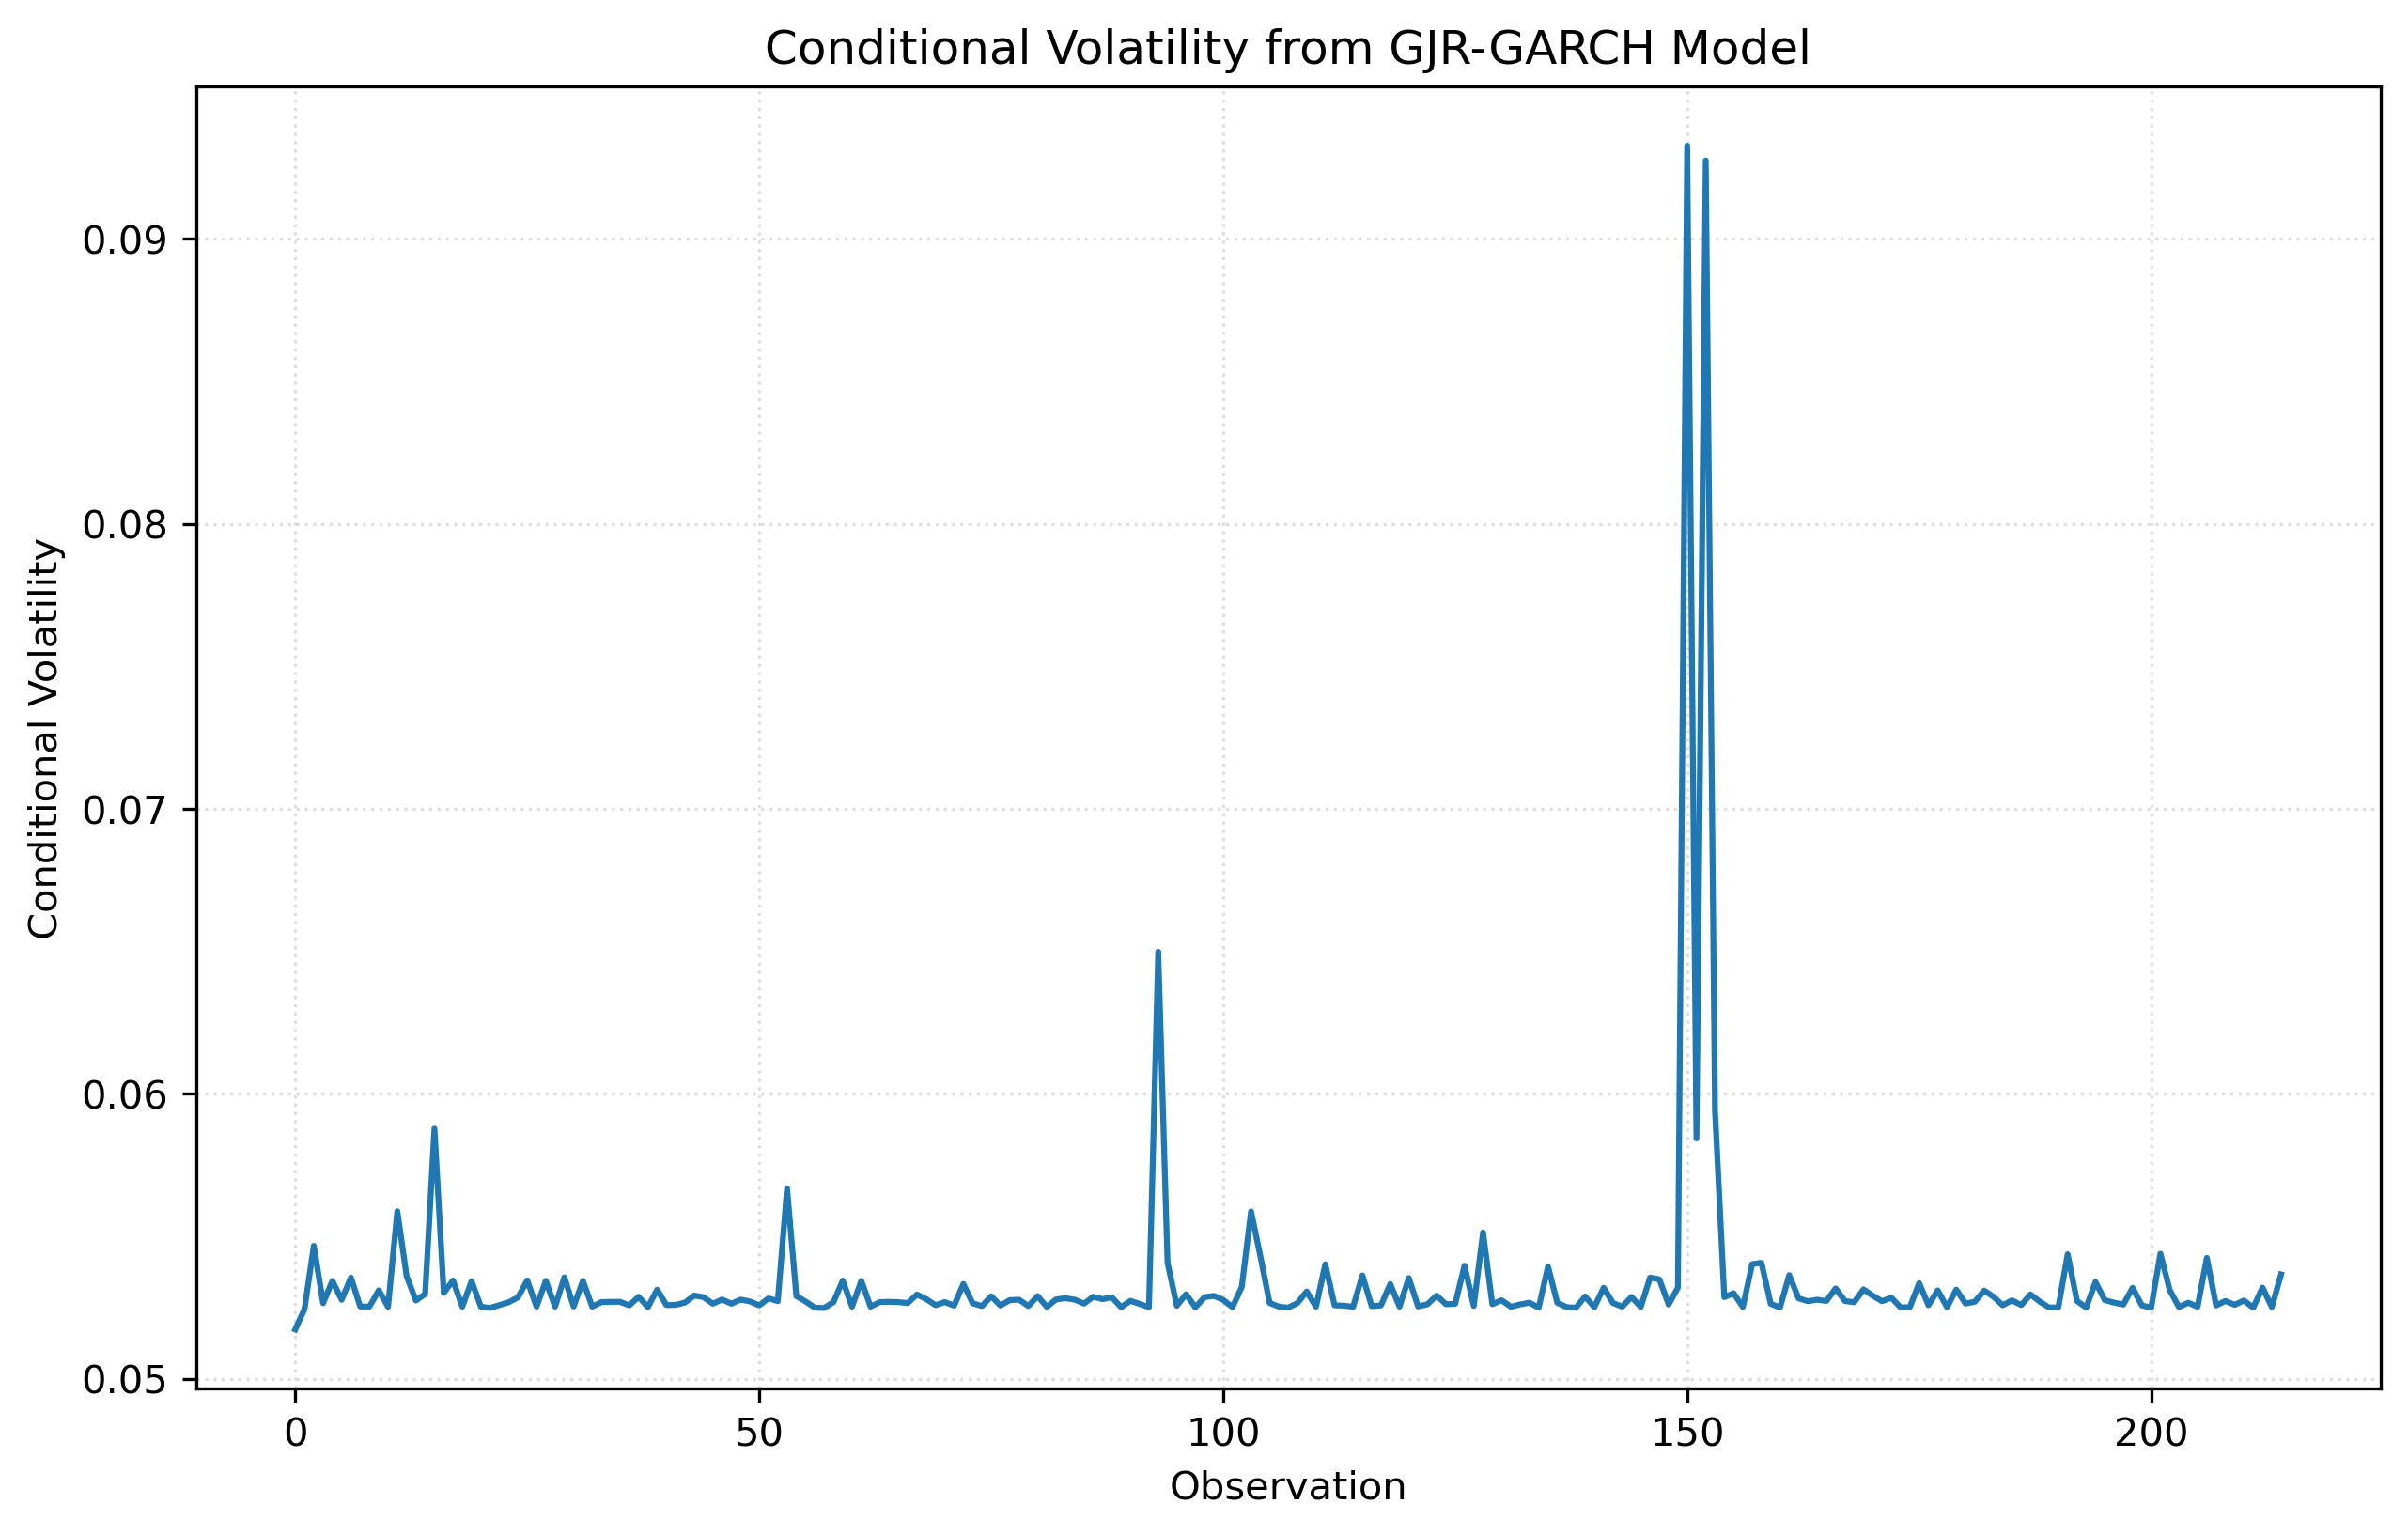

**Histogram of standardized residuals from the volatility model**
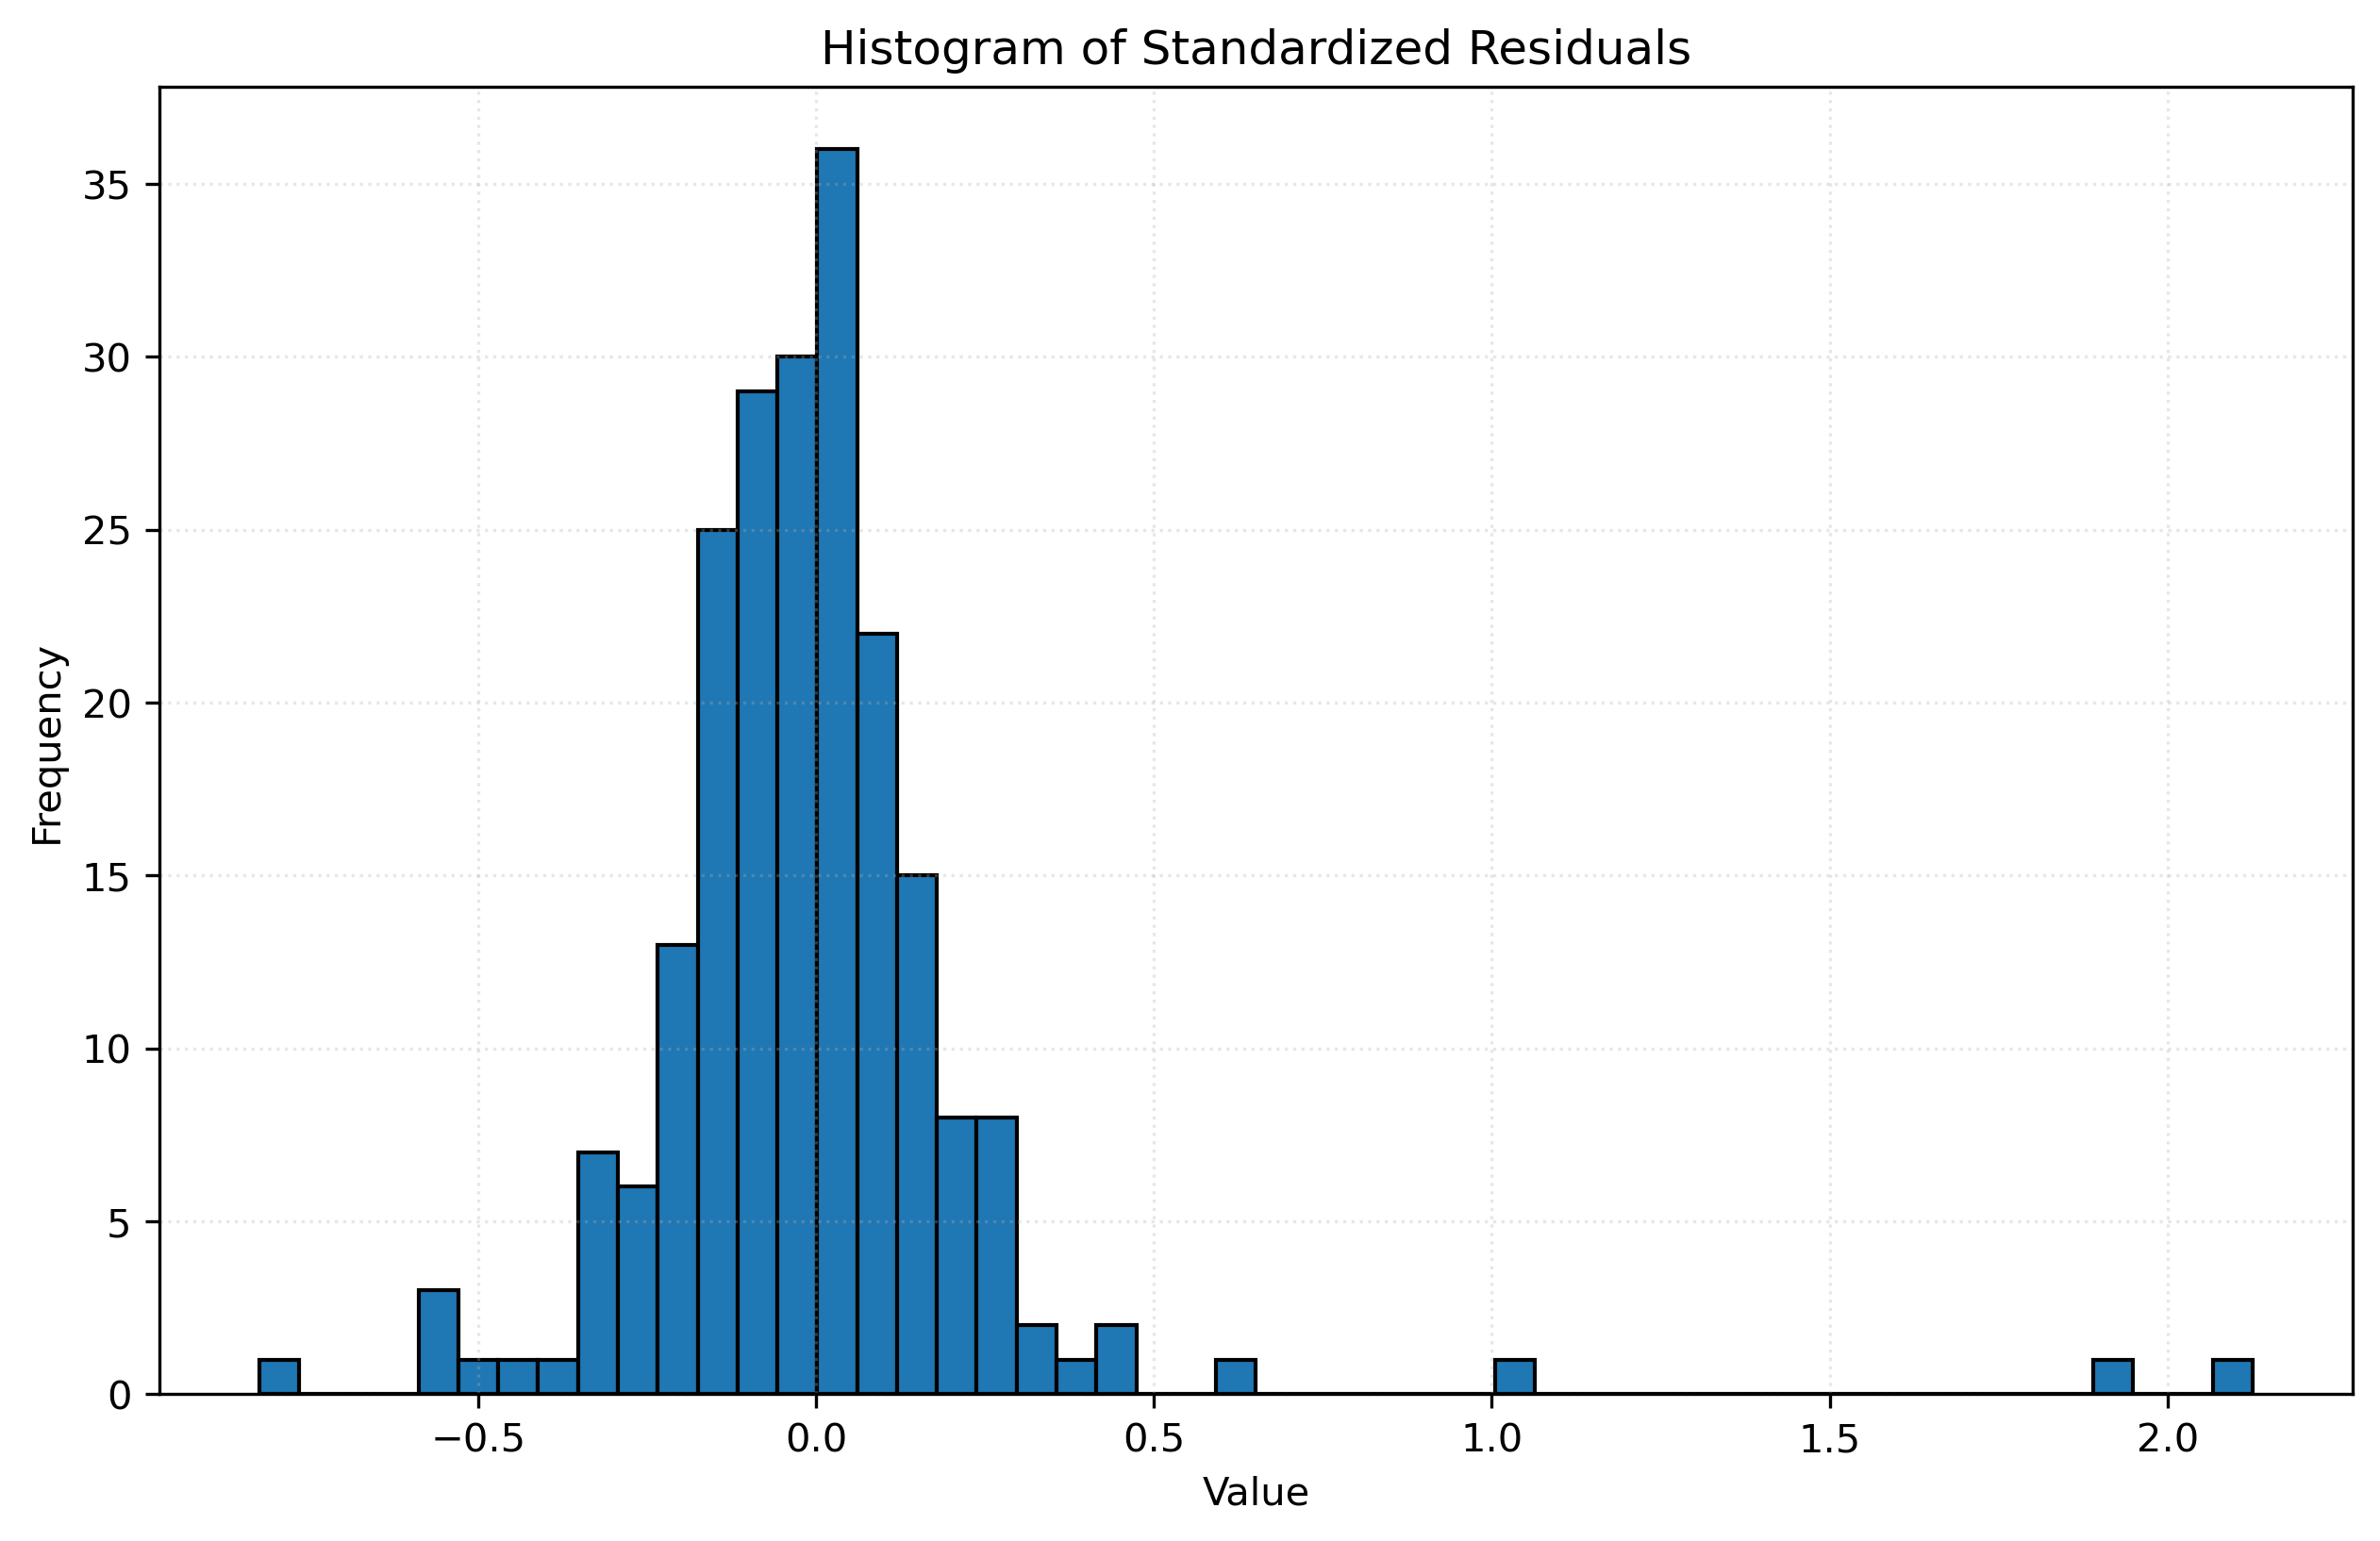

## Skew-t PIT vs Raw Series

Below are histograms comparing the **Probability Integral Transform (PIT) values under a fitted Skew-t distribution** against the **raw return series** for each asset.  
This step evaluates whether the ARIMA–GJR-GARCH residuals transformed by Skew-t provide a more Gaussian-like distribution suitable for copula modeling.

---

### BTC% — ARIMA(1,0,0)
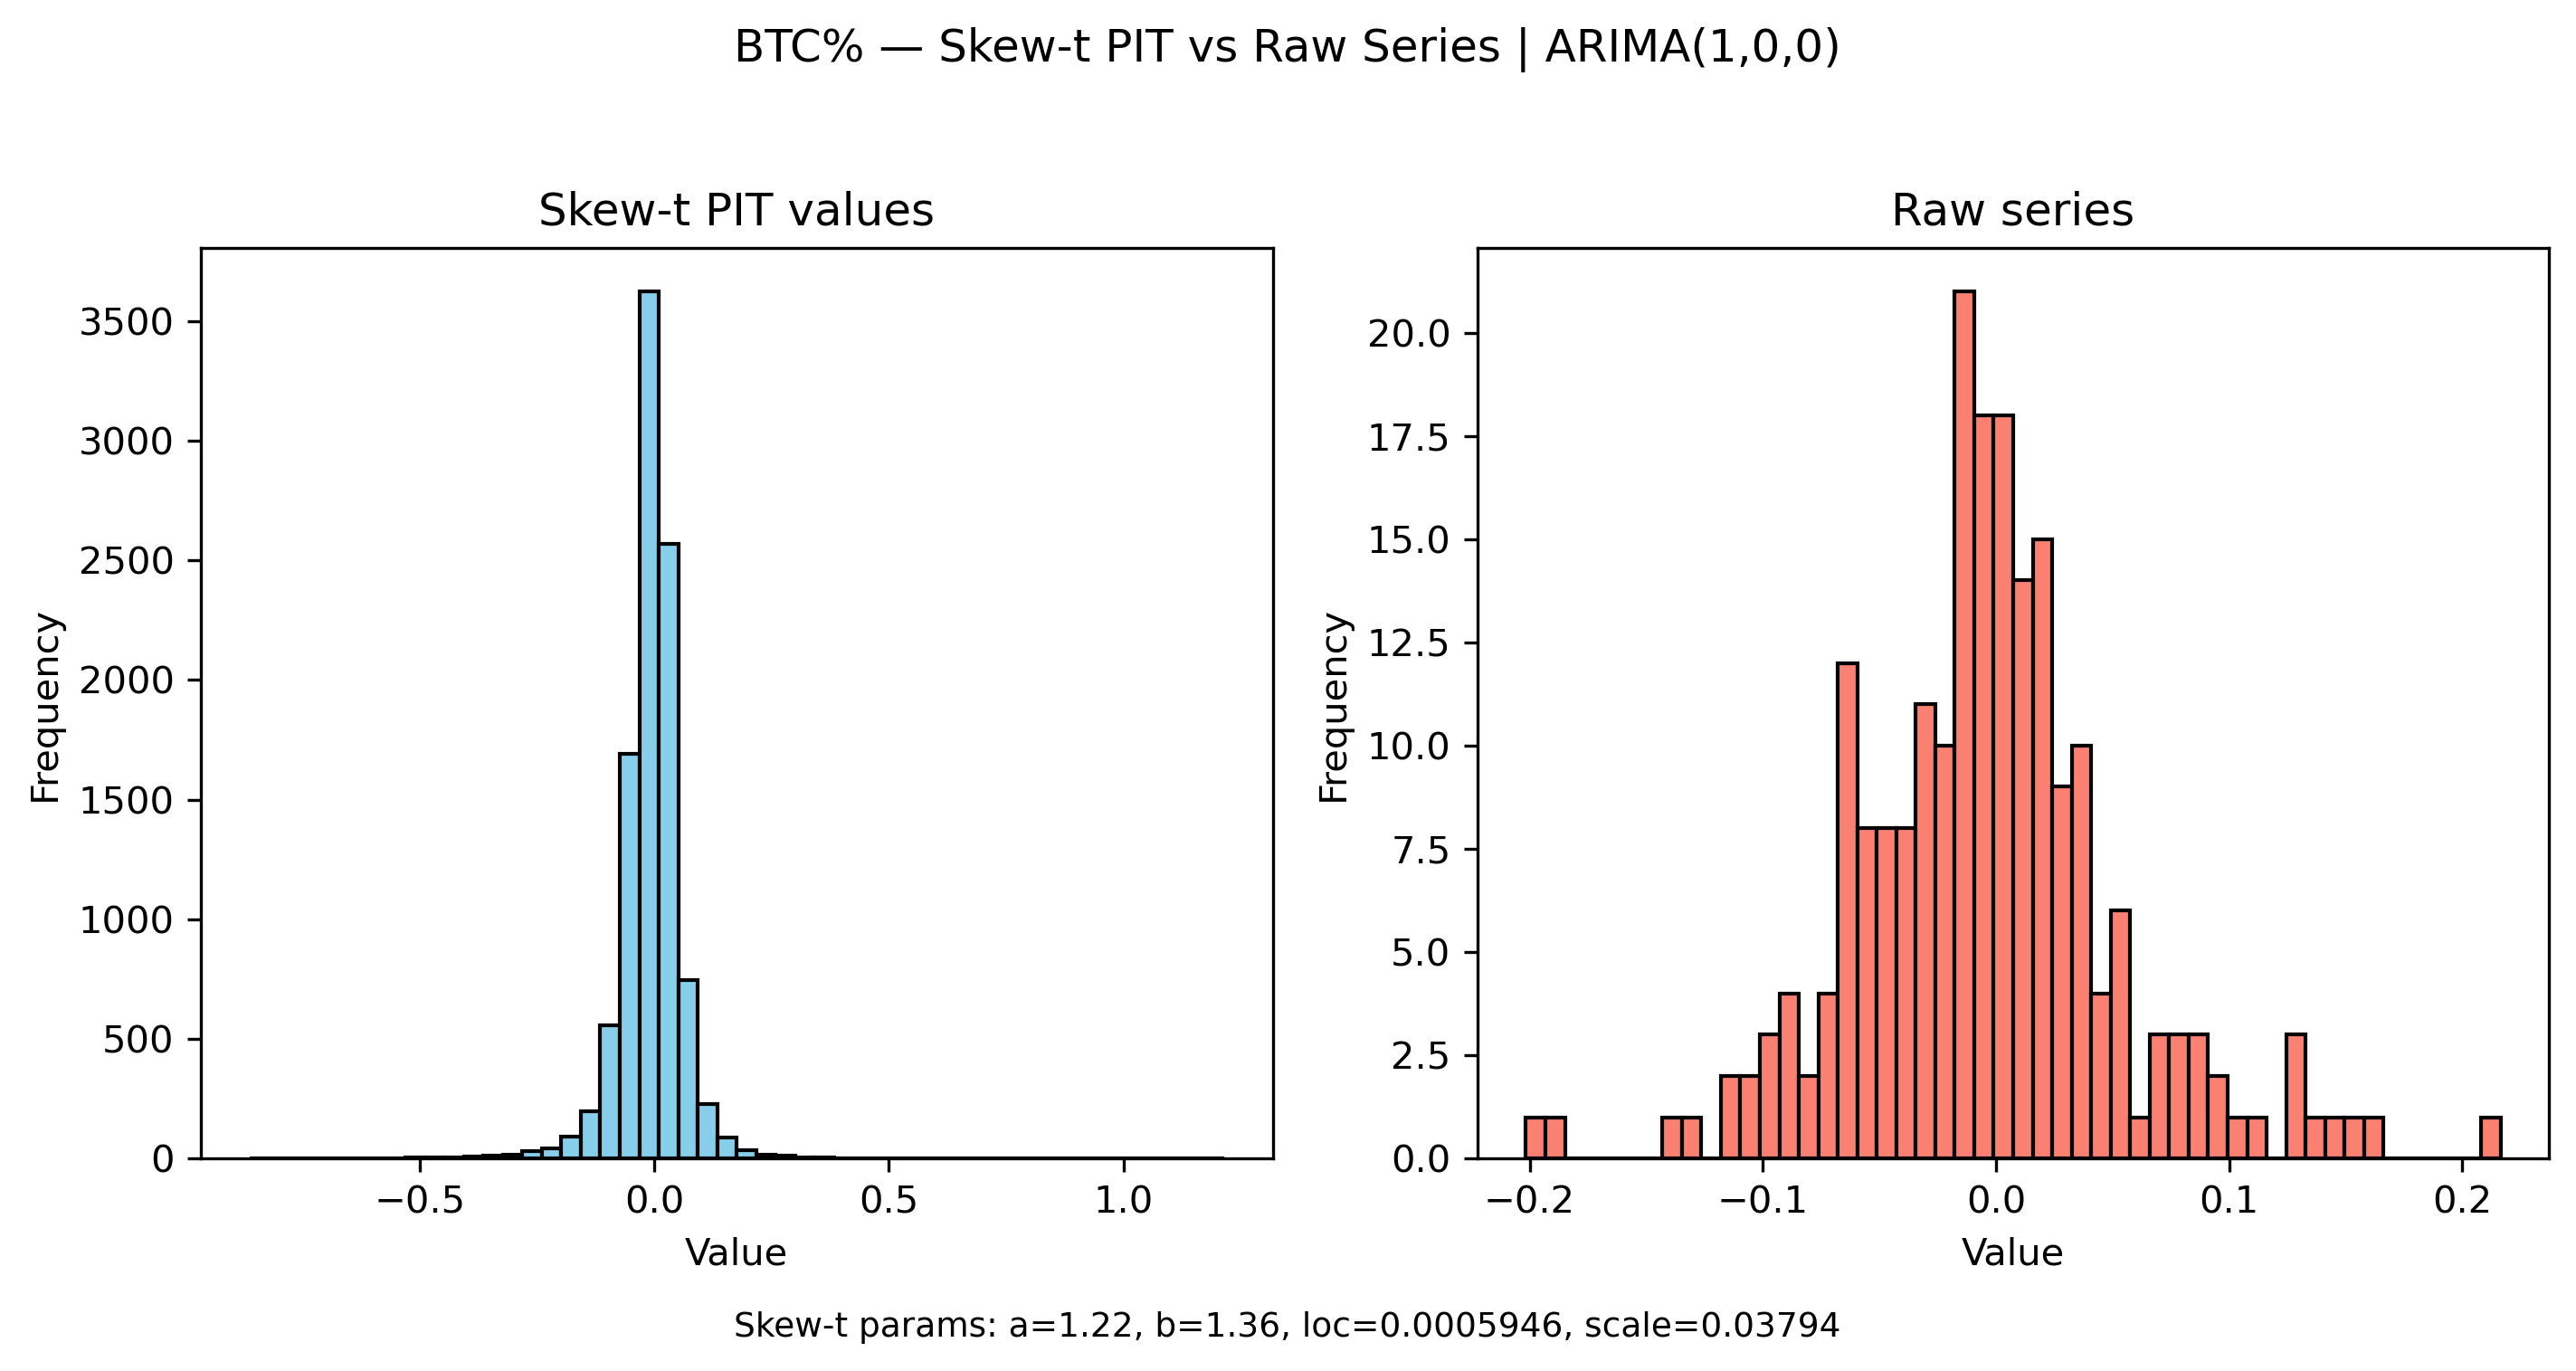
- Left: Skew-t PIT values (transformed, should resemble uniform/normal-like).
- Right: Raw BTC% return series.

---

### USDT% — ARIMA(0,0,1)
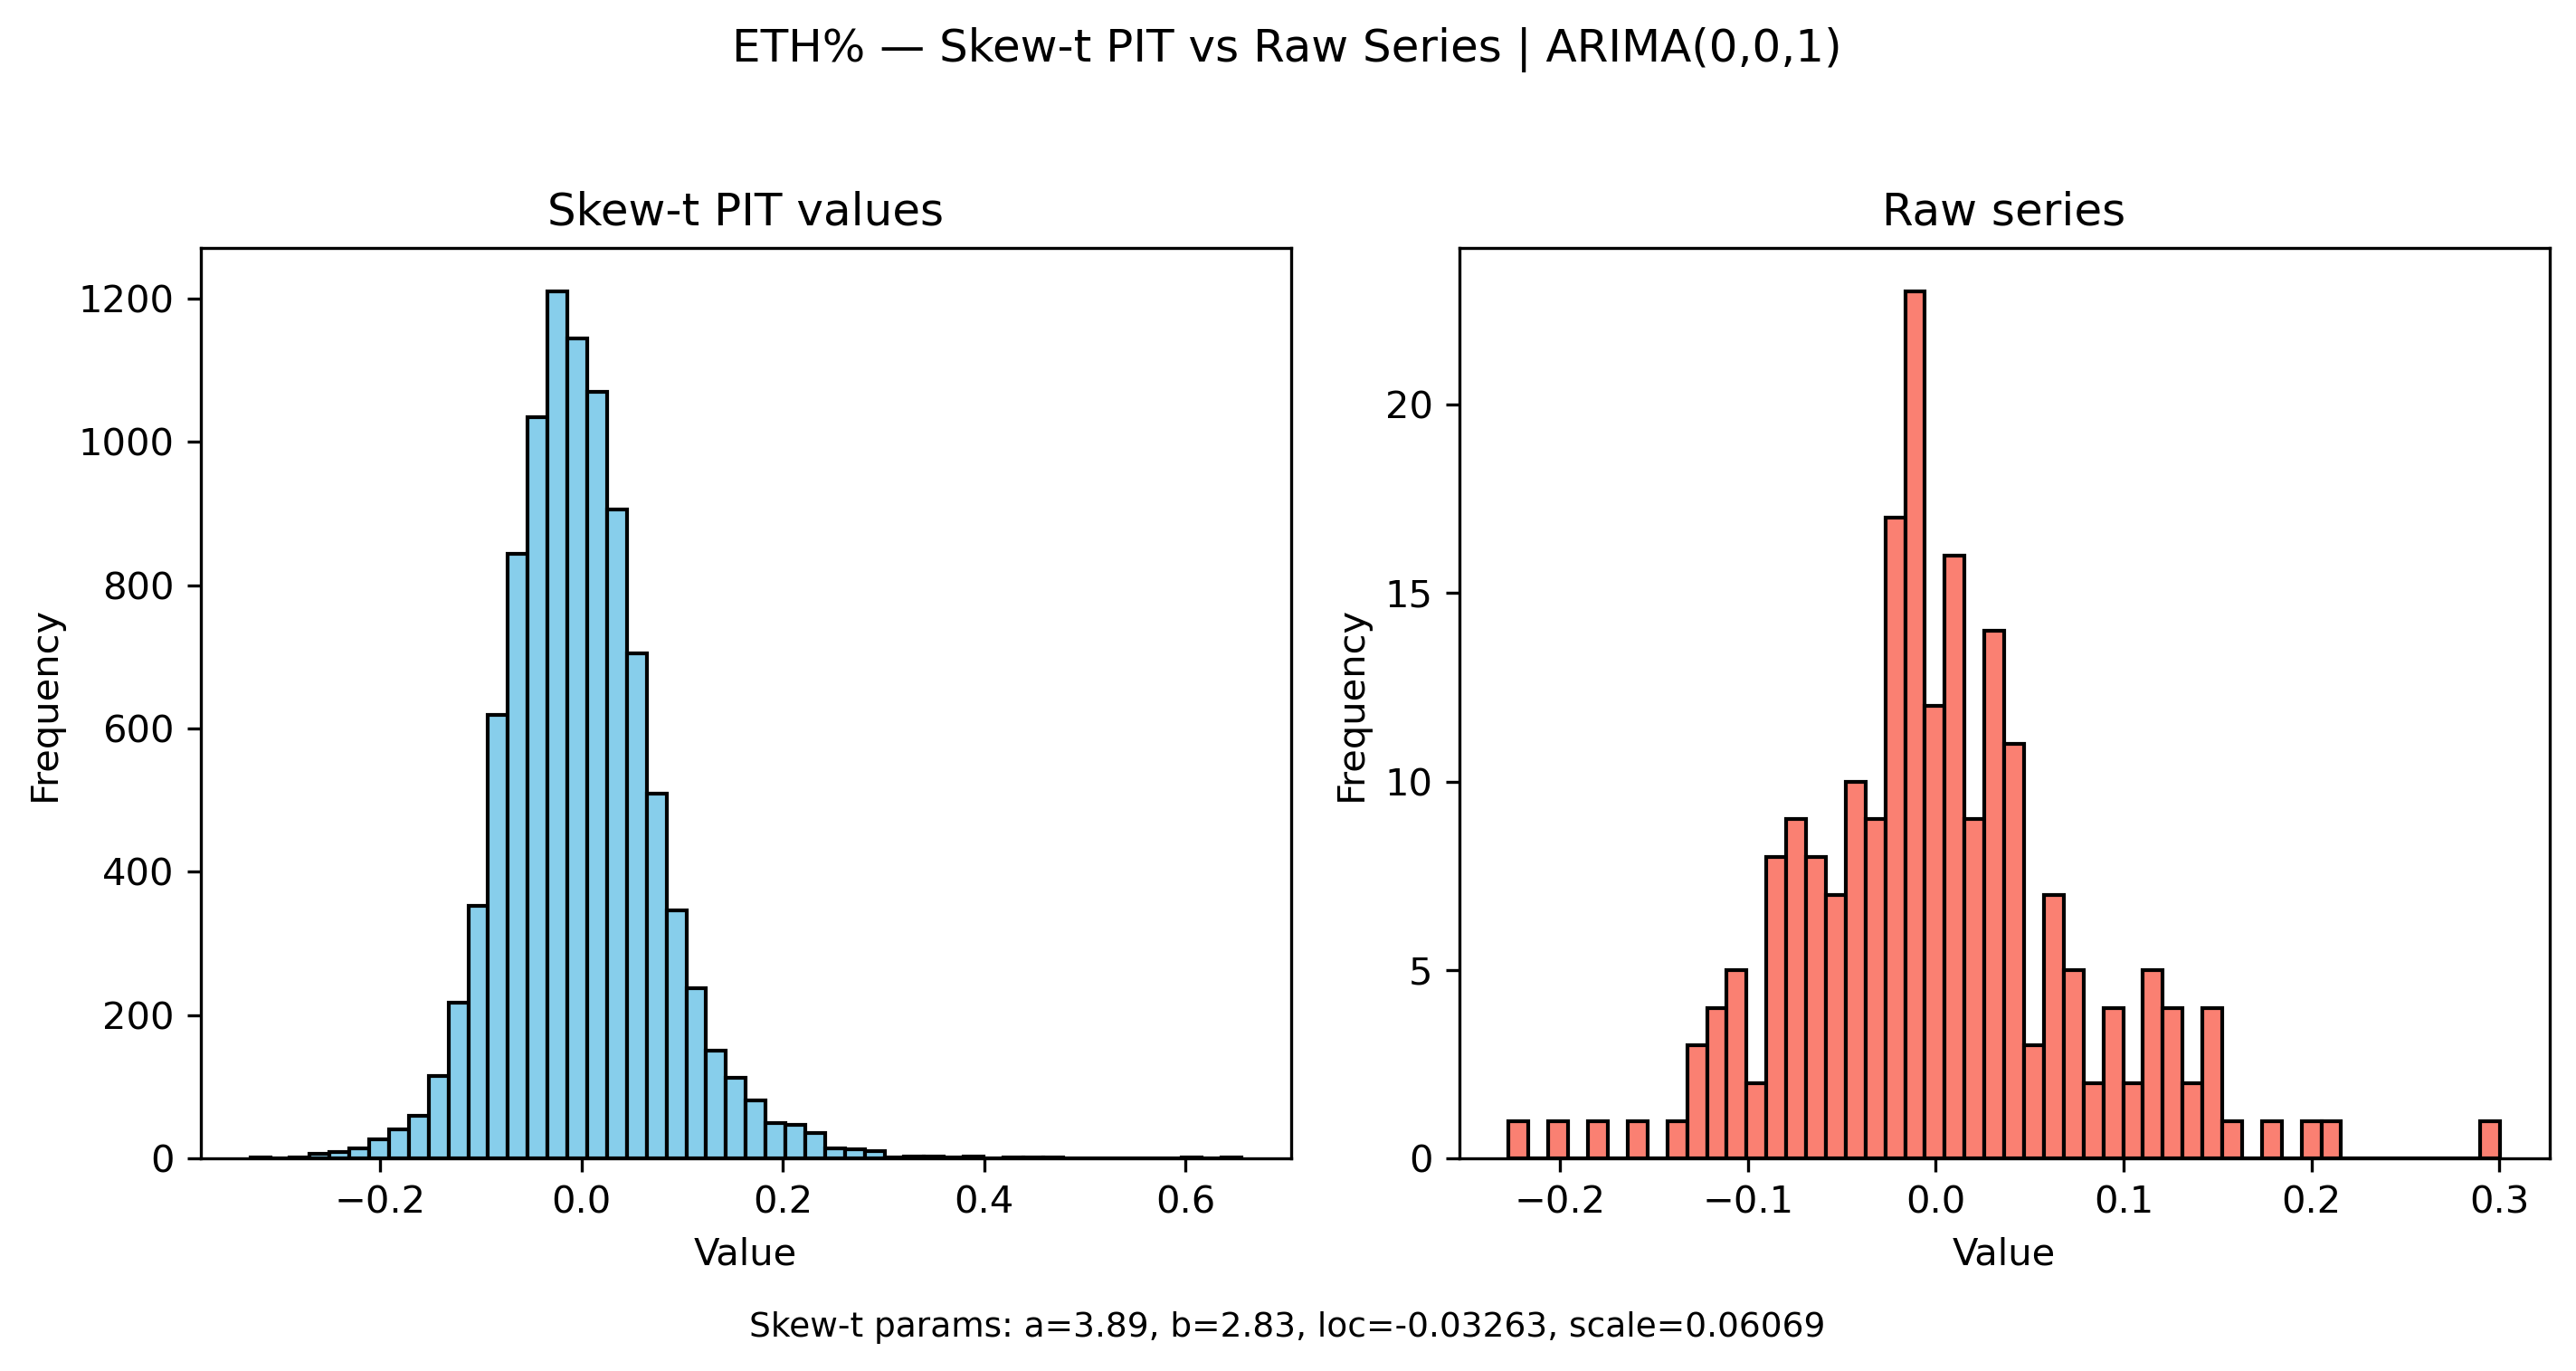
- Left: Skew-t PIT values.
- Right: Raw USDT% return series (very narrow distribution, reflecting stablecoin properties).

---

### ETH% — ARIMA(0,0,1)
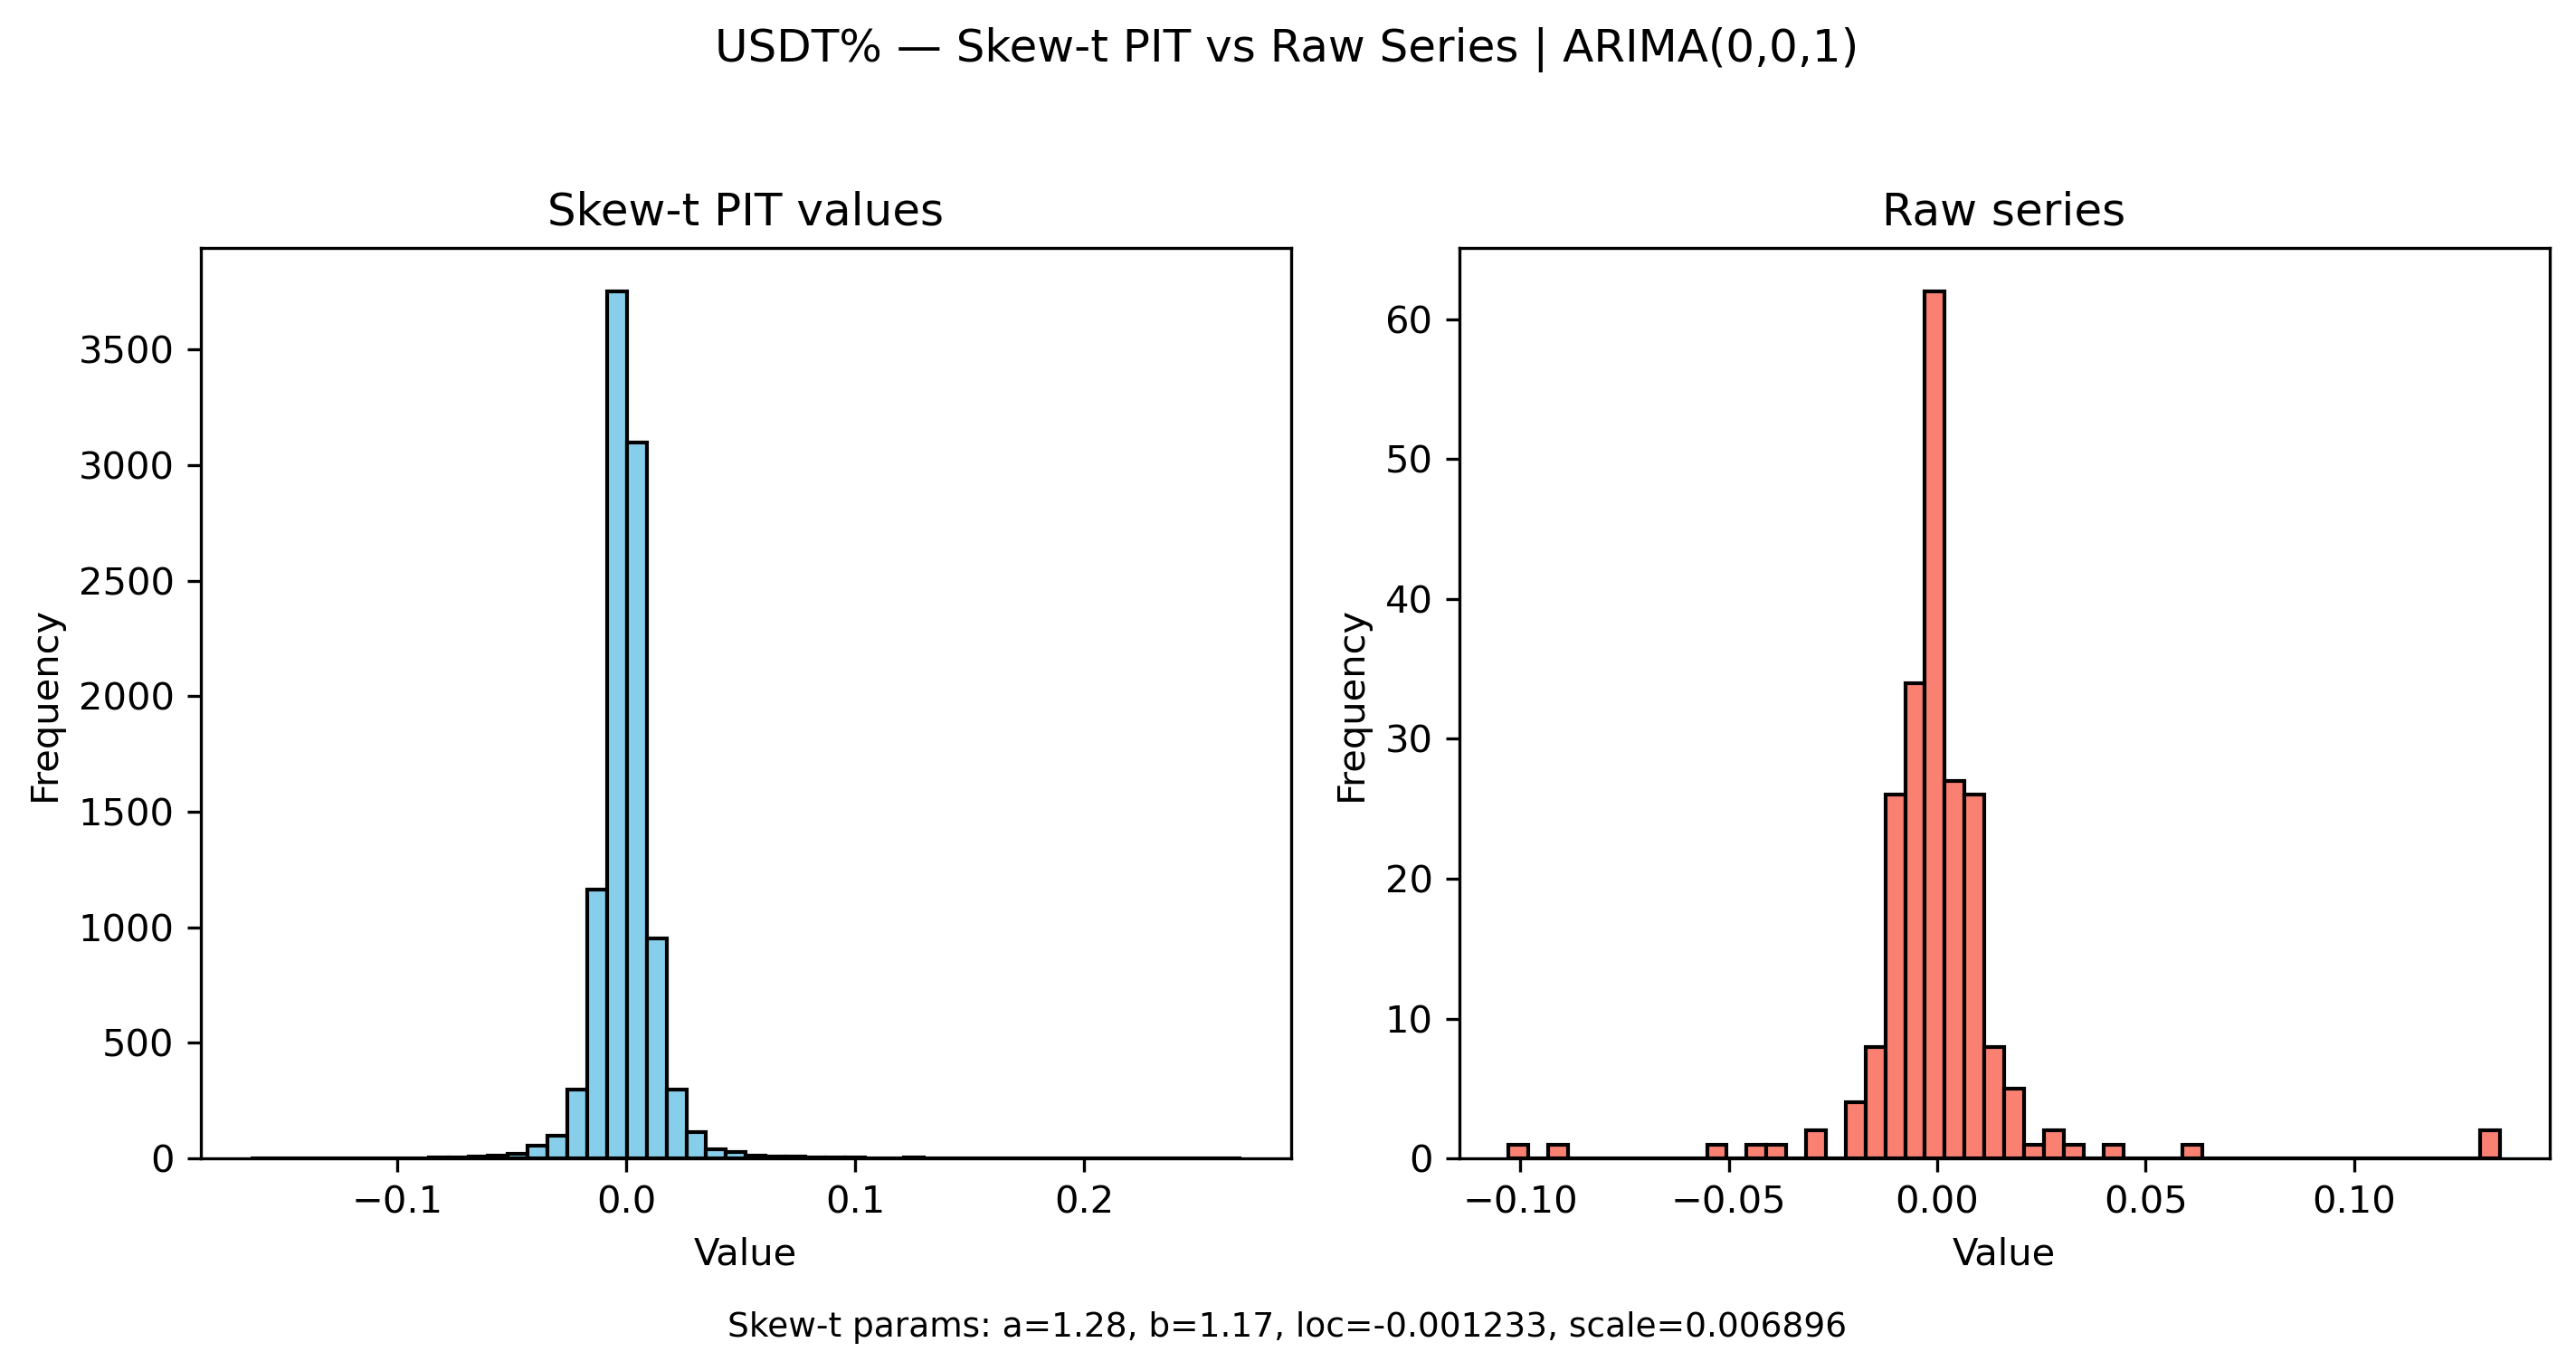
- Left: Skew-t PIT values.
- Right: Raw ETH% return series (wider dispersion, heavier tails than BTC/USDT).

---


## Portfolio Optimization Results

### Efficient Frontier
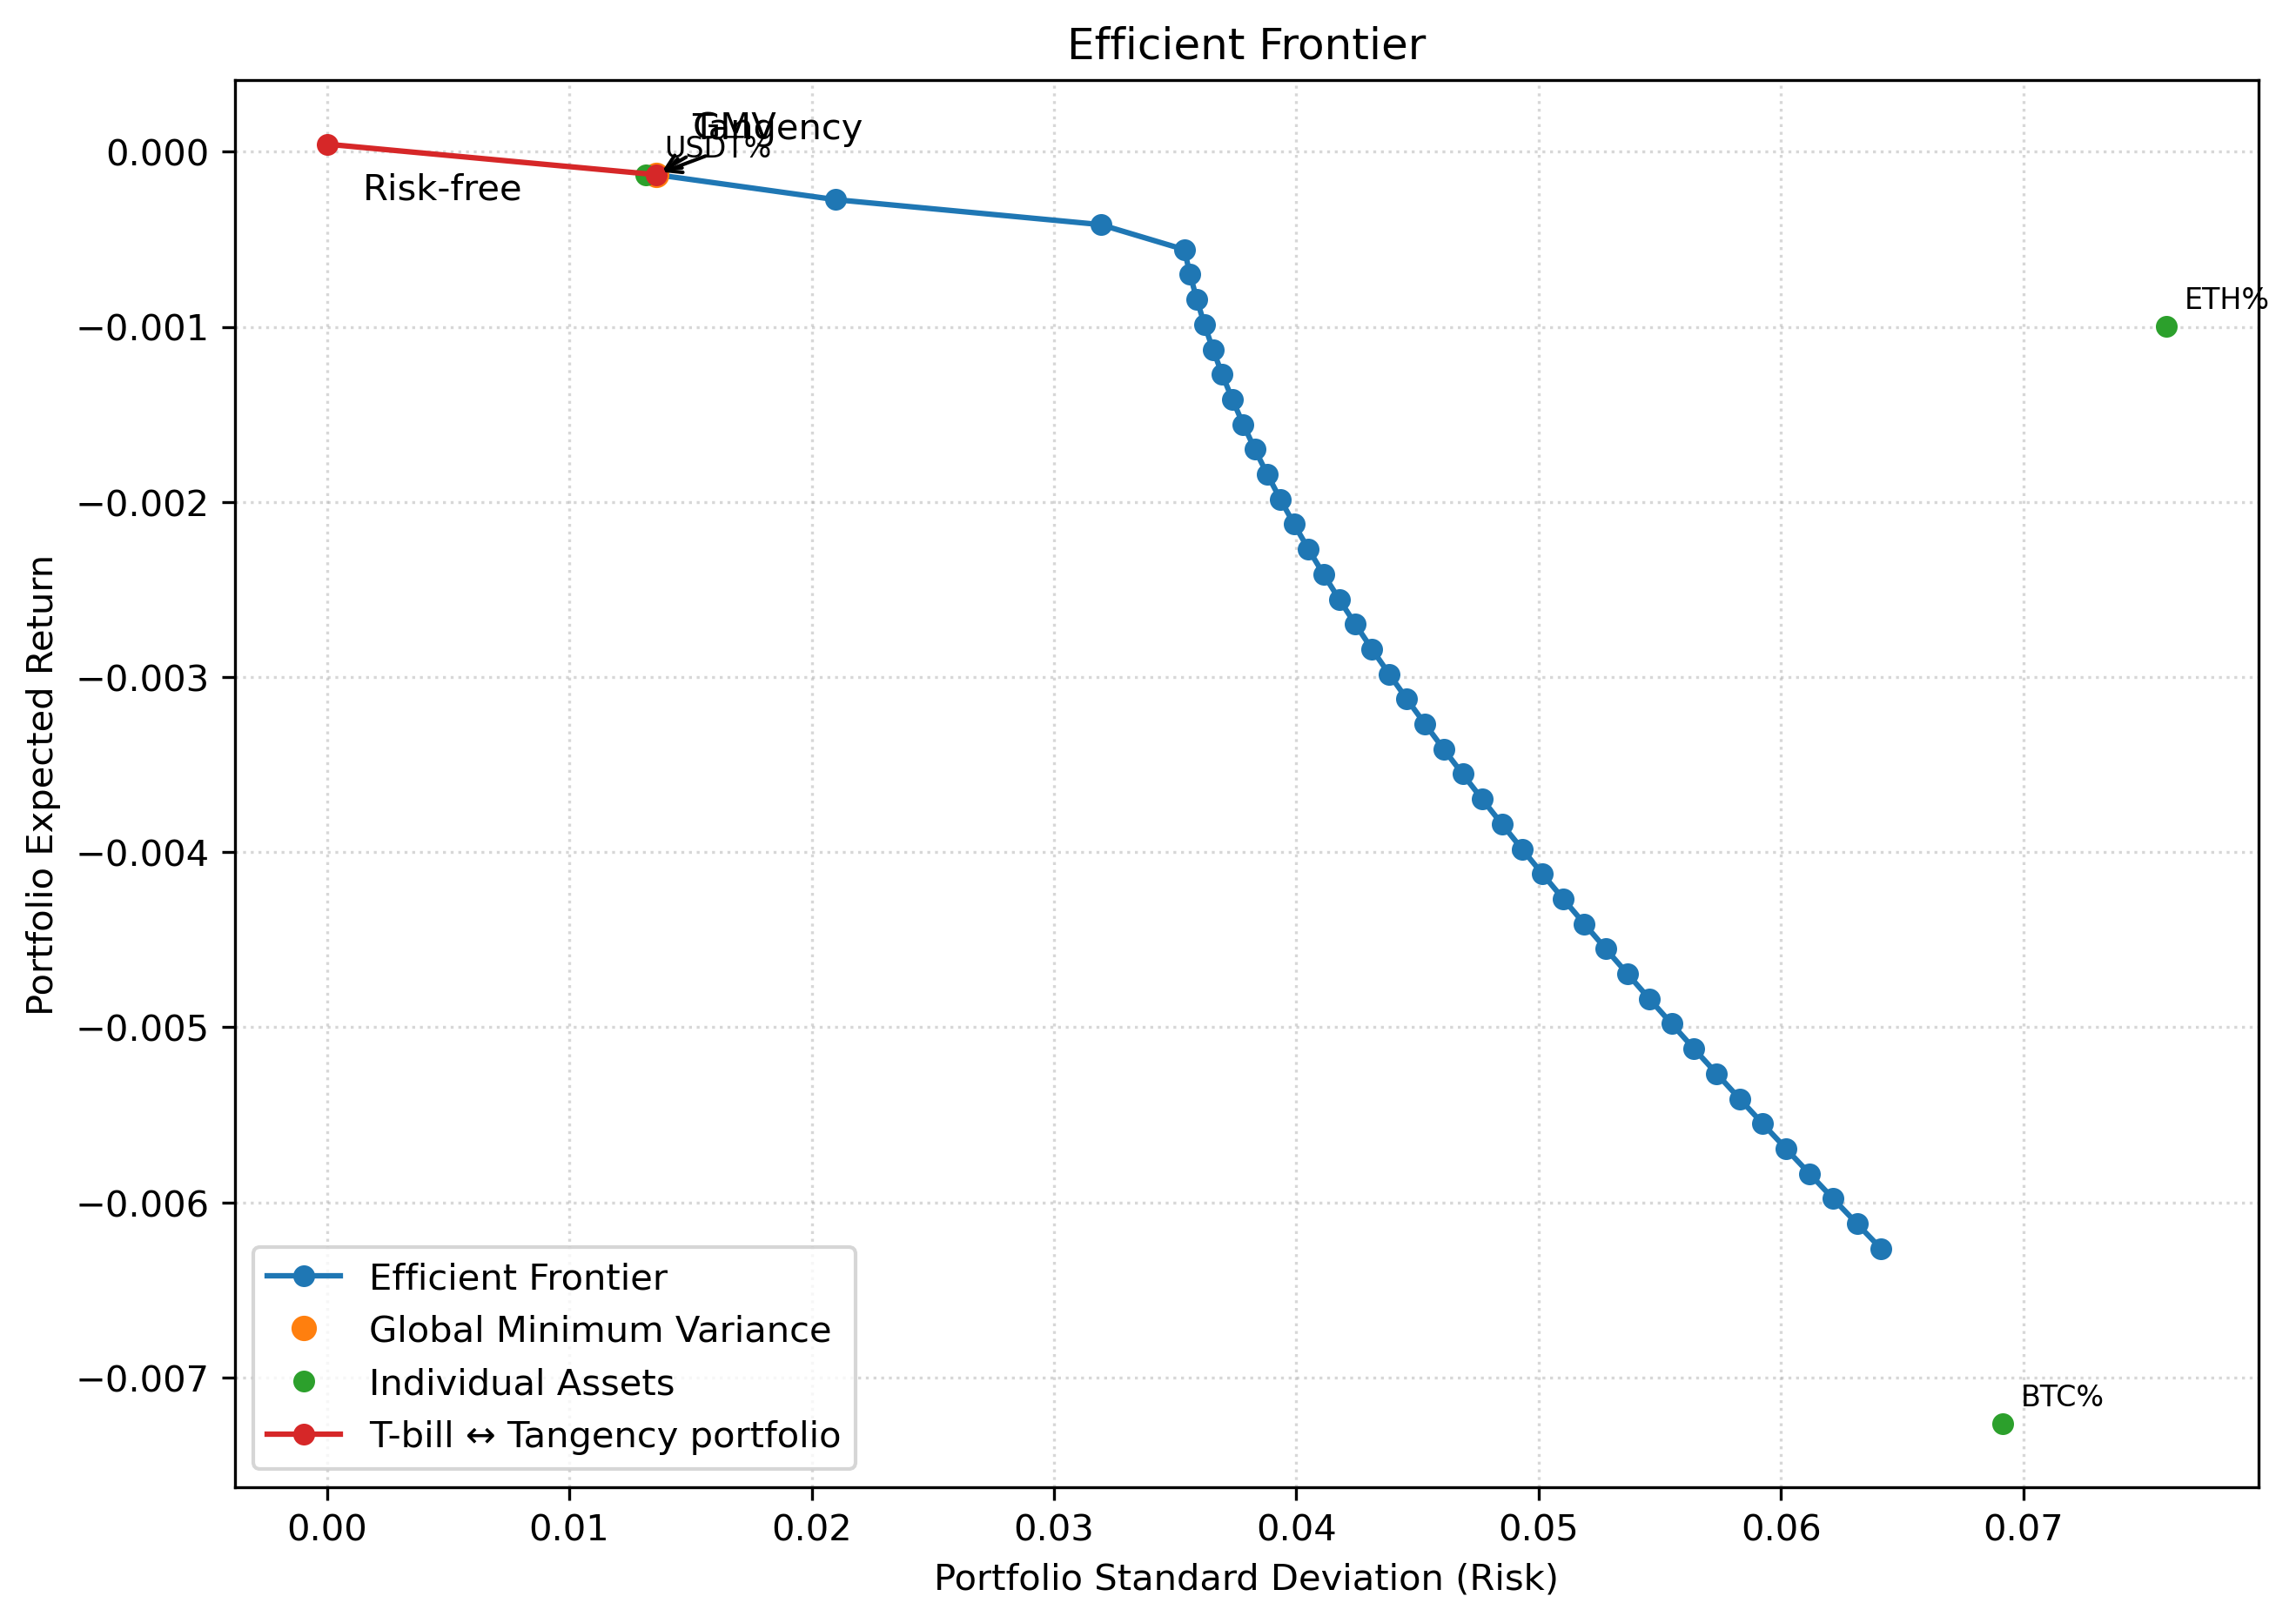

- The blue curve shows the **efficient frontier** simulated from the copula-based returns of BTC%, ETH%, and USDT%.
- The **orange dot** marks the **Global Minimum Variance (GMV)** portfolio.
- The **red line** represents the **capital allocation line** from the risk-free rate to the **tangency portfolio**.
- Individual assets (BTC%, ETH%, USDT%) are plotted for comparison.

---

### Tangency Portfolio Weights
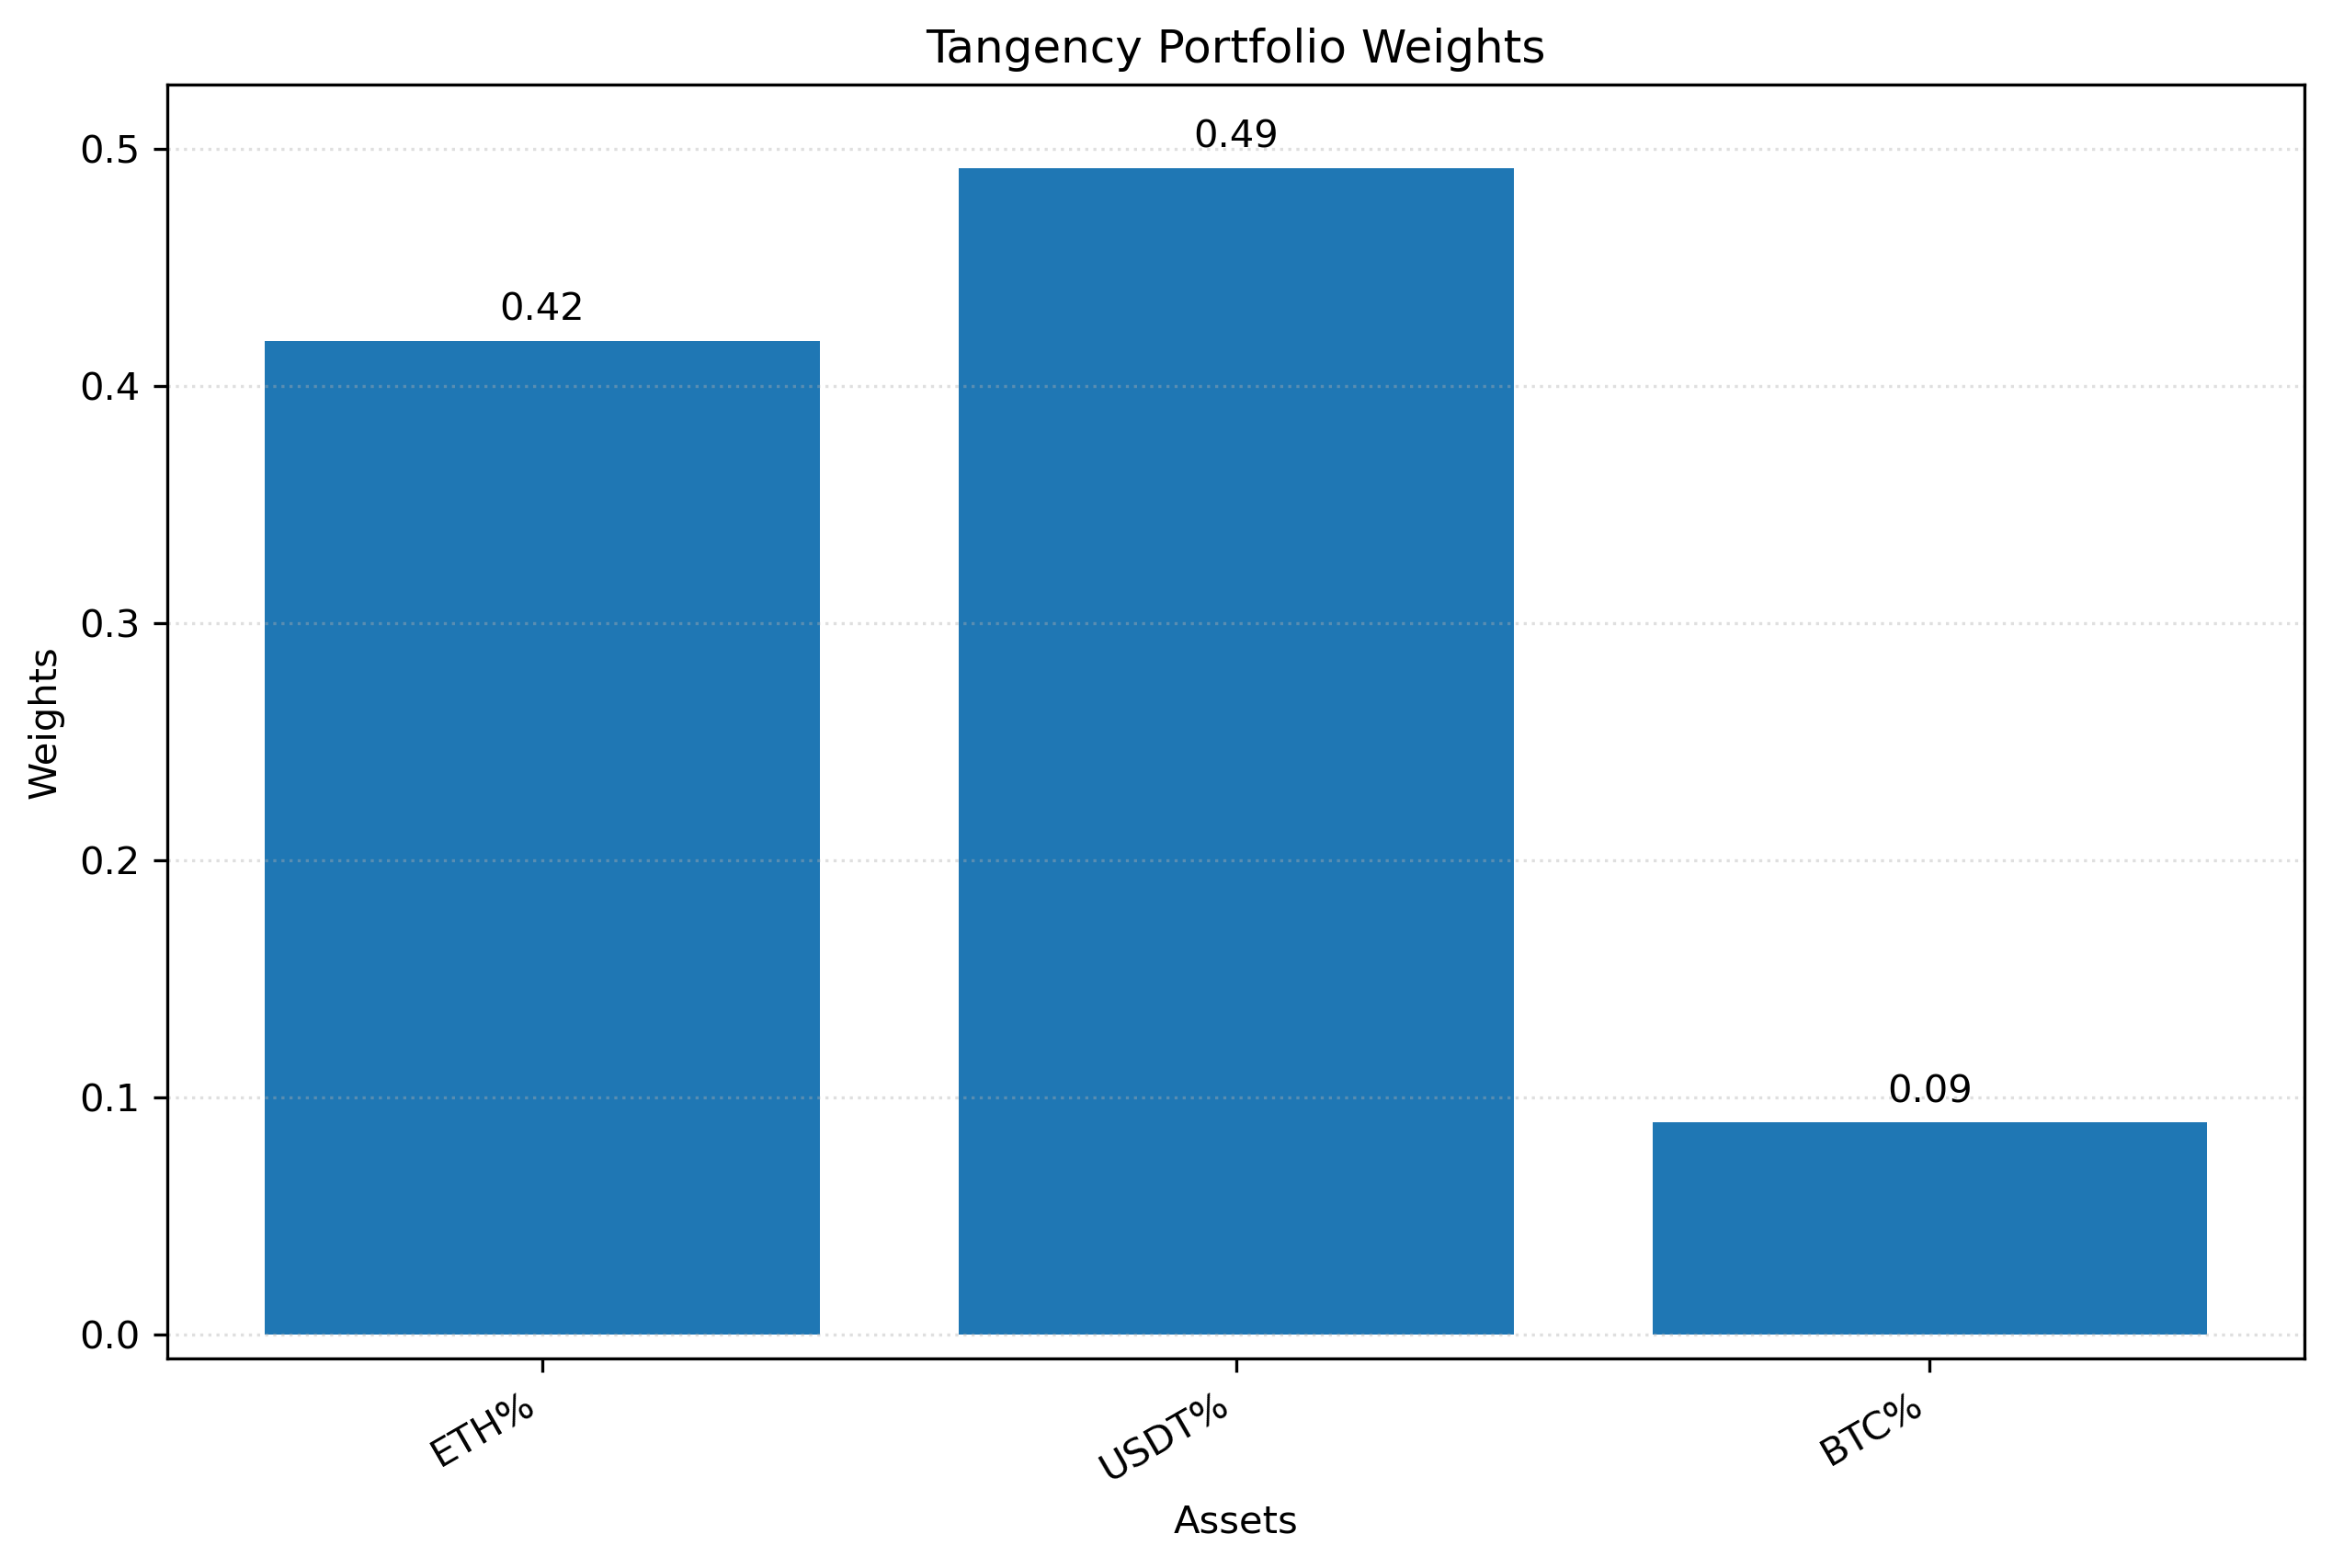

- The tangency portfolio is composed of:
  - **ETH%: ~0.42**
  - **USDT%: ~0.49**
  - **BTC%: ~0.09**
- This allocation maximizes the **Sharpe ratio** subject to the CVaR risk constraint.

---


## Backtest Results

### Performance Summary (Daily → Annualized)
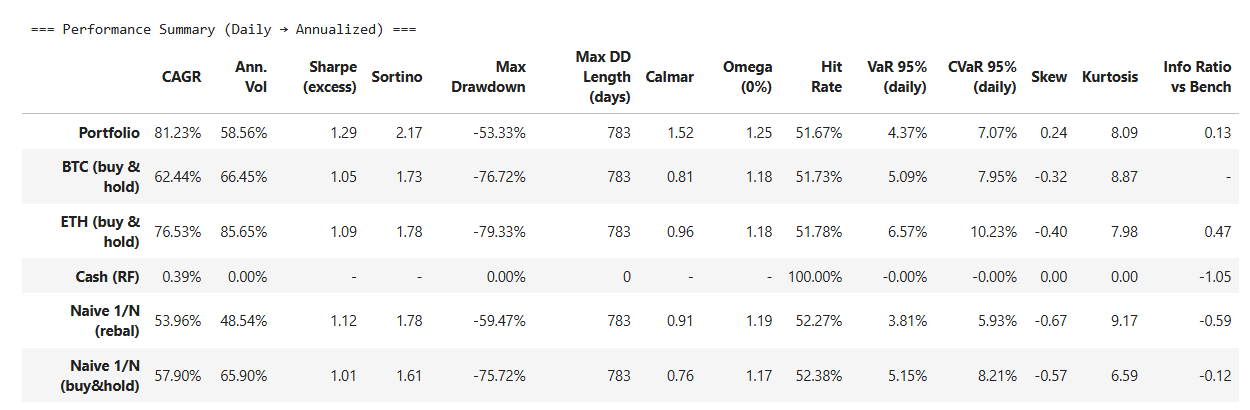

- **Portfolio** delivered the highest **CAGR (81.23%)** with a strong **Sharpe ratio (1.29)** and **Sortino ratio (2.17)**.
- It also achieved a better **Calmar ratio (1.52)** compared to BTC/ETH buy-and-hold.
- **Max drawdown (-53.33%)** was smaller than BTC (-76.72%) and ETH (-79.33%).
- Risk-adjusted performance (Omega, Info ratio) shows the portfolio outperforms naive strategies.

---

### Net Asset Value (NAV) Growth
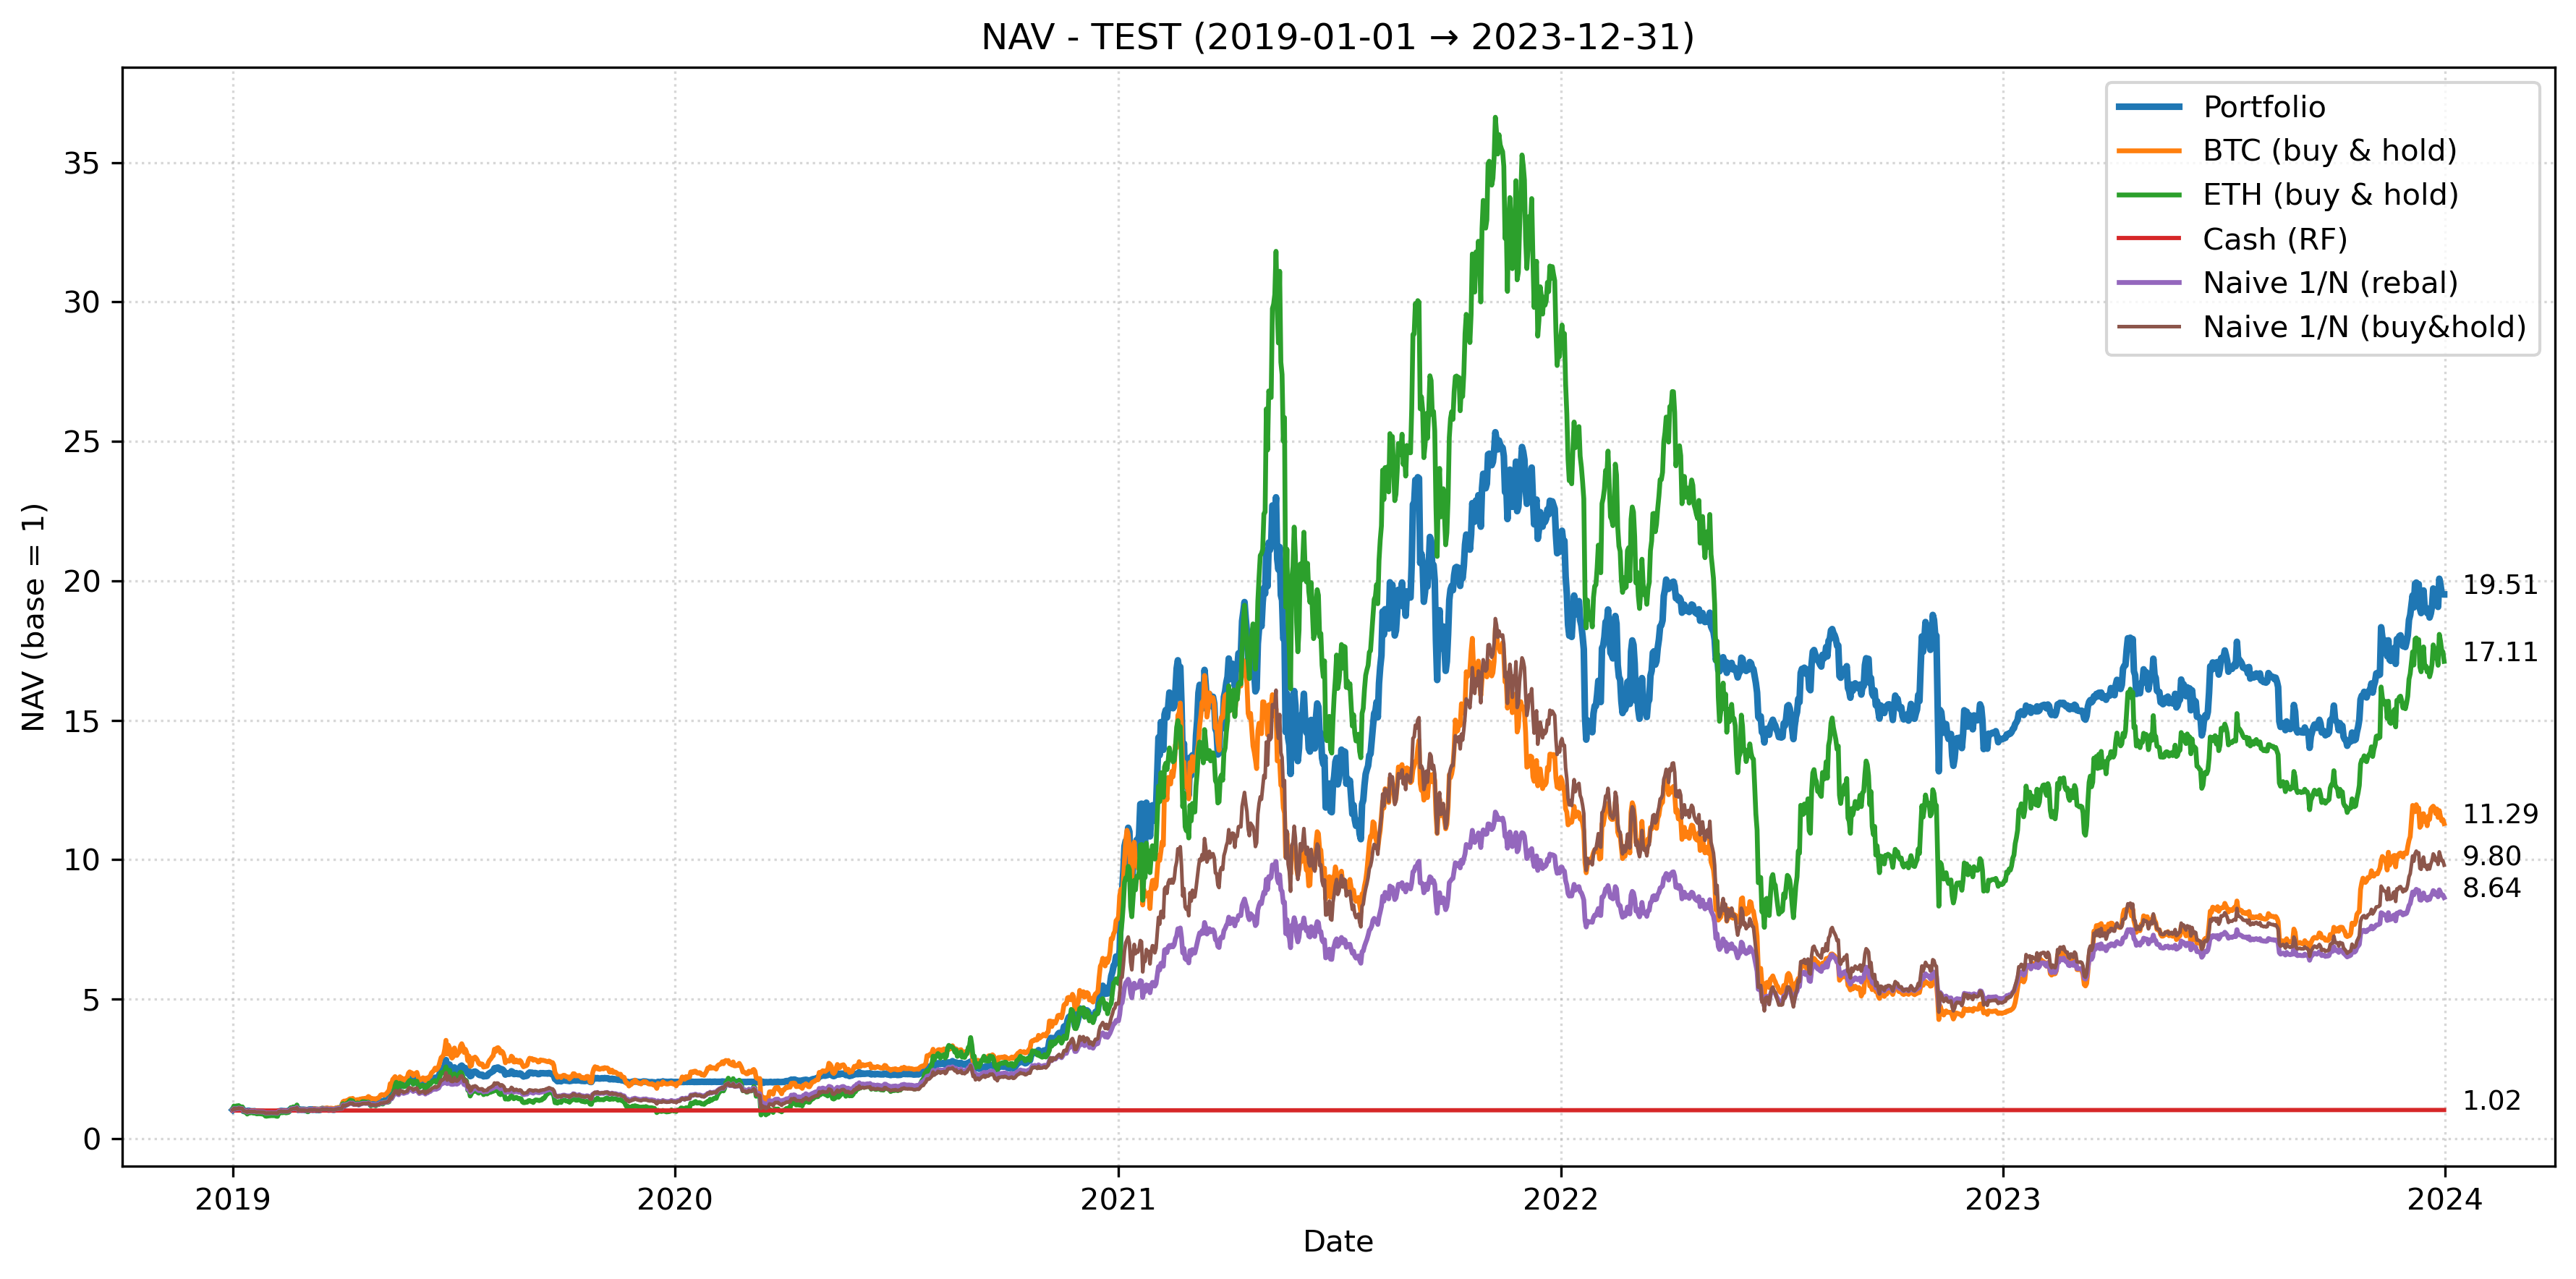

- The portfolio (blue line) significantly outperformed both **BTC buy-and-hold** and **ETH buy-and-hold** during the 2019–2023 test period.
- Final NAV (base=1):
  - **Portfolio**: 19.51  
  - **ETH (buy & hold)**: 17.11  
  - **BTC (buy & hold)**: 11.29  
  - **Naive 1/N (rebal)**: 8.64  
  - **Naive 1/N (buy & hold)**: 9.80  
  - **Cash (RF)**: 1.02  

---

## Key Takeaways
- The regime-switching, copula-simulated strategy consistently **outperformed benchmarks** in CAGR and risk-adjusted terms.  
- Drawdowns were smaller and recovery was stronger compared to single-asset buy-and-hold.  
- The portfolio displayed **better downside protection (CVaR 95%: 7.07%)** than BTC/ETH.  
